<a href="https://colab.research.google.com/github/ChandniJha630/Blogging-Website/blob/main/NIT_SILCHAR_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 Report



1.   Window size 100 for sequence lead to overfitting
2.   Window size 30 without duplicates showed following Results with 10 fold cross validation
*   Bidirectional LSTM Attention ; Acc: 0.9997; Std: 0.0008   
*   LSTM Attention ; Acc: 0.9983; Std: 0.0028
*   Conv LSTM Attention ; Acc: 0.2380; Std: 0.2870
3. Bidirectional LSTM Attentional was trained with random forest classifier which showed accuracy of 0.9861
4. Visualizing walking pattern for 5 users [View](https://colab.research.google.com/drive/1a8aTXPDT8fRursliD_9eVnOrLuuLv-jW#scrollTo=krRZCOnbVkwv&line=1&uniqifier=1)
5. Visualizing Quantiles of all 15 sensor values for 5 users using box plot[view](https://colab.research.google.com/drive/1a8aTXPDT8fRursliD_9eVnOrLuuLv-jW#scrollTo=xYM8y8ISYBpm&line=1&uniqifier=1)
6. Applying Central limit theorm to find what is mean value exhibited by all features for each user [view](https://colab.research.google.com/drive/1a8aTXPDT8fRursliD_9eVnOrLuuLv-jW#scrollTo=oESpBGAAk0df&line=1&uniqifier=1)













In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
pdf=pd.read_csv('/content/drive/MyDrive/NIT SILCHAR/processed_dataset.csv')

# Window size 100

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Layer
from keras.utils import to_categorical

# Assuming pdf is your dataframe
def create_sequences(df, window_size):
    X, Y = [], []
    for activity, group in df.groupby('activity'):
        group = group.drop('activity', axis=1)
        for i in range(len(group) - window_size):
            X.append(group.iloc[i:(i + window_size)].values)
            Y.append(activity)
    return np.array(X), np.array(Y)

# Create sequences of length 100
X, Y = create_sequences(pdf, 100)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

class attention(Layer):
    def __init__(self, return_sequences=False):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

def build_model(num_lstm_units):
    model = Sequential()
    model.add(Bidirectional(LSTM(num_lstm_units, return_sequences=True, input_shape=(100, 15))))
    model.add(attention(return_sequences=False))  # receive 2D and output 2D
    model.add(Dropout(0.3))
    model.add(Dense(25, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=10)
num_lstm_units = 32
batch_size = 16

fold_accuracies = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # One-hot encode the labels
    y_train_fold = to_categorical(y_train_fold, num_classes=25)
    y_val_fold = to_categorical(y_val_fold, num_classes=25)

    model = build_model(num_lstm_units)
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=3)

    model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=100, validation_data=(X_val_fold, y_val_fold), callbacks=[es], verbose=2)

    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(accuracy)

mean_accuracy = np.mean(fold_accuracies)
std_dev_accuracy = np.std(fold_accuracies)

print(f'Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_dev_accuracy:.4f}')


Epoch 1/100
281/281 - 36s - loss: 1.4075 - accuracy: 0.6998 - val_loss: 0.4729 - val_accuracy: 0.9320 - 36s/epoch - 128ms/step
Epoch 2/100
281/281 - 17s - loss: 0.3231 - accuracy: 0.9664 - val_loss: 0.1302 - val_accuracy: 0.9940 - 17s/epoch - 62ms/step
Epoch 3/100
281/281 - 18s - loss: 0.1216 - accuracy: 0.9944 - val_loss: 0.0471 - val_accuracy: 1.0000 - 18s/epoch - 63ms/step
Epoch 4/100
281/281 - 17s - loss: 0.0558 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 1.0000 - 17s/epoch - 59ms/step
Epoch 5/100
281/281 - 17s - loss: 0.0388 - accuracy: 0.9996 - val_loss: 0.0150 - val_accuracy: 1.0000 - 17s/epoch - 59ms/step
Epoch 6/100
281/281 - 17s - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 1.0000 - 17s/epoch - 61ms/step
Epoch 7/100
281/281 - 17s - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000 - 17s/epoch - 59ms/step
Epoch 7: early stopping
Epoch 1/100
281/281 - 23s - loss: 1.4177 - accuracy: 0.6820 - val_loss: 0.5266 - val_accuracy

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, GlobalAveragePooling1D, Bidirectional, Dropout
from keras.layers import Layer, Attention
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# Assuming pdf is your dataframe
def create_sequences(df, window_size):
    X, Y = [], []
    for activity, group in df.groupby('activity'):
        group = group.drop('activity', axis=1)
        for i in range(len(group) - window_size):
            X.append(group.iloc[i:(i + window_size)].values)
            Y.append(activity)
    return np.array(X), np.array(Y)

# Create sequences of length 100
X, Y = create_sequences(pdf, 100)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

def build_model():
    inputs = Input(shape=(100, 15))

    # LSTM layer
    lstm_out = LSTM(32, return_sequences=True)(inputs)  # using 32 units

    # Attention layer
    attention = Attention()([lstm_out, lstm_out])

    # Global average pooling
    pooling = GlobalAveragePooling1D()(attention)

    # Output layer
    outputs = Dense(25, activation='softmax')(pooling)

    # Create the model
    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=10)
batch_size = 16

fold_accuracies = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # One-hot encode the labels
    y_train_fold = to_categorical(y_train_fold, num_classes=25)
    y_val_fold = to_categorical(y_val_fold, num_classes=25)

    model = build_model()
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=3)

    model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=100, validation_data=(X_val_fold, y_val_fold), callbacks=[es], verbose=0)

    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(accuracy)

mean_accuracy = np.mean(fold_accuracies)
std_dev_accuracy = np.std(fold_accuracies)

print(f'Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_dev_accuracy:.4f}')


Epoch 8: early stopping
Epoch 8: early stopping
Epoch 8: early stopping
Epoch 8: early stopping
Epoch 8: early stopping
Epoch 8: early stopping
Epoch 8: early stopping
Epoch 8: early stopping
Epoch 7: early stopping
Epoch 9: early stopping
Mean Accuracy: 1.0000, Std Dev: 0.0000


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, GlobalAveragePooling1D, Layer
from keras.layers import MultiHeadAttention, LayerNormalization
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# Assuming pdf is your dataframe
def create_sequences(df, window_size):
    X, Y = [], []
    for activity, group in df.groupby('activity'):
        group = group.drop('activity', axis=1)
        for i in range(len(group) - window_size):
            X.append(group.iloc[i:(i + window_size)].values)
            Y.append(activity)
    return np.array(X), np.array(Y)

# Create sequences of length 100
sequence_length = 100
num_features = 15
num_classes = 25

X, Y = create_sequences(pdf, sequence_length)



class AttentionAugmentedConv(Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(AttentionAugmentedConv, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv = Conv1D(filters, kernel_size, padding='same', use_bias=False)
        self.attention = MultiHeadAttention(num_heads=8, key_dim=filters//8)
        self.norm = LayerNormalization()

    def call(self, inputs):
        conv_out = self.conv(inputs)
        attn_out = self.attention(conv_out, conv_out)
        attn_out = self.norm(attn_out)
        return conv_out + attn_out

def build_model():
    inputs = Input(shape=(sequence_length, num_features))

    # Convolutional layer
    conv_out = Conv1D(64, 3, activation='relu')(inputs)  # 64 filters, kernel size of 3

    # Attention Augmented Convolution
    attention_augmented_conv = AttentionAugmentedConv(filters=64, kernel_size=3)(conv_out)

    # Global average pooling
    pooling = GlobalAveragePooling1D()(attention_augmented_conv)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(pooling)

    # Create the model
    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=10)
batch_size = 16

fold_accuracies = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

    # One-hot encode the labels
    y_train_fold = to_categorical(y_train_fold, num_classes=num_classes)
    y_val_fold = to_categorical(y_val_fold, num_classes=num_classes)

    model = build_model()
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=3)

    model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=100, validation_data=(X_val_fold, y_val_fold), callbacks=[es], verbose=0)

    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(accuracy)

mean_accuracy = np.mean(fold_accuracies)
std_dev_accuracy = np.std(fold_accuracies)

print(f'Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_dev_accuracy:.4f}')


Epoch 6: early stopping
Epoch 5: early stopping
Epoch 7: early stopping
Epoch 5: early stopping
Epoch 6: early stopping
Epoch 6: early stopping
Epoch 5: early stopping
Epoch 6: early stopping
Epoch 6: early stopping
Epoch 5: early stopping
Mean Accuracy: 0.2863, Std Dev: 0.2246


In [ ]:
print(pdf.shape)

(8643, 16)


# Change seq size to 30

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Layer
from keras.utils import to_categorical

# Assuming pdf is your dataframe
def create_sequences(df, window_size):
    X, Y = [], []
    for activity, group in df.groupby('activity'):
        group = group.drop('activity', axis=1)
        for i in range(len(group) - window_size):
            X.append(group.iloc[i:(i + window_size)].values)
            Y.append(activity)
    return np.array(X), np.array(Y)

# Create sequences of length 32
X, Y = create_sequences(pdf, 32)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.05, random_state=42)

class attention(Layer):
    def __init__(self, return_sequences=False):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

def build_model(num_lstm_units):
    model = Sequential()
    model.add(Bidirectional(LSTM(num_lstm_units, return_sequences=True, input_shape=(32, 15))))
    model.add(attention(return_sequences=False))  # receive 2D and output 2D
    model.add(Dropout(0.3))
    model.add(Dense(25, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=10)
num_lstm_units = 32
batch_size = 16

fold_accuracies = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # One-hot encode the labels
    y_train_fold = to_categorical(y_train_fold, num_classes=25)
    y_val_fold = to_categorical(y_val_fold, num_classes=25)

    model = build_model(num_lstm_units)
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=3)

    model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=100, validation_data=(X_val_fold, y_val_fold), callbacks=[es], verbose=0)

    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(accuracy)

mean_accuracy = np.mean(fold_accuracies)
std_dev_accuracy = np.std(fold_accuracies)

print(f'Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_dev_accuracy:.4f}')


Epoch 16: early stopping
Epoch 18: early stopping
Epoch 17: early stopping
Epoch 18: early stopping
Epoch 12: early stopping
Epoch 15: early stopping
Epoch 14: early stopping
Epoch 15: early stopping
Epoch 18: early stopping
Epoch 15: early stopping
Mean Accuracy: 0.9997, Std Dev: 0.0008


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, GlobalAveragePooling1D, Bidirectional, Dropout
from keras.layers import Layer, Attention
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# Assuming pdf is your dataframe
def create_sequences(df, window_size):
    X, Y = [], []
    for activity, group in df.groupby('activity'):
        group = group.drop('activity', axis=1)
        for i in range(len(group) - window_size):
            X.append(group.iloc[i:(i + window_size)].values)
            Y.append(activity)
    return np.array(X), np.array(Y)

# Create sequences of length 100
X, Y = create_sequences(pdf, 30)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

def build_model():
    inputs = Input(shape=(30, 15))

    # LSTM layer
    lstm_out = LSTM(32, return_sequences=True)(inputs)  # using 32 units

    # Attention layer
    attention = Attention()([lstm_out, lstm_out])

    # Global average pooling
    pooling = GlobalAveragePooling1D()(attention)

    # Output layer
    outputs = Dense(25, activation='softmax')(pooling)

    # Create the model
    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=10)
batch_size = 16

fold_accuracies = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # One-hot encode the labels
    y_train_fold = to_categorical(y_train_fold, num_classes=25)
    y_val_fold = to_categorical(y_val_fold, num_classes=25)

    model = build_model()
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=3)

    model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=100, validation_data=(X_val_fold, y_val_fold), callbacks=[es], verbose=0)

    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(accuracy)

mean_accuracy = np.mean(fold_accuracies)
std_dev_accuracy = np.std(fold_accuracies)

print(f'Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_dev_accuracy:.4f}')


Epoch 13: early stopping
Epoch 13: early stopping
Epoch 18: early stopping
Epoch 17: early stopping
Epoch 15: early stopping
Epoch 17: early stopping
Epoch 17: early stopping
Epoch 11: early stopping
Epoch 14: early stopping
Epoch 15: early stopping
Mean Accuracy: 0.9983, Std Dev: 0.0028


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, GlobalAveragePooling1D, Layer
from keras.layers import MultiHeadAttention, LayerNormalization
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# Assuming pdf is your dataframe
def create_sequences(df, window_size):
    X, Y = [], []
    for activity, group in df.groupby('activity'):
        group = group.drop('activity', axis=1)
        for i in range(len(group) - window_size):
            X.append(group.iloc[i:(i + window_size)].values)
            Y.append(activity)
    return np.array(X), np.array(Y)

# Create sequences of length 100
sequence_length = 30
num_features = 15
num_classes = 25

X, Y = create_sequences(pdf, sequence_length)



class AttentionAugmentedConv(Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(AttentionAugmentedConv, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv = Conv1D(filters, kernel_size, padding='same', use_bias=False)
        self.attention = MultiHeadAttention(num_heads=8, key_dim=filters//8)
        self.norm = LayerNormalization()

    def call(self, inputs):
        conv_out = self.conv(inputs)
        attn_out = self.attention(conv_out, conv_out)
        attn_out = self.norm(attn_out)
        return conv_out + attn_out

def build_model():
    inputs = Input(shape=(sequence_length, num_features))

    # Convolutional layer
    conv_out = Conv1D(64, 3, activation='relu')(inputs)  # 64 filters, kernel size of 3

    # Attention Augmented Convolution
    attention_augmented_conv = AttentionAugmentedConv(filters=64, kernel_size=3)(conv_out)

    # Global average pooling
    pooling = GlobalAveragePooling1D()(attention_augmented_conv)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(pooling)

    # Create the model
    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=10)
batch_size = 16

fold_accuracies = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

    # One-hot encode the labels
    y_train_fold = to_categorical(y_train_fold, num_classes=num_classes)
    y_val_fold = to_categorical(y_val_fold, num_classes=num_classes)

    model = build_model()
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=3)

    model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=100, validation_data=(X_val_fold, y_val_fold), callbacks=[es], verbose=0)

    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(accuracy)

mean_accuracy = np.mean(fold_accuracies)
std_dev_accuracy = np.std(fold_accuracies)

print(f'Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_dev_accuracy:.4f}')


Epoch 8: early stopping
Epoch 7: early stopping
Epoch 7: early stopping
Epoch 8: early stopping
Epoch 7: early stopping
Epoch 7: early stopping
Epoch 6: early stopping
Epoch 7: early stopping
Epoch 7: early stopping
Epoch 9: early stopping
Mean Accuracy: 0.2380, Std Dev: 0.2070


# Lets Try Without Removing Duplicates

In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/NIT SILCHAR/Gait_final.csv")

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

# 1. Check for missing and corrupted values
df = df.dropna(how='any')  # drop rows with missing values
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Impute missing values with the mean (if any)
for column in df.columns:
    df[column].fillna(df[column].mean(), inplace=True)


# 3. Check for class imbalance
target = 'activity'
if df[target].value_counts().min() / df[target].value_counts().max() < 0.5:
    smote = SMOTE(sampling_strategy='minority')
    X_sm, y_sm = smote.fit_resample(df.drop(target, axis=1), df[target])
    df = pd.concat([pd.DataFrame(X_sm), pd.DataFrame(y_sm, columns=[target])], axis=1)

# 4. Standardization
scaler = StandardScaler()
X = df.drop(columns=[target])
Y = df[target]
X_scaled = scaler.fit_transform(X)

# 5. Check the correlation matrix and drop features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features
X = X.drop(columns=to_drop)

# 6. Store the processed dataset in a CSV file
df = pd.concat([X, Y], axis=1)
df.to_csv('/content/drive/MyDrive/NIT SILCHAR/processed_dataset_with_dups.csv', index=False)


In [ ]:
import pandas as pd
pdf2=pd.read_csv('/content/drive/MyDrive/NIT SILCHAR/processed_dataset_with_dups.csv')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Layer
from keras.utils import to_categorical

# Assuming pdf is your dataframe
def create_sequences(df, window_size):
    X, Y = [], []
    for activity, group in df.groupby('activity'):
        group = group.drop('activity', axis=1)
        for i in range(len(group) - window_size):
            X.append(group.iloc[i:(i + window_size)].values)
            Y.append(activity)
    return np.array(X), np.array(Y)

# Create sequences of length 32
X, Y = create_sequences(pdf2, 30)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.05, random_state=42)

class attention(Layer):
    def __init__(self, return_sequences=False):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

def build_model(num_lstm_units):
    model = Sequential()
    model.add(Bidirectional(LSTM(num_lstm_units, return_sequences=True, input_shape=(30, 15))))
    model.add(attention(return_sequences=False))  # receive 2D and output 2D
    model.add(Dropout(0.3))
    model.add(Dense(25, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=10)
num_lstm_units = 32
batch_size = 16

fold_accuracies = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # One-hot encode the labels
    y_train_fold = to_categorical(y_train_fold, num_classes=25)
    y_val_fold = to_categorical(y_val_fold, num_classes=25)

    model = build_model(num_lstm_units)
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=3)

    model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=100, validation_data=(X_val_fold, y_val_fold), callbacks=[es], verbose=2)

    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_accuracies.append(accuracy)

mean_accuracy = np.mean(fold_accuracies)
std_dev_accuracy = np.std(fold_accuracies)

print(f'Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_dev_accuracy:.4f}')


Epoch 1/100
2333/2333 - 53s - loss: 0.5471 - accuracy: 0.8784 - val_loss: 0.0907 - val_accuracy: 0.9879 - 53s/epoch - 23ms/step
Epoch 2/100
2333/2333 - 41s - loss: 0.0810 - accuracy: 0.9849 - val_loss: 0.0217 - val_accuracy: 0.9981 - 41s/epoch - 18ms/step
Epoch 3/100
2333/2333 - 43s - loss: 0.0315 - accuracy: 0.9947 - val_loss: 0.0074 - val_accuracy: 0.9998 - 43s/epoch - 18ms/step
Epoch 4/100
2333/2333 - 41s - loss: 0.0190 - accuracy: 0.9969 - val_loss: 0.0066 - val_accuracy: 0.9986 - 41s/epoch - 18ms/step
Epoch 5/100
2333/2333 - 42s - loss: 0.0132 - accuracy: 0.9976 - val_loss: 0.0026 - val_accuracy: 0.9986 - 42s/epoch - 18ms/step
Epoch 6/100
2333/2333 - 42s - loss: 0.0094 - accuracy: 0.9983 - val_loss: 0.0030 - val_accuracy: 1.0000 - 42s/epoch - 18ms/step
Epoch 7/100
2333/2333 - 43s - loss: 0.0088 - accuracy: 0.9982 - val_loss: 0.0016 - val_accuracy: 0.9995 - 43s/epoch - 18ms/step
Epoch 8/100
2333/2333 - 45s - loss: 0.0054 - accuracy: 0.9992 - val_loss: 3.9021e-04 - val_accuracy: 1.0

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from keras.models import Model
from keras.layers import Bidirectional, LSTM, Dropout, Dense, Input
from keras import backend as K
from keras.layers import Layer
from keras.utils import to_categorical

# Assuming pdf is your dataframe
def create_sequences(df, window_size):
    X, Y = [], []
    for activity, group in df.groupby('activity'):
        group = group.drop('activity', axis=1)
        for i in range(len(group) - window_size):
            X.append(group.iloc[i:(i + window_size)].values)
            Y.append(activity)
    return np.array(X), np.array(Y)

# Create sequences of length 32
X, Y = create_sequences(pdf, 32)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.05, random_state=42)

class attention(Layer):
    def __init__(self, return_sequences=False):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

def build_lstm_model(num_lstm_units):
    inputs = Input(shape=(32, 15))
    x = Bidirectional(LSTM(num_lstm_units, return_sequences=True))(inputs)
    x = attention(return_sequences=False)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(25, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

num_lstm_units = 32
batch_size = 16

model = build_lstm_model(num_lstm_units)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

y_train_cat = to_categorical(y_train, num_classes=25)
y_val_cat = to_categorical(y_val, num_classes=25)

model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=100, validation_data=(X_val, y_val_cat), callbacks=[es], verbose=1)

# Extract features using the trained LSTM model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
X_train_features = feature_extractor.predict(X_train)
X_val_features = feature_extractor.predict(X_val)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train a Random Forest classifier with reduced complexity
rf_clf = RandomForestClassifier(n_estimators=15, max_depth=7, max_features='sqrt', min_samples_split=10, random_state=42)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(rf_clf, X_train_features, y_train, cv=5)

# Print the cross-validation accuracy
print(f'Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Fit the model on the entire training set and evaluate on the validation set
rf_clf.fit(X_train_features, y_train)
y_val_pred = rf_clf.predict(X_val_features)
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.4f}')


Epoch 1/100
468/468 [==============================] - 19s 26ms/step - loss: 1.4570 - accuracy: 0.6468 - val_loss: 0.6341 - val_accuracy: 0.8655
Epoch 2/100
468/468 [==============================] - 11s 24ms/step - loss: 0.4413 - accuracy: 0.9195 - val_loss: 0.2500 - val_accuracy: 0.9645
Epoch 3/100
468/468 [==============================] - 9s 19ms/step - loss: 0.2068 - accuracy: 0.9721 - val_loss: 0.1110 - val_accuracy: 0.9848
Epoch 4/100
468/468 [==============================] - 11s 24ms/step - loss: 0.1117 - accuracy: 0.9898 - val_loss: 0.0562 - val_accuracy: 0.9949
Epoch 5/100
468/468 [==============================] - 11s 24ms/step - loss: 0.0698 - accuracy: 0.9955 - val_loss: 0.0306 - val_accuracy: 1.0000
Epoch 6/100
468/468 [==============================] - 9s 19ms/step - loss: 0.0443 - accuracy: 0.9980 - val_loss: 0.0177 - val_accuracy: 0.9975
Epoch 7/100
468/468 [==============================] - 11s 24ms/step - loss: 0.0337 - accuracy: 0.9968 - val_loss: 0.0128 - val_accu

#  analyzing the difference between the walking patterns using matplotlib.

In [ ]:
pdf

AG-X       AG-Y      AG-Z      Acc-X      Acc-Y     Acc-Z  \
0     0.186748  -9.658210 -0.811634   0.132390  -0.193266  0.342404   
1     0.438139  -9.964667 -0.237026   0.305187  -0.201476  0.160347   
2     0.577003  -9.988609 -0.328006  -0.153218  -0.241599 -0.027692   
3     0.134075 -10.019734 -0.478840  -0.102032  -0.228701 -0.025108   
4     0.172383 -10.036493 -0.371101   0.056843  -0.233742 -0.004172   
...        ...        ...       ...        ...        ...       ...   
8638 -2.840177  -8.758073 -0.922517  -5.278461  -7.674048  9.855844   
8639 -3.039199  -9.857966  1.639117  -3.964532  -0.864655 -4.129151   
8640 -5.060483  -9.043691  3.403098   0.891328  -0.255419  1.614499   
8641 -3.557890 -15.118120 -1.802342 -15.200046 -12.054322  4.352625   
8642 -6.137231 -10.161520  7.403798  -2.085634 -10.035357  8.240055   

      Gravity-X  Gravity-Y  Gravity-Z      RR-X      RR-Y      RR-Z      RV-X  \
0      0.307729  -9.789528  -0.490747  0.070860 -0.015882  0.015272 -0.032754   
1      0.320812  -9.792500  -0.417629  0.028711  0.155771  0.006720 -0.038083   
2      0.283991  -9.795822  -0.362753  0.038485  0.206472  0.010996 -0.044029   
3      0.249615  -9.797963  -0.328622  0.070250  0.285885 -0.083689 -0.050764   
4      0.285076  -9.798630  -0.275604  0.053145  0.356134 -0.111177 -0.065057   
...         ...        ...        ...       ...       ...       ...       ...   
8638  -2.756033   0.612899  -9.324907  2.043732 -1.565109  2.314843 -0.190140   
8639  -0.456442  -7.811526   5.909720 -0.162002 -0.198663  0.174277 -0.466467   
8640  -4.051826  -8.423957   2.877560 -0.230424  1.858078  0.037503 -0.457368   
8641   6.773430   6.650082  -1.116203 -0.035627 -1.076979  0.671760 -0.305653   
8642  -0.581205  -1.869285  -9.497309 -0.007741  0.833151 -0.801310  0.290104   

          RV-Y      RV-Z  activity  
0    -0.719321  0.691981         1  
1    -0.717847  0.693019         1  
2    -0.715621  0.694245         1  
3    -0.713273  0.694827         1  
4    -0.712350  0.693270         1  
...        ...       ...       ...  
8638  0.956668 -0.018707        22  
8639  0.312967 -0.200563        22  
8640  0.451413 -0.255162        22  
8641 -0.337283 -0.347335        22  
8642 -0.690412  0.074308        22  

[8643 rows x 16 columns]

In [ ]:
plotty=['AG-X', 'AG-Y', 'AG-Z', 'Acc-X', 'Acc-Y', 'Acc-Z', 'Gravity-X',
       'Gravity-Y', 'Gravity-Z', 'RR-X', 'RR-Y', 'RR-Z', 'RV-X', 'RV-Y',
       'RV-Z']

# Visualizing All features for 5 users

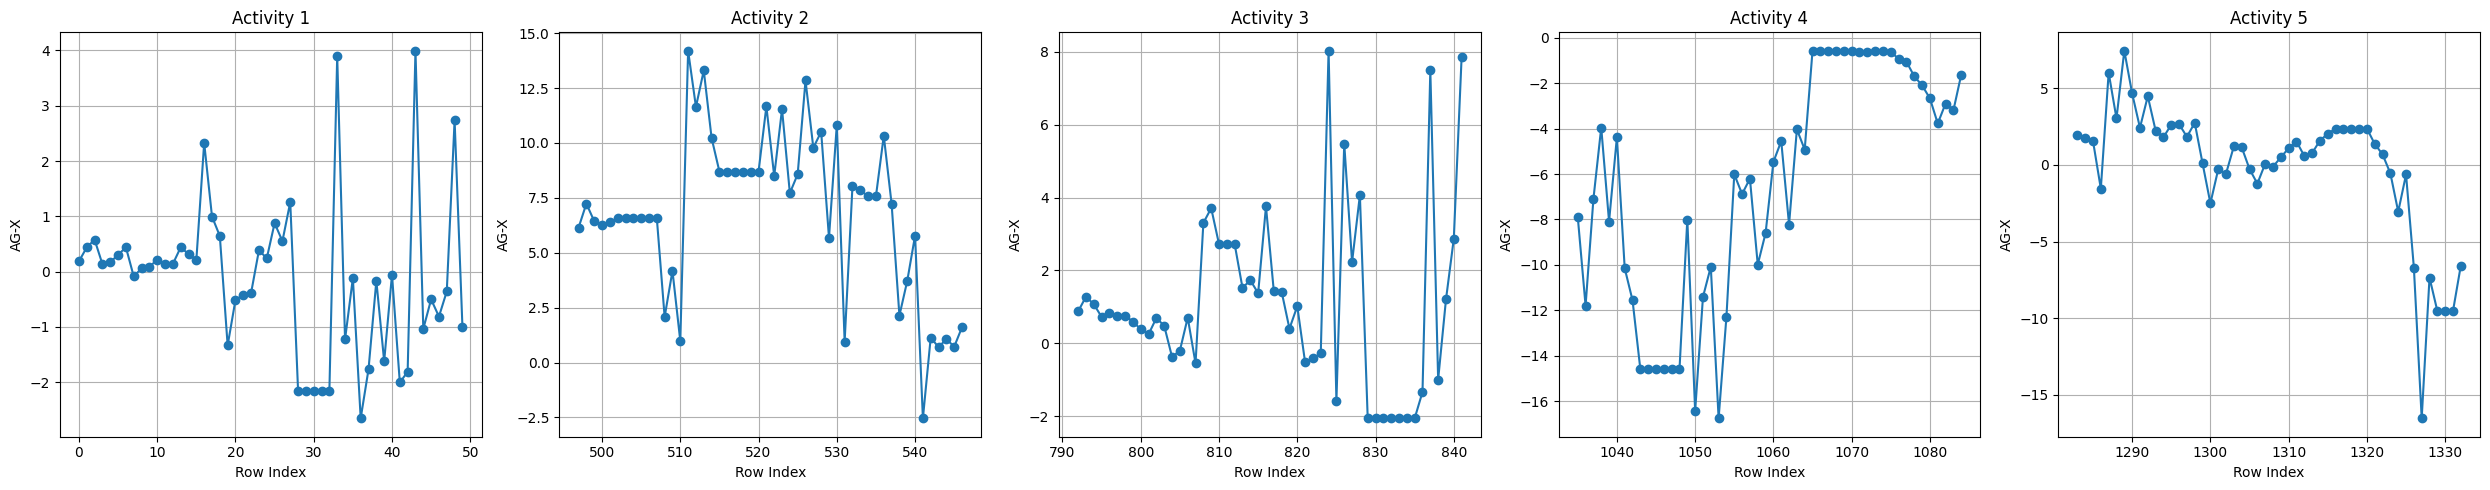

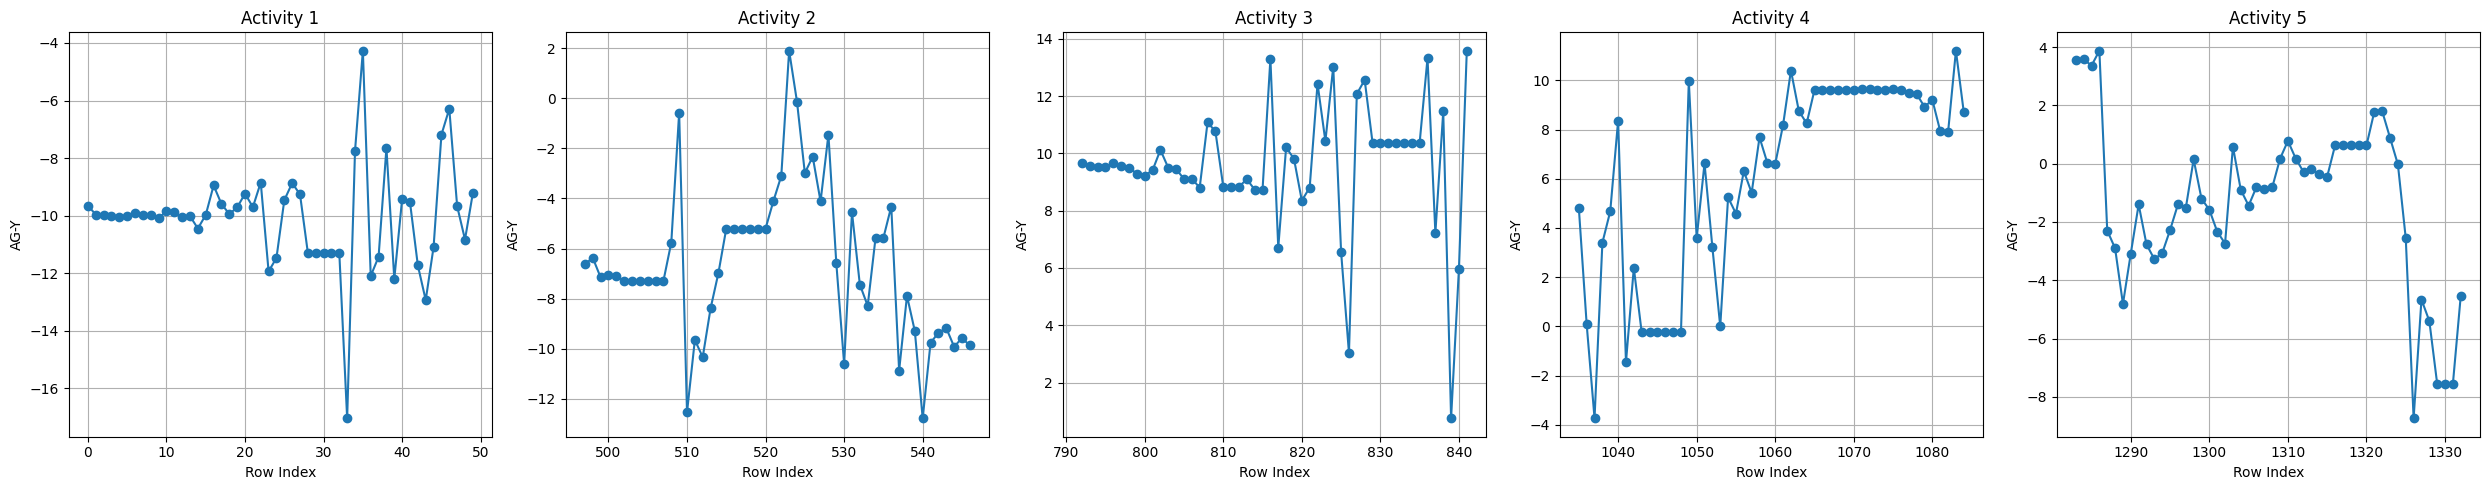

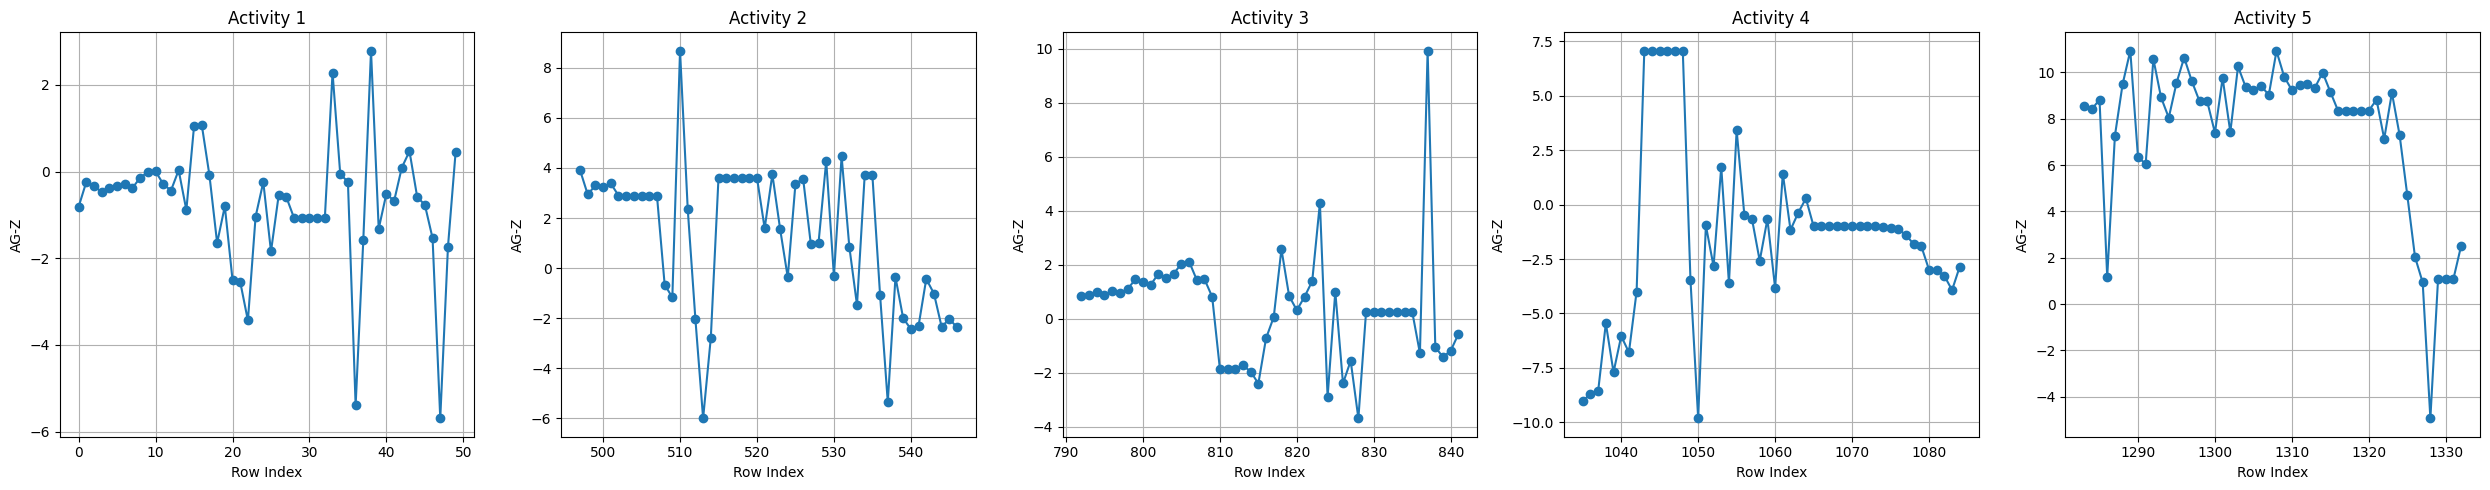

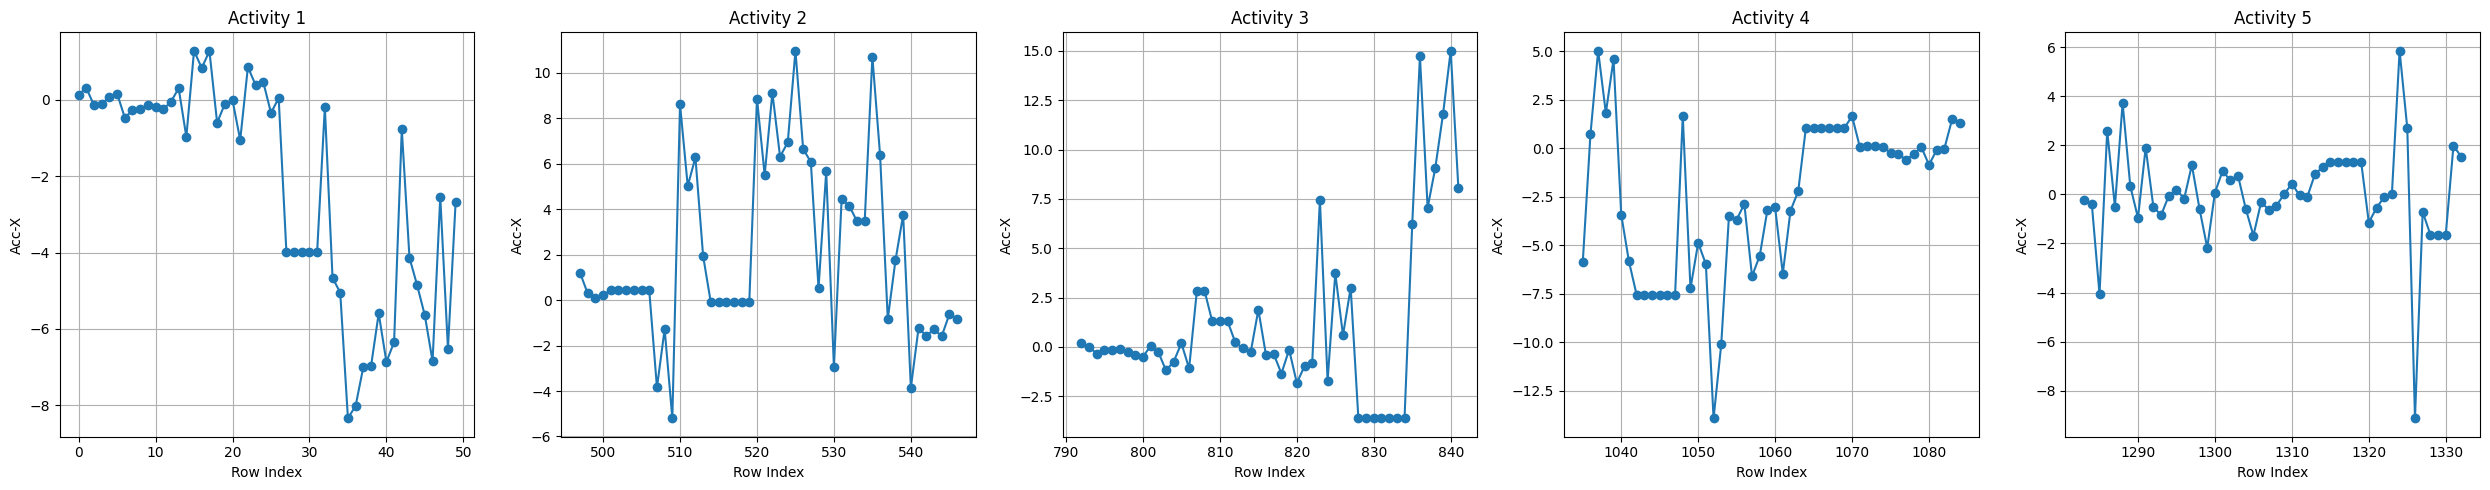

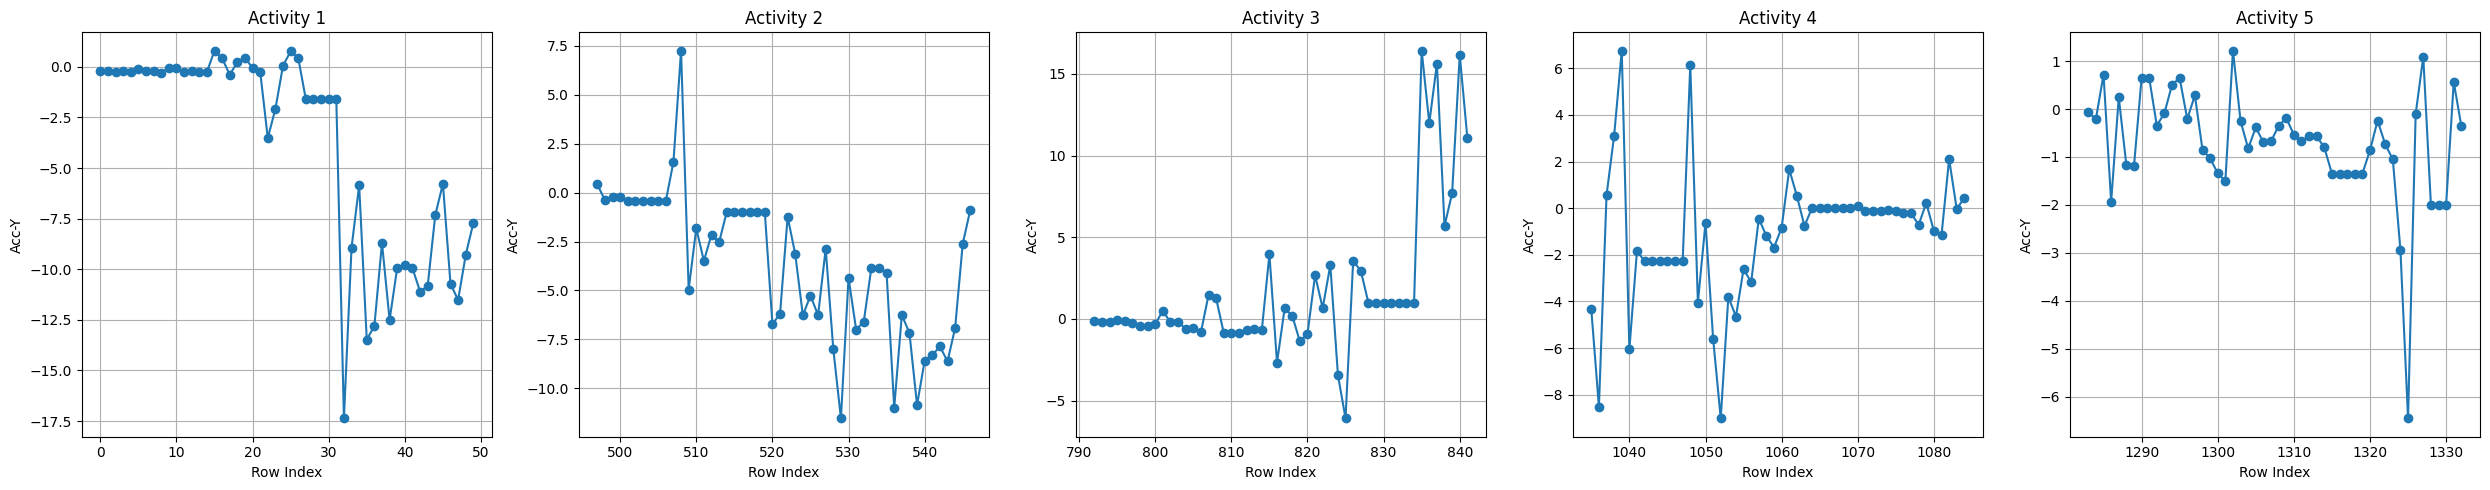

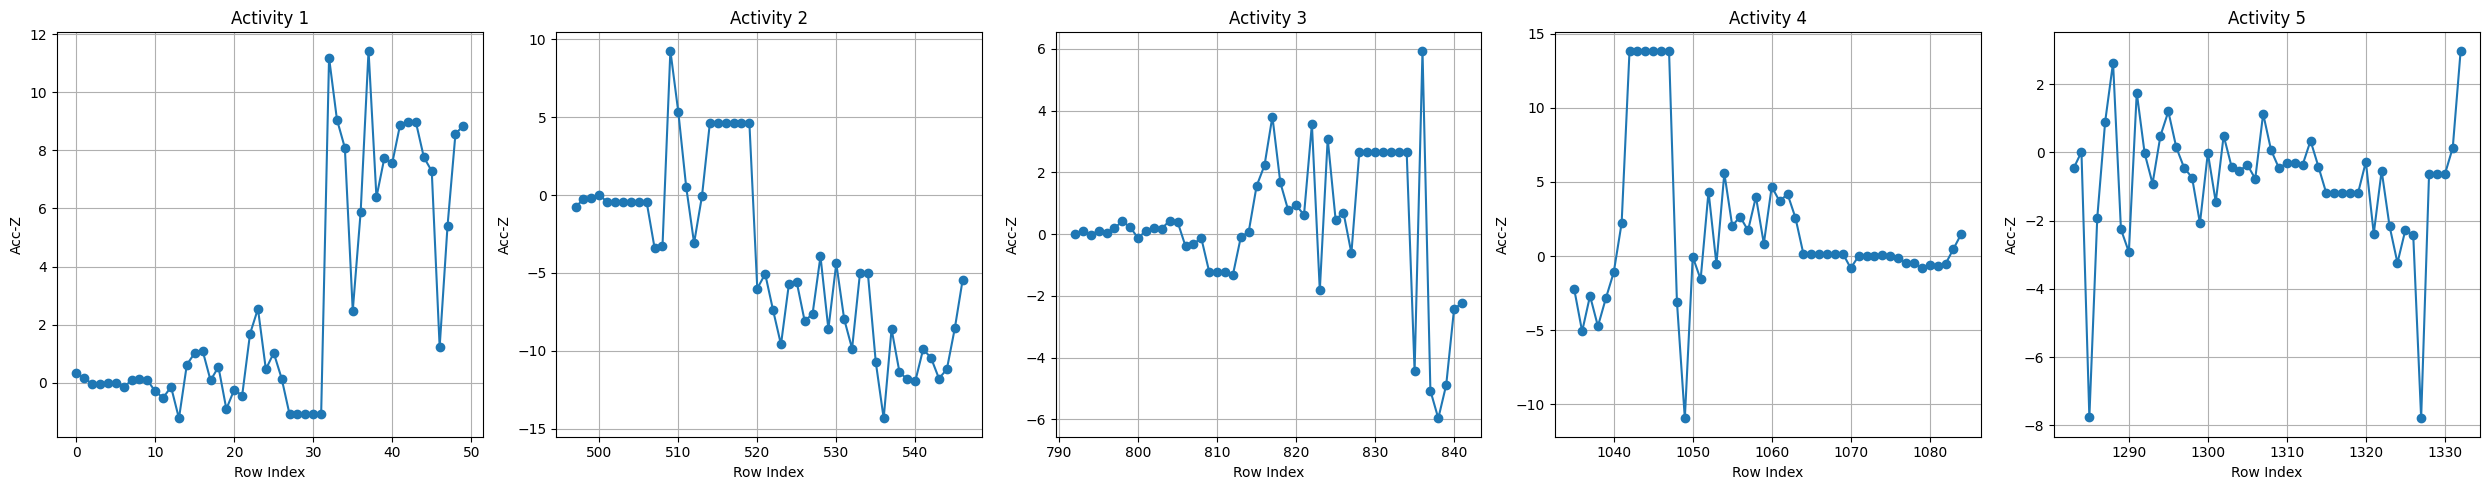

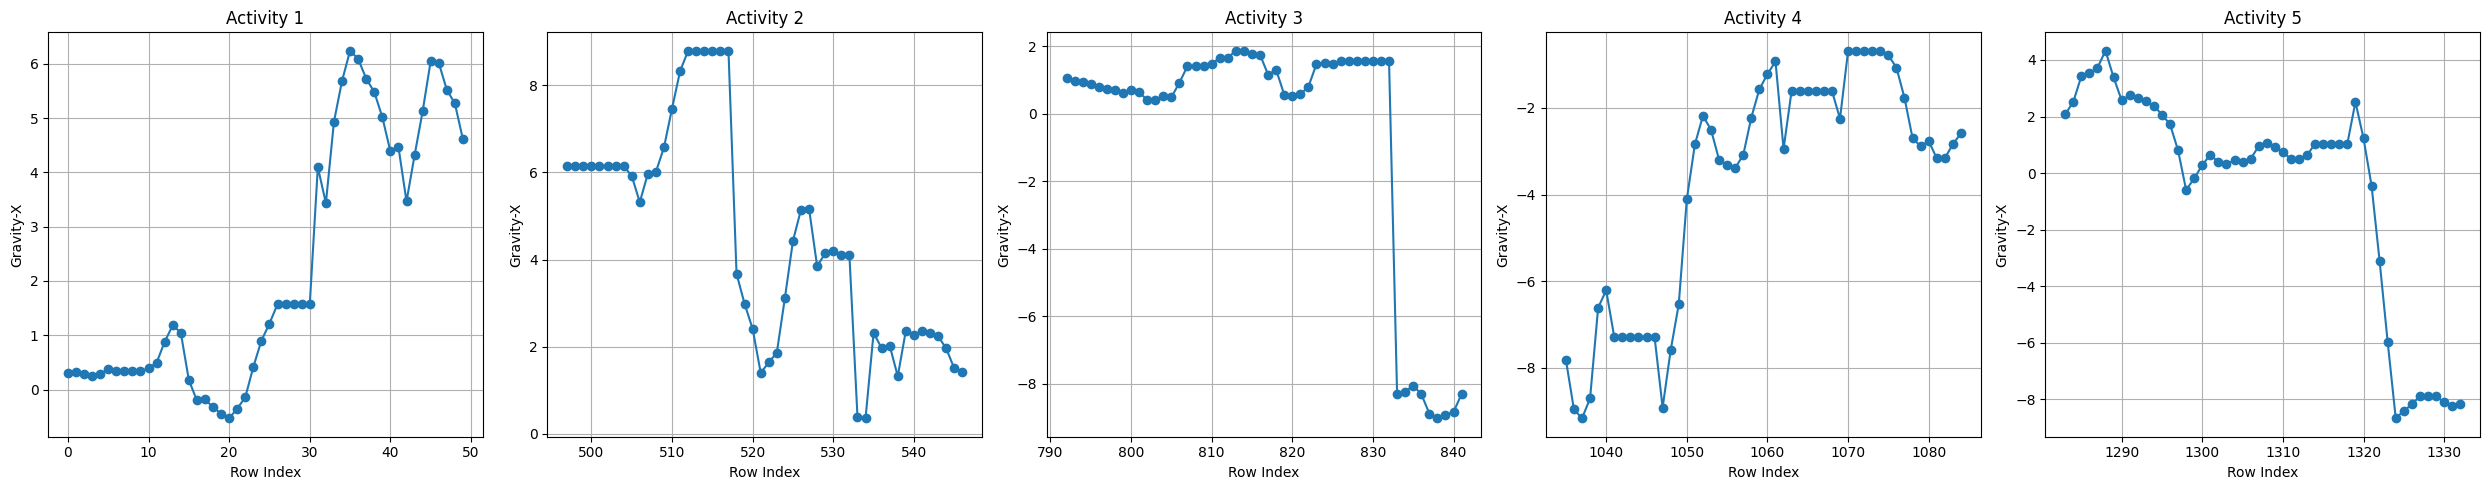

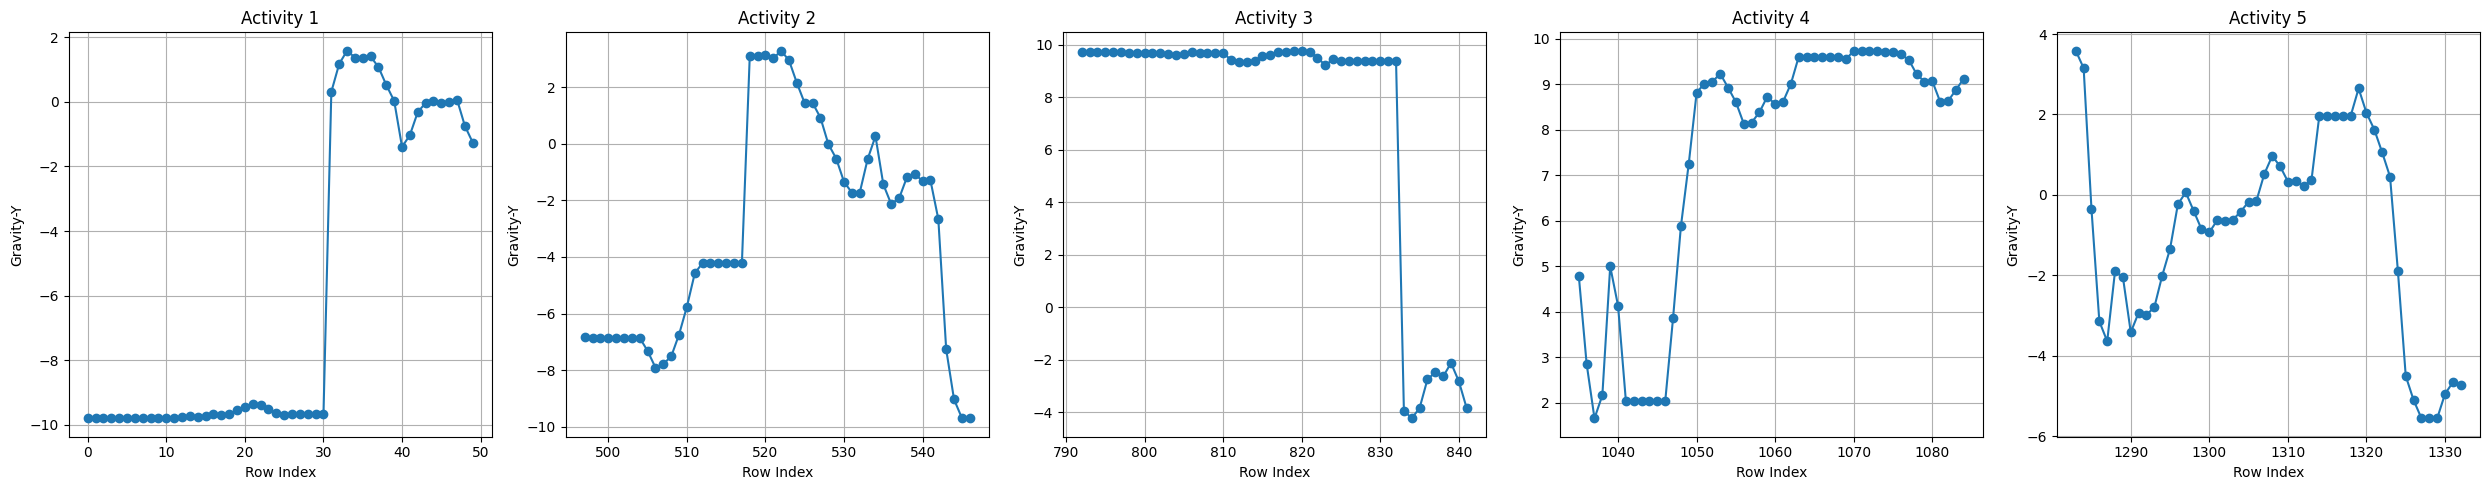

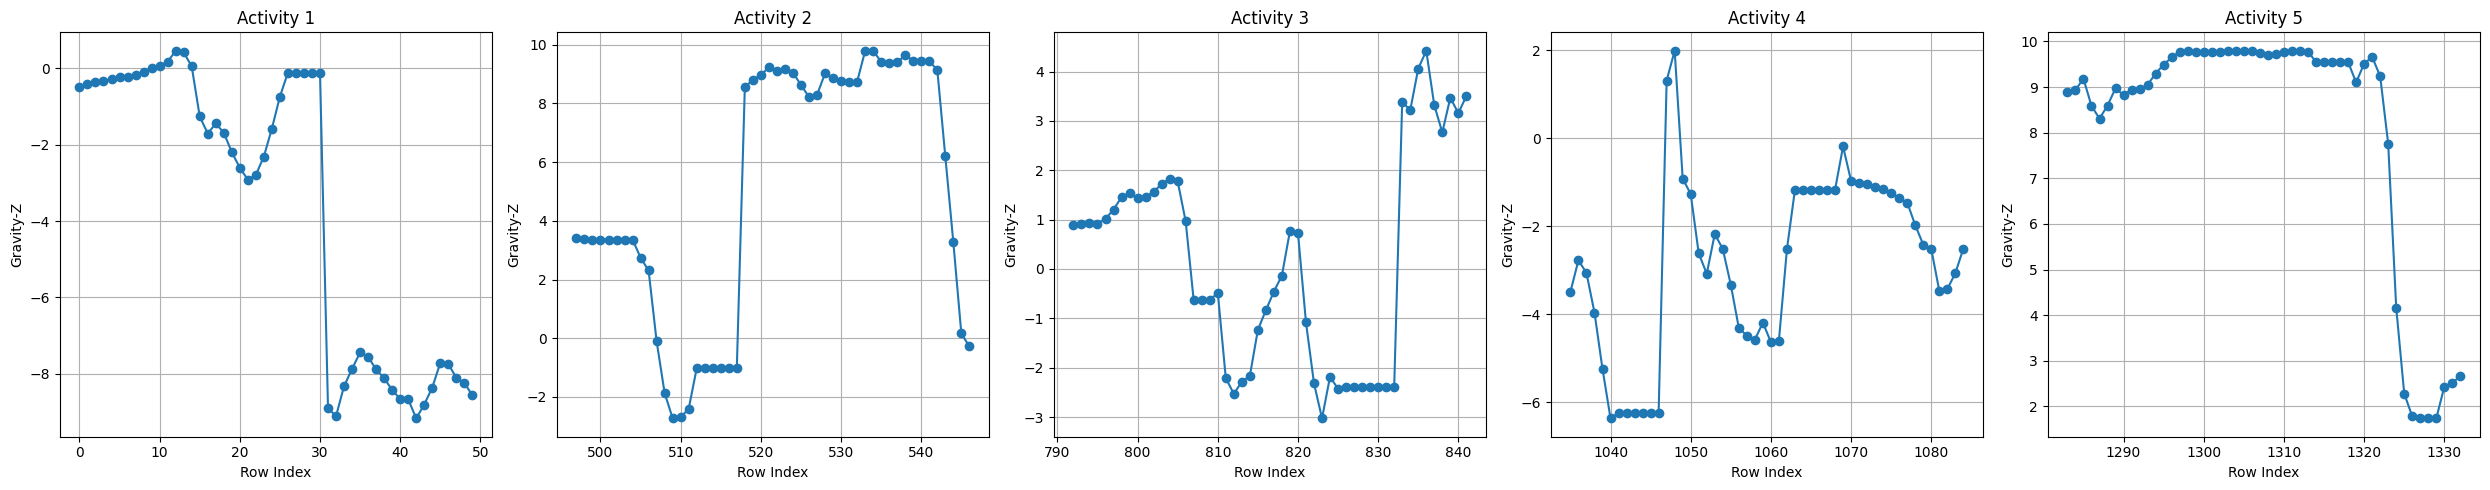

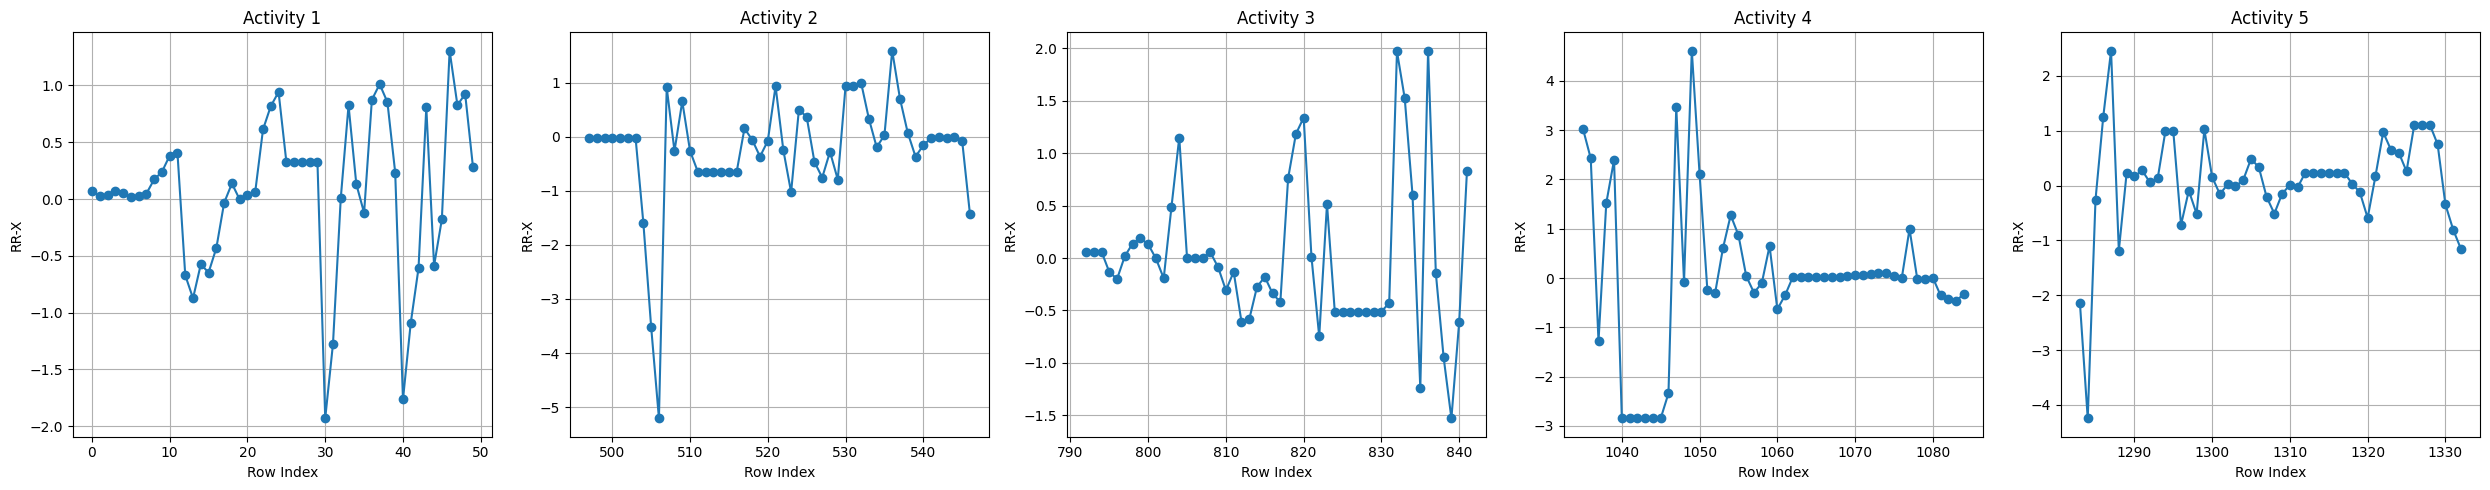

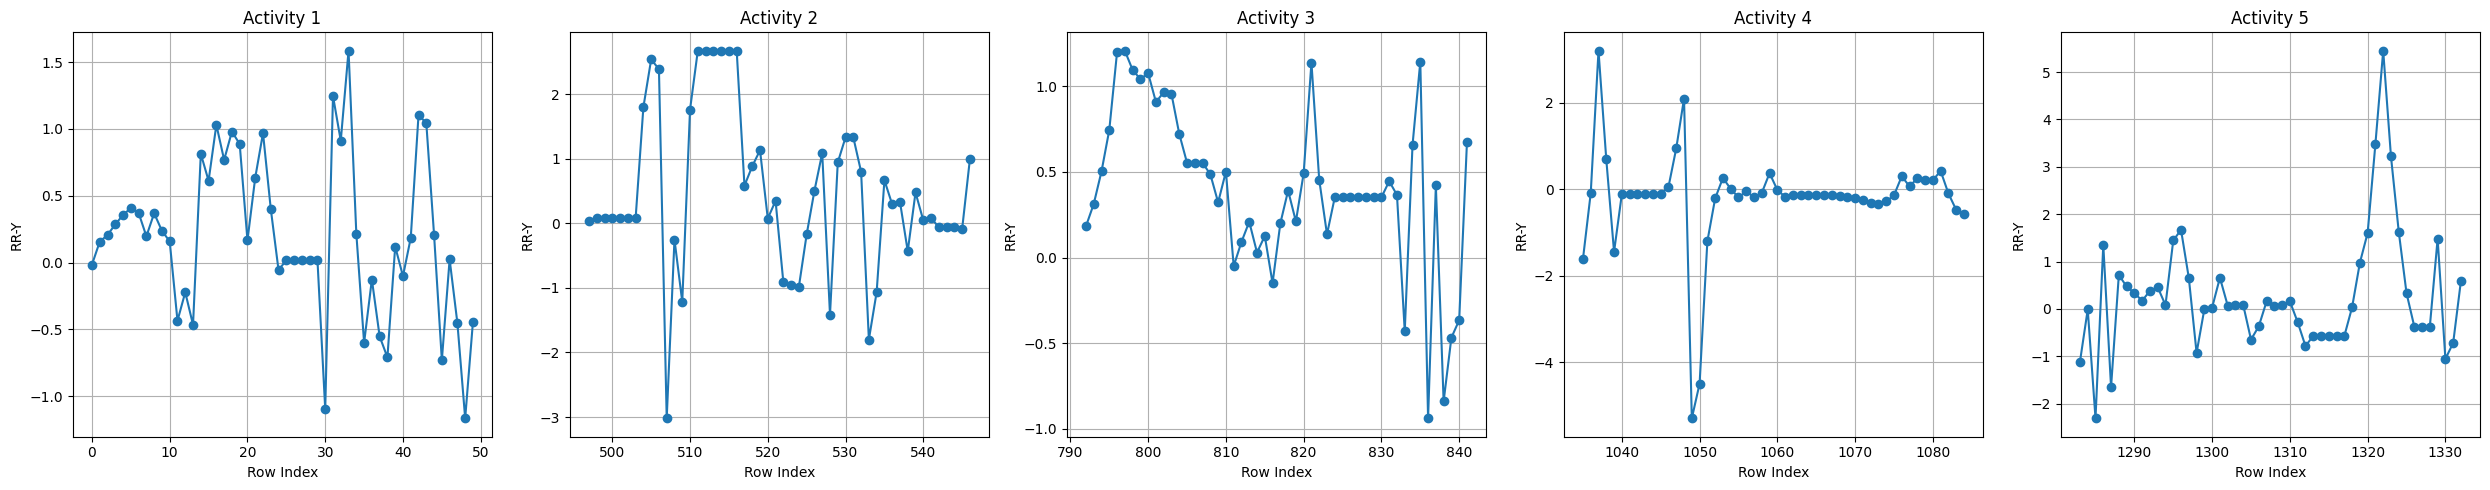

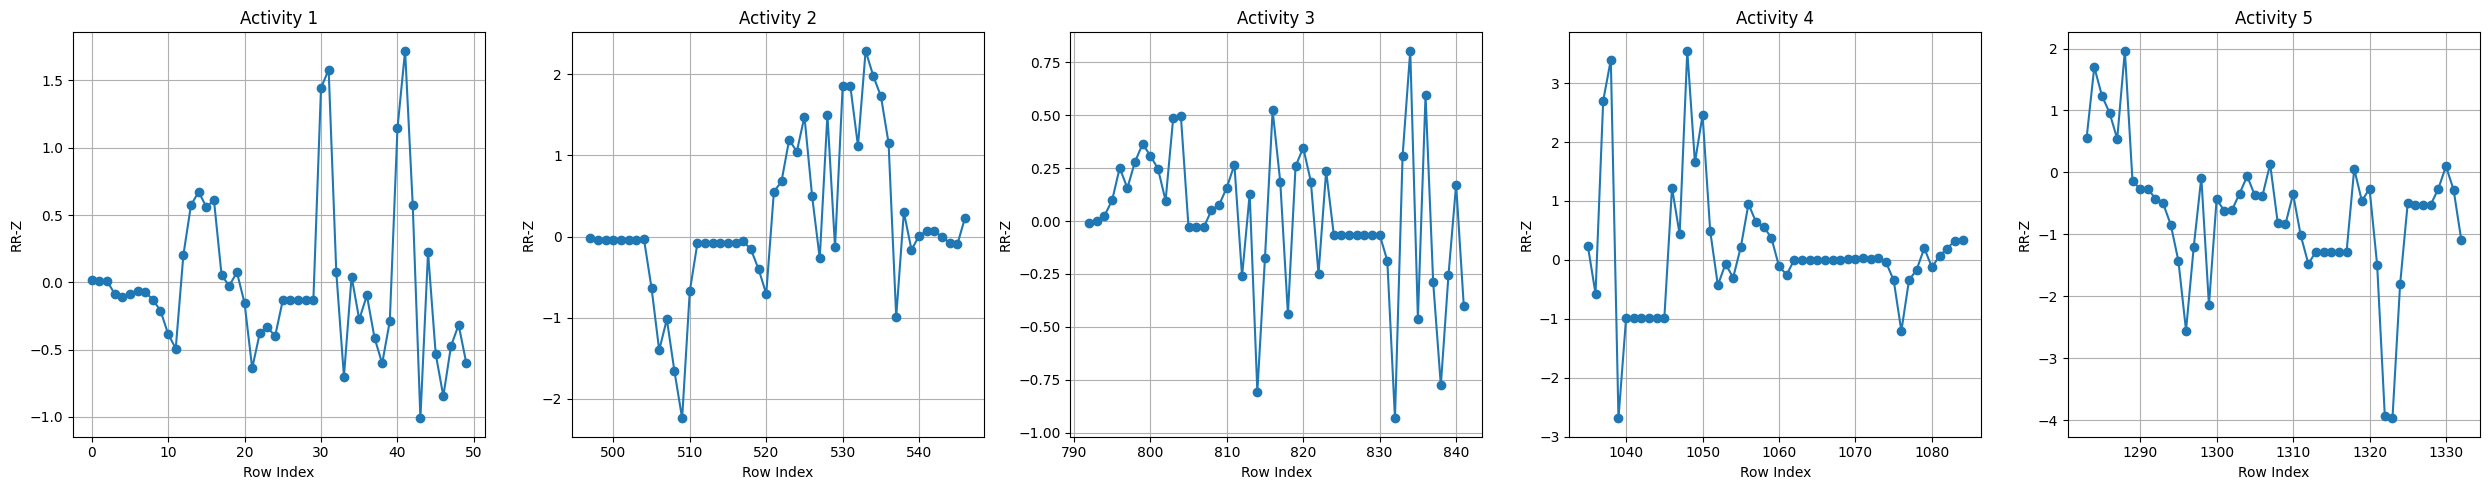

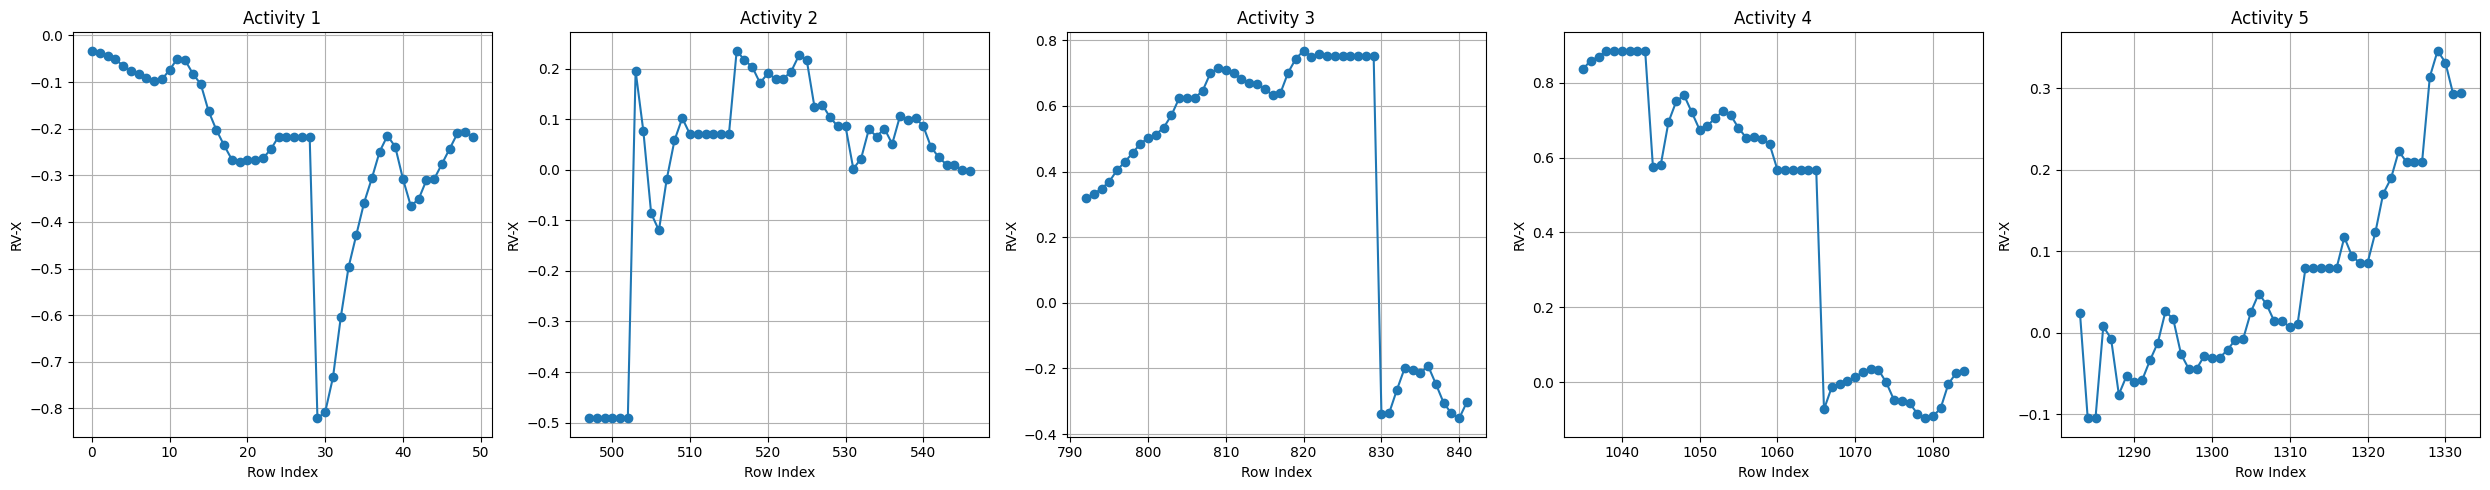

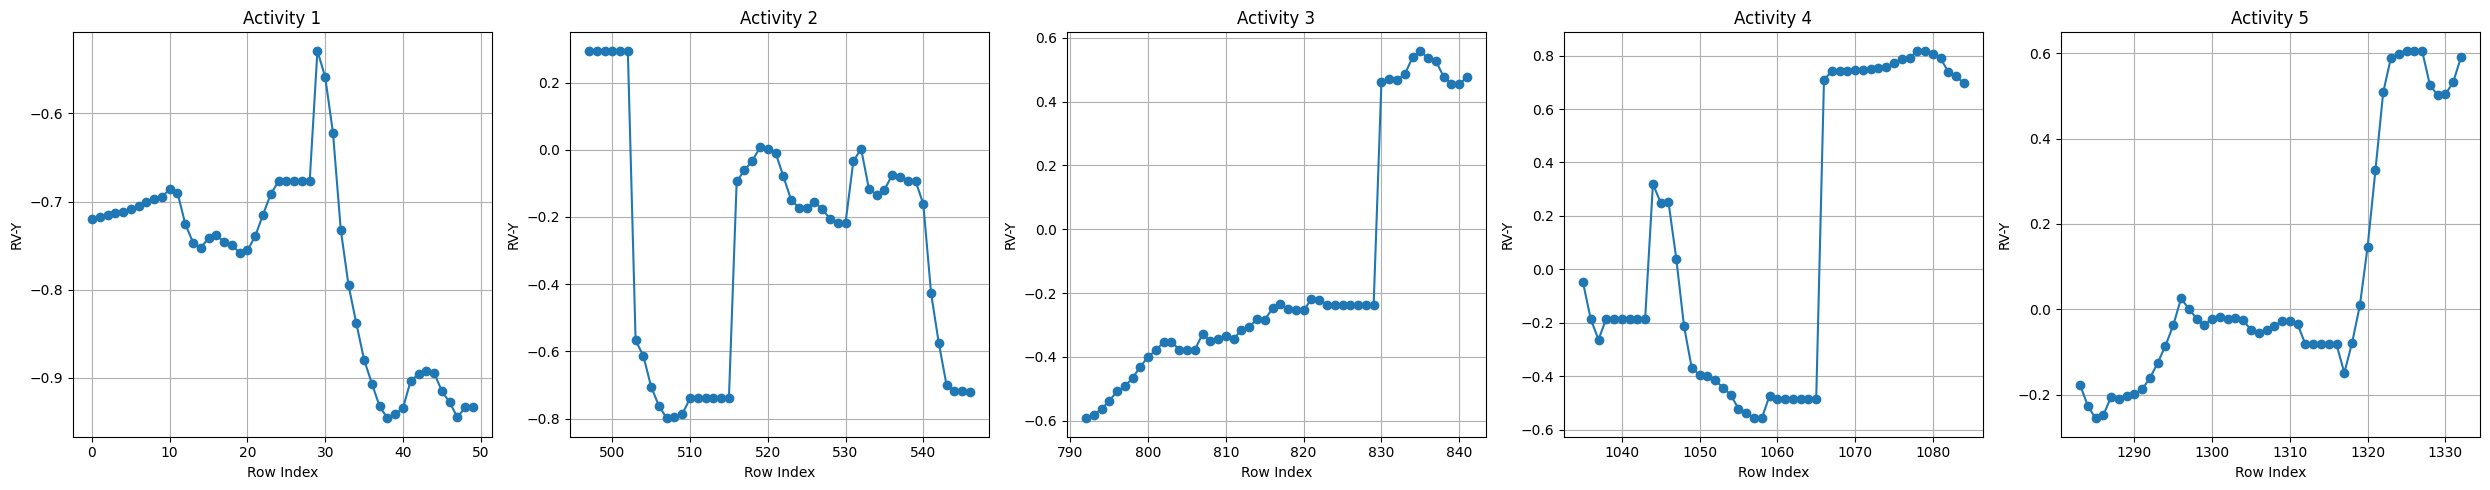

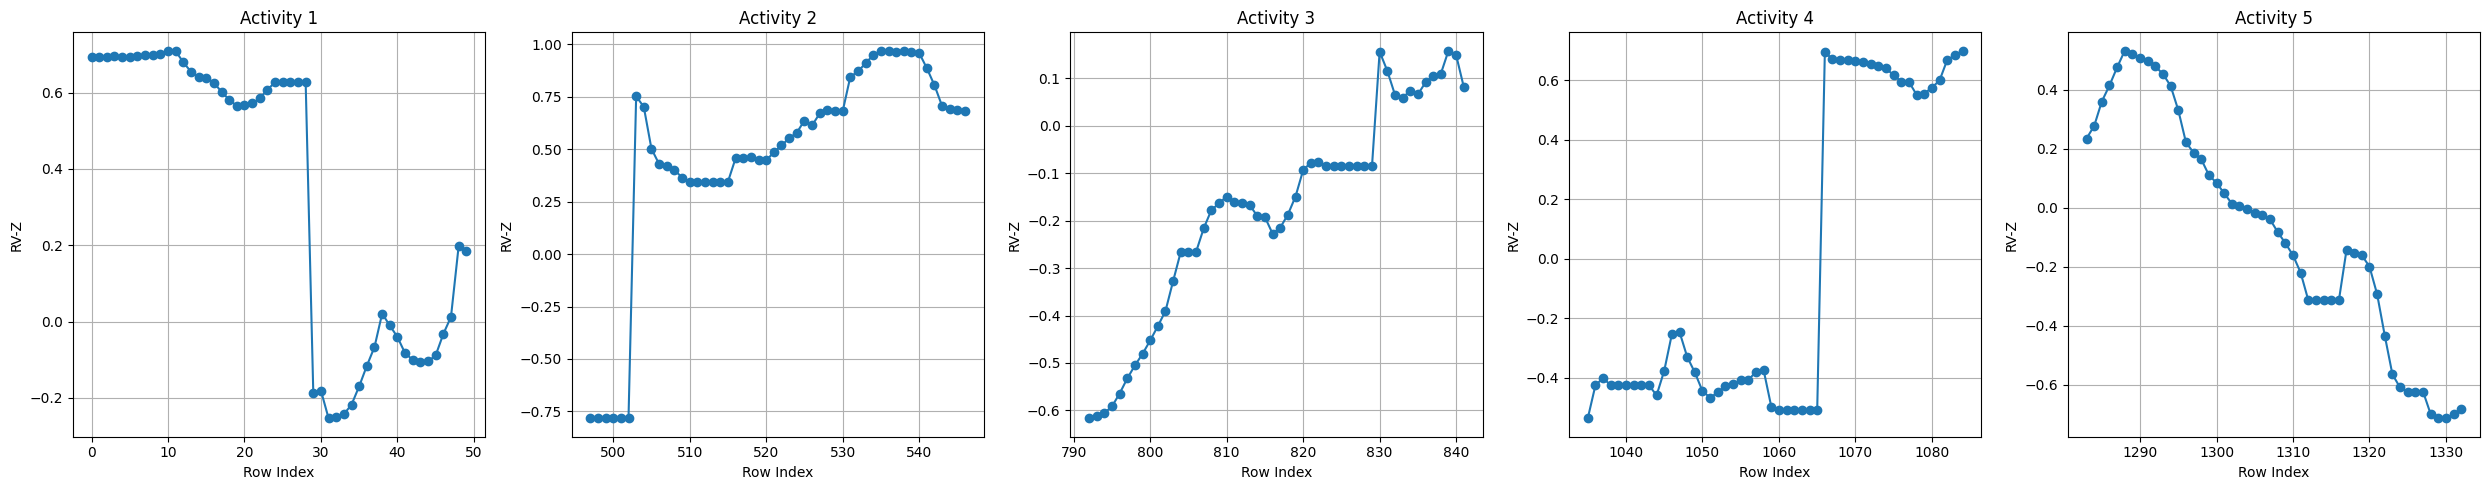

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pdf is your dataframe
# Get the unique activity ids
activity_ids = pdf['activity'].unique()
for col in plotty:
  # Initialize the subplot grid
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

  # Plot for each activity
  for i, activity_id in enumerate(activity_ids[:5]):  # Limit to first 5 activities
      activity_data = pdf[pdf['activity'] == activity_id].head(50)  # Get first 30 points for the activity
      axes[i].plot(activity_data[col], marker='o', linestyle='-')
      axes[i].set_title(f'Activity {activity_id}')
      axes[i].set_xlabel('Row Index')
      axes[i].set_ylabel(col)
      axes[i].grid(True)

  # Adjust layout
  plt.tight_layout()
  plt.show()



# Visualizing Quantiles for 5 users each feature to see when there motion was different from normal and in what amount

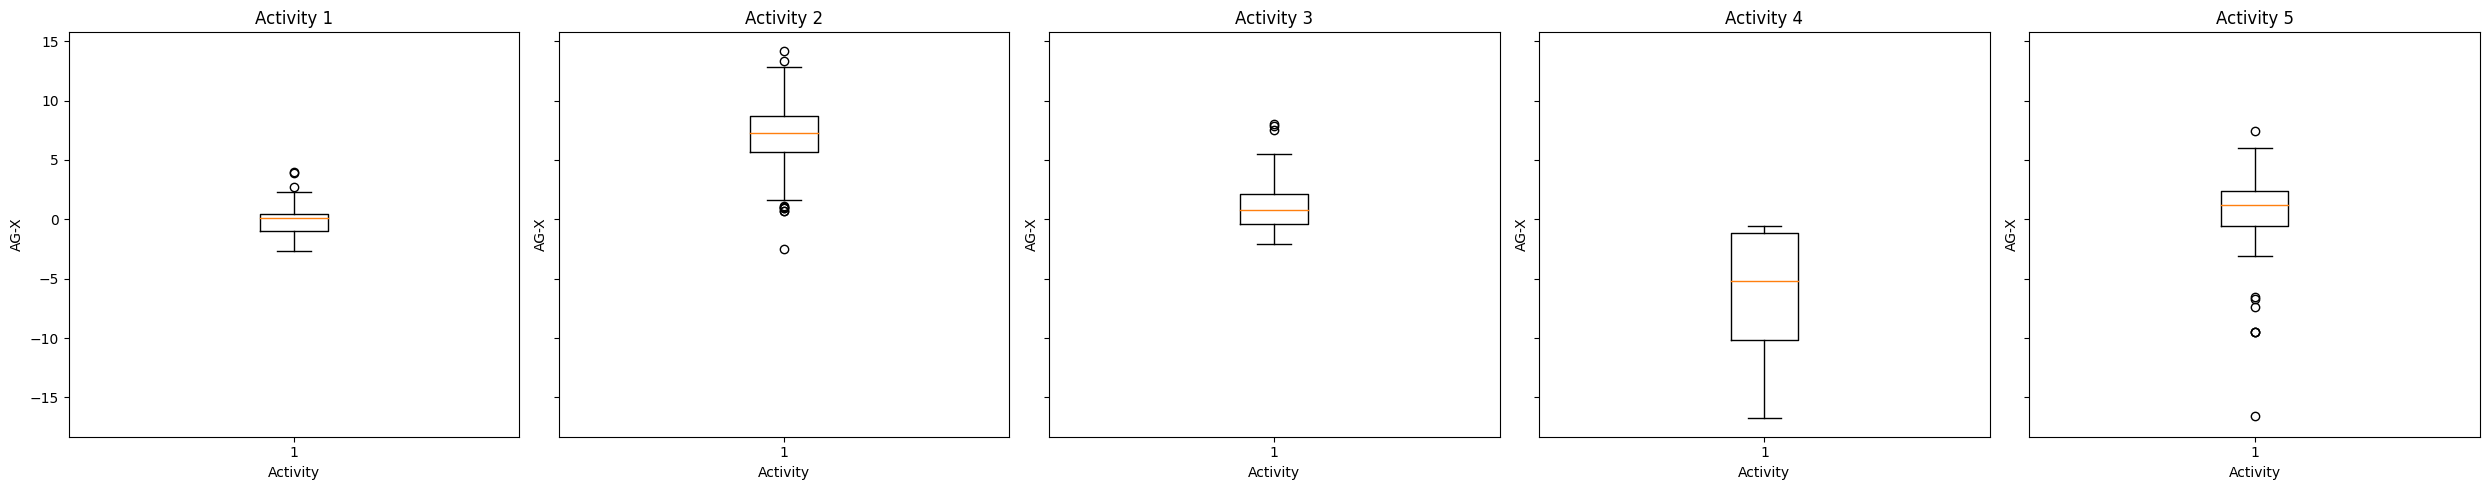

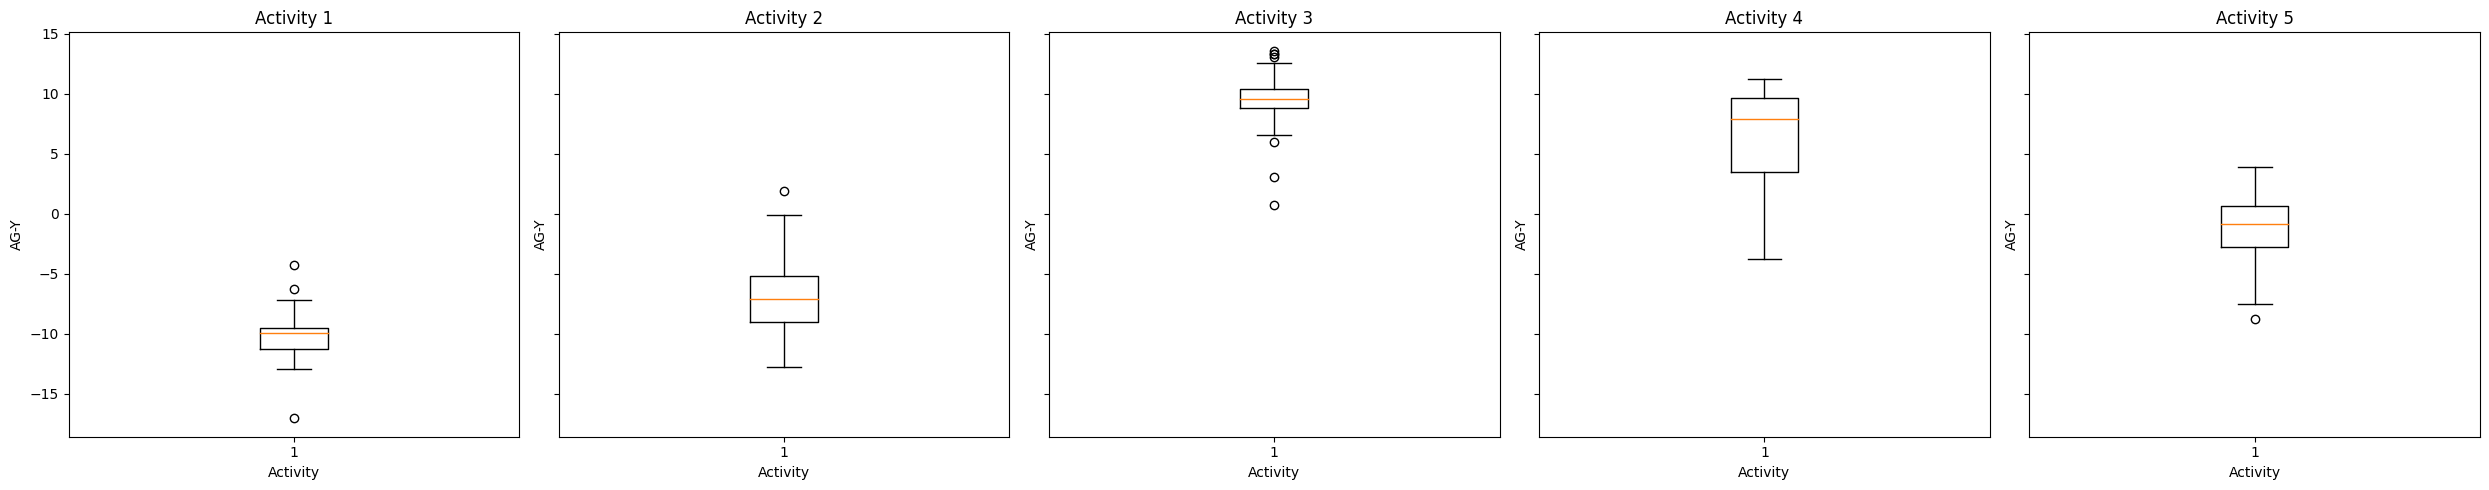

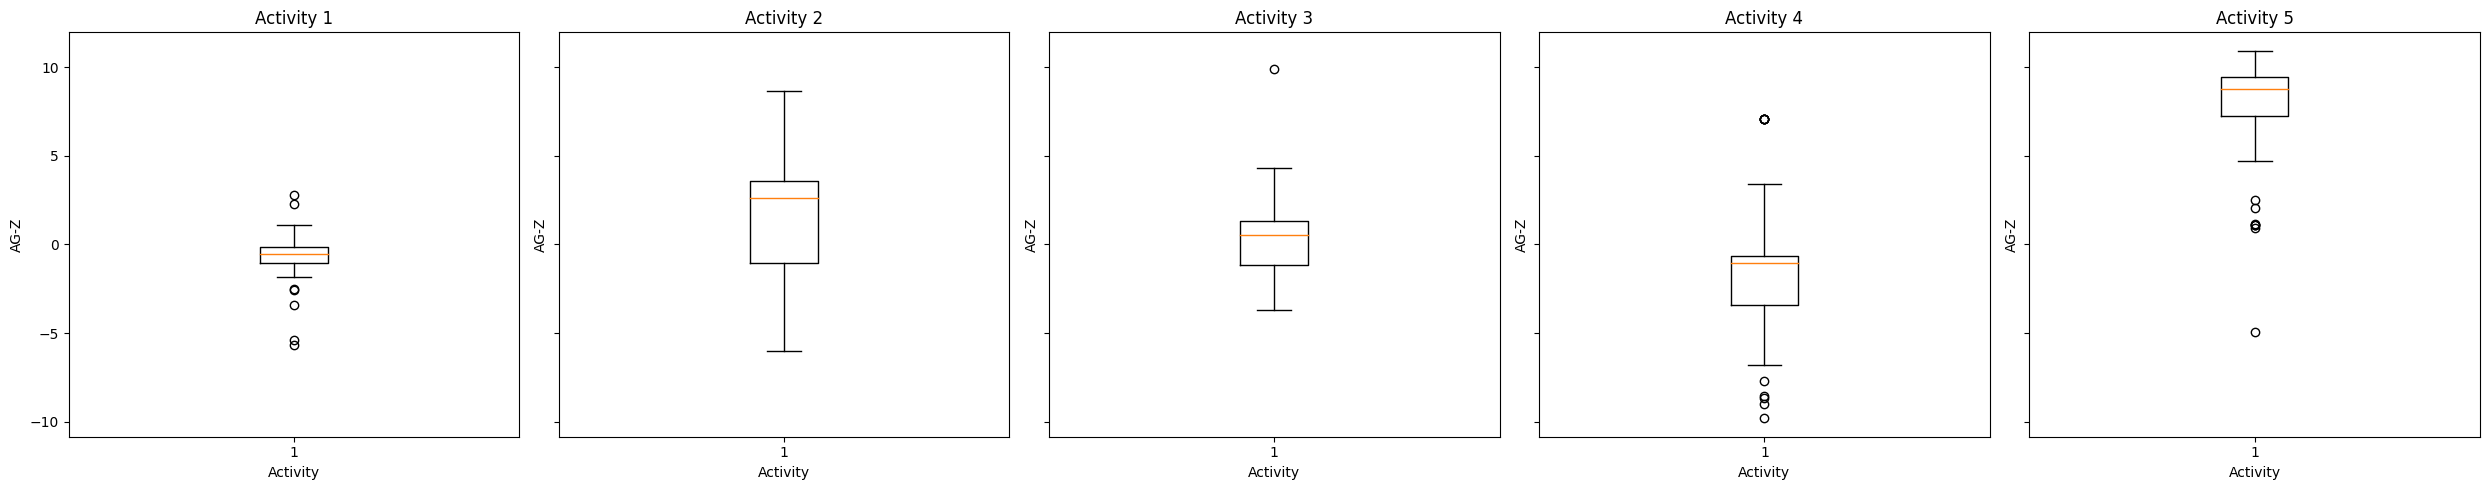

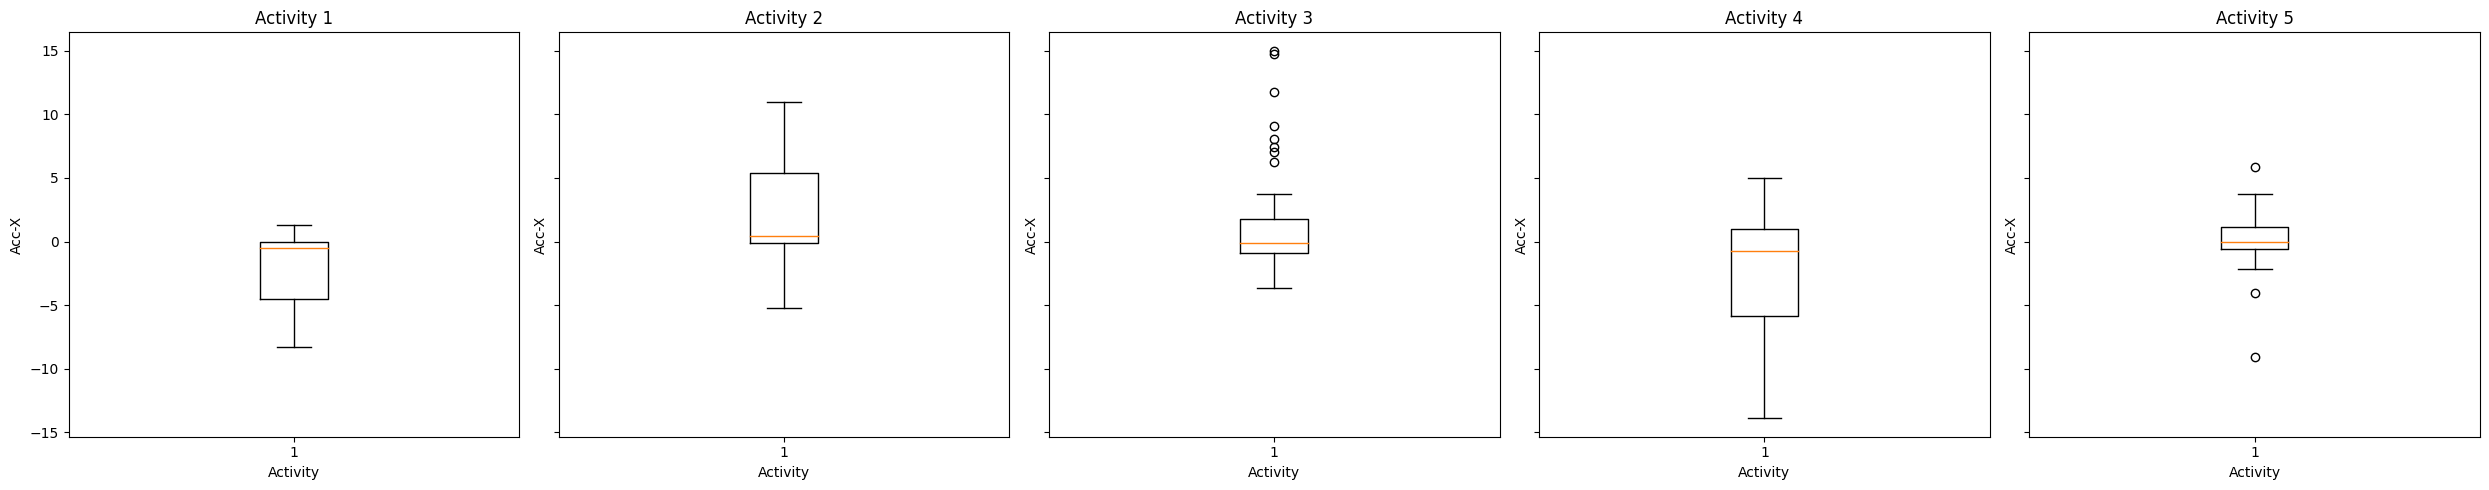

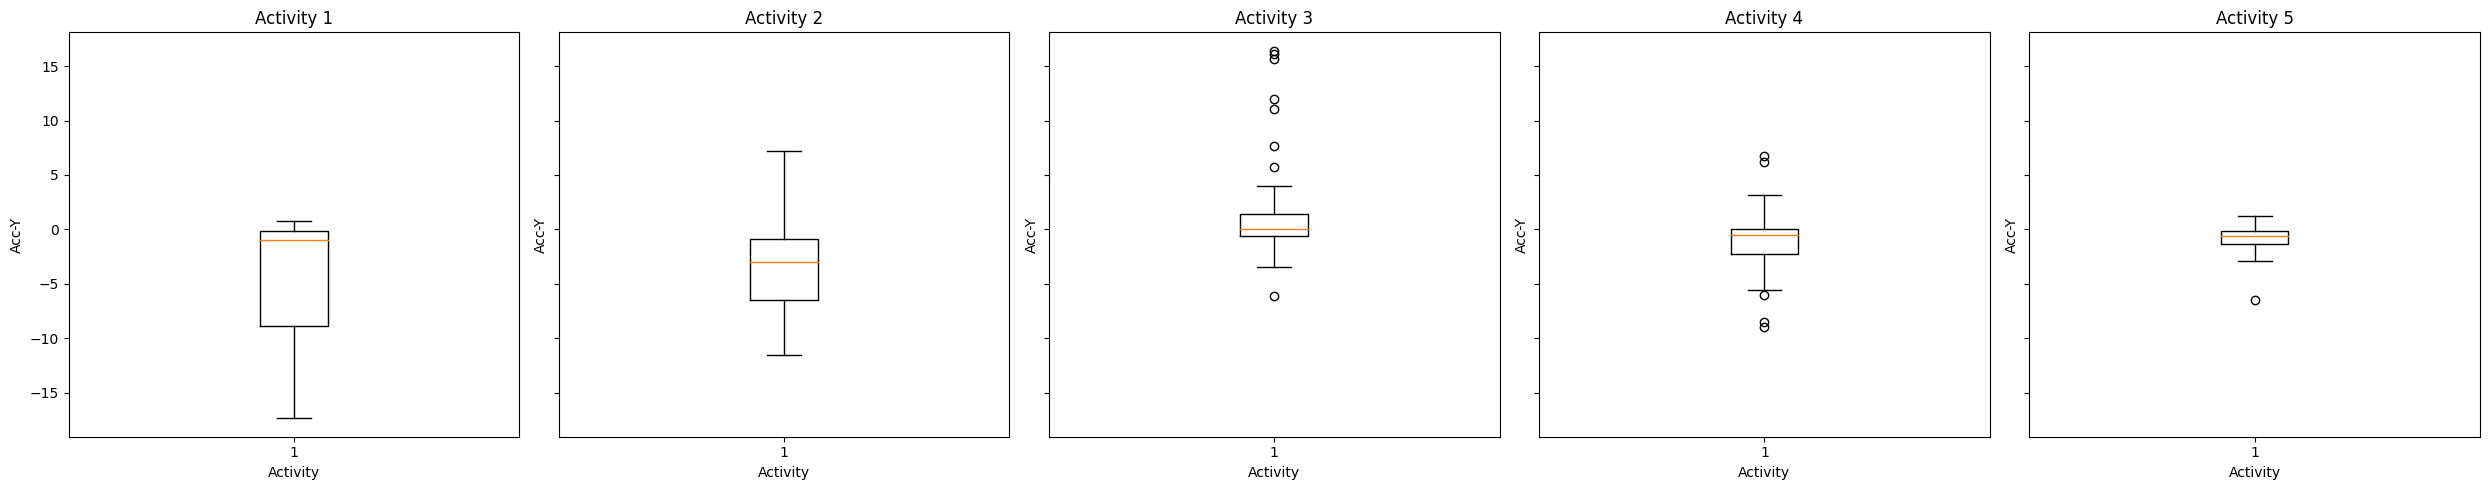

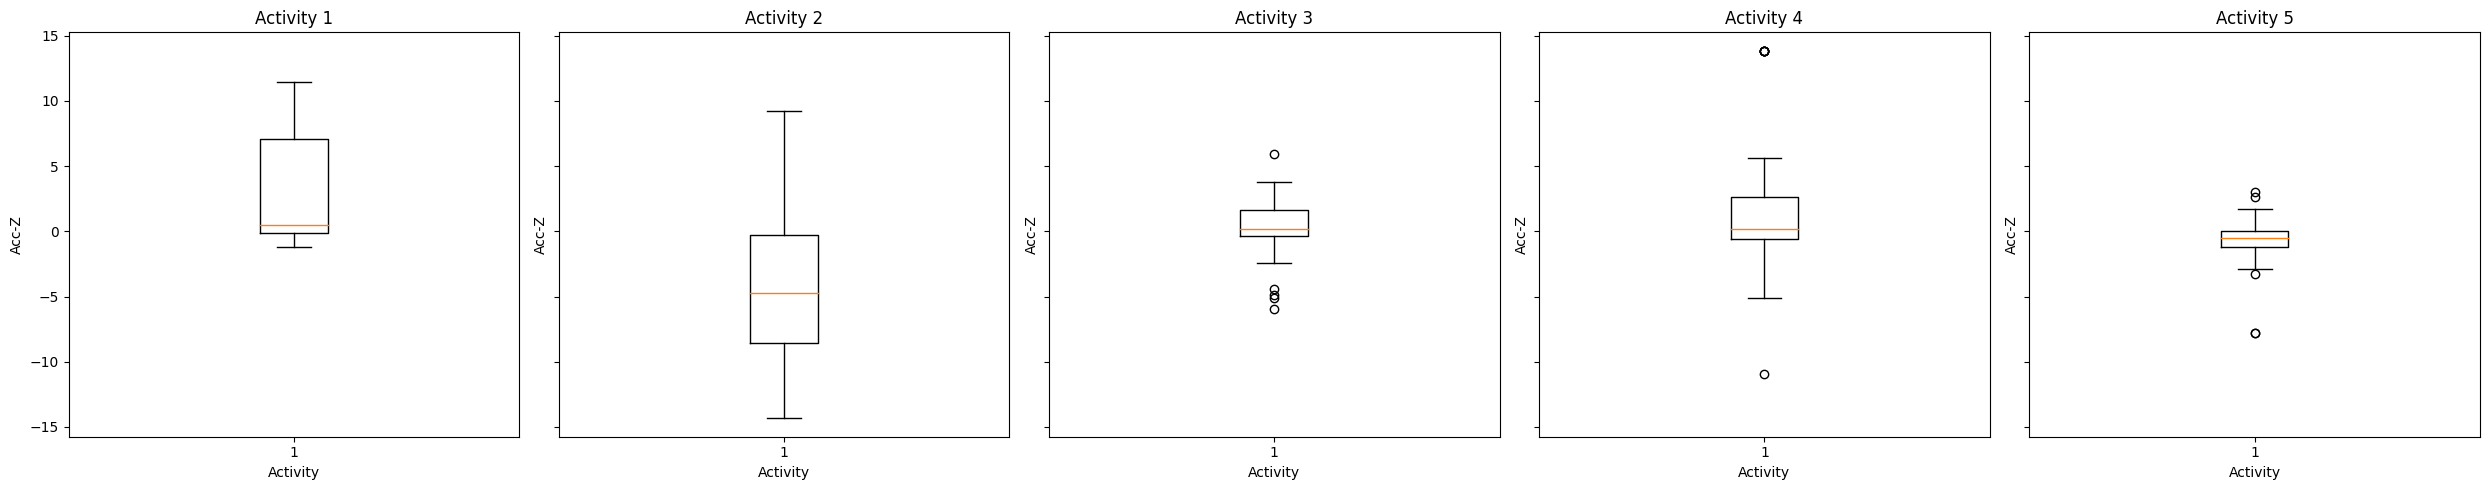

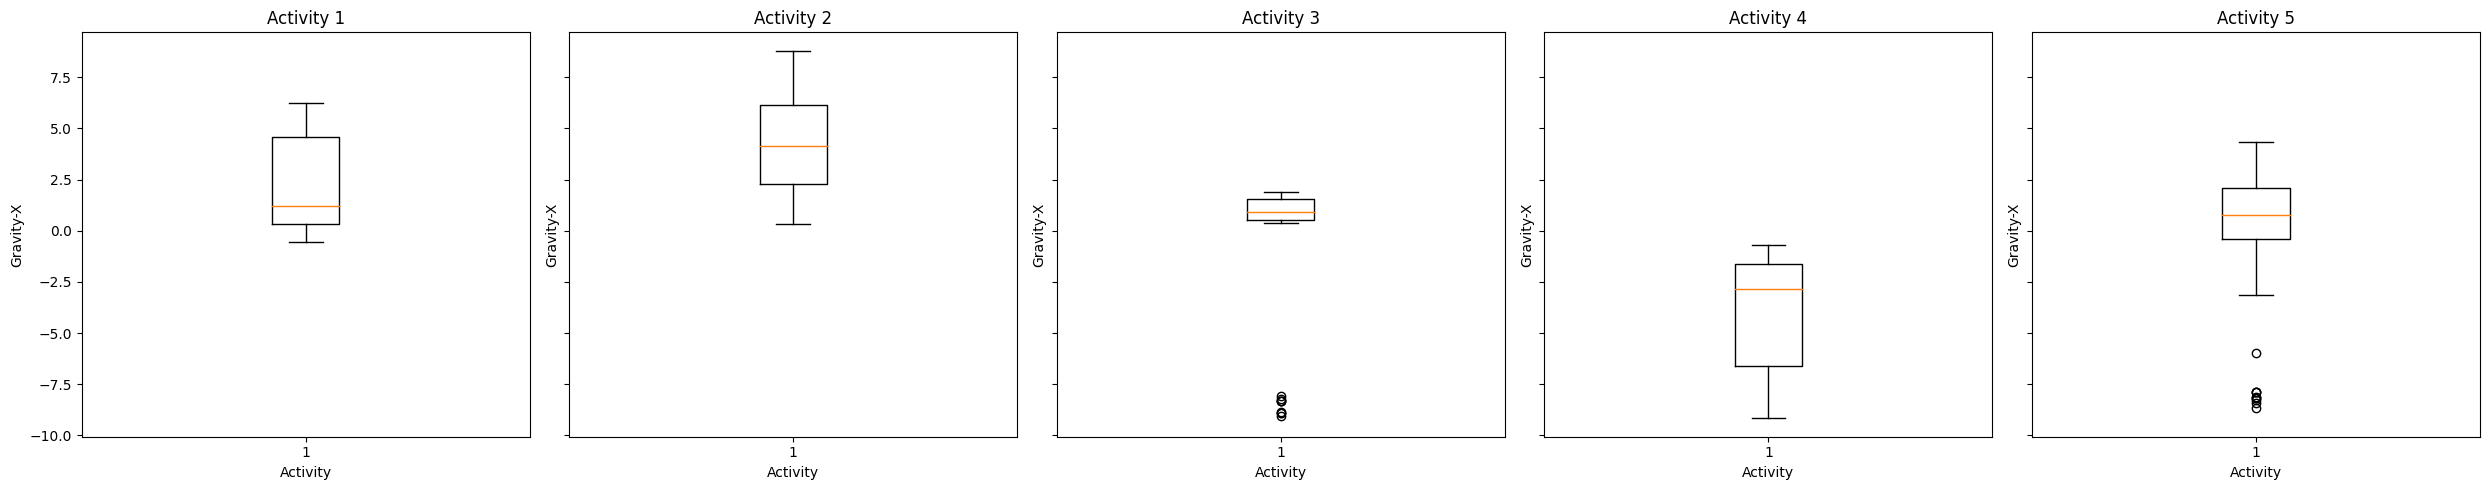

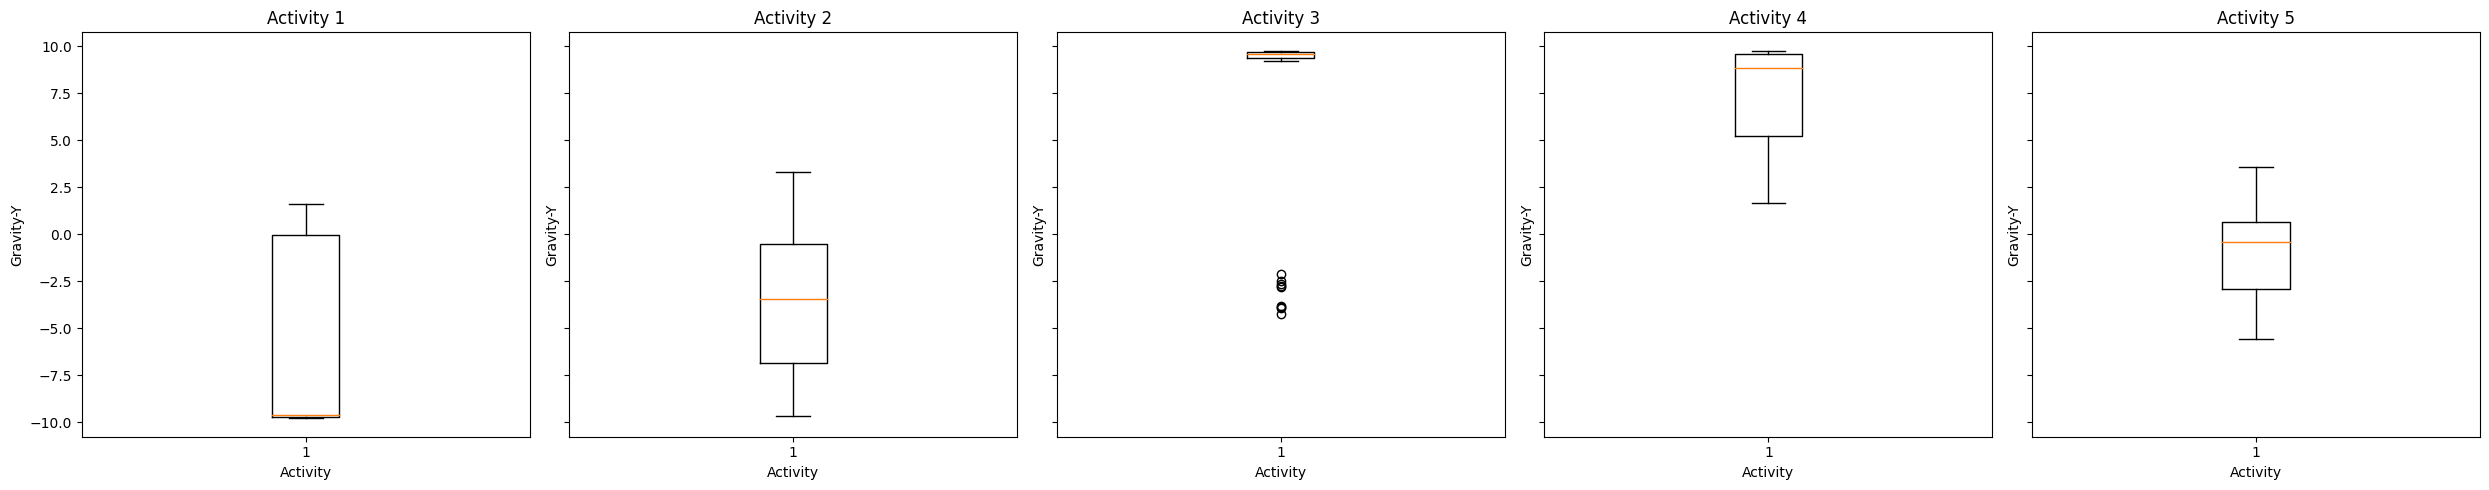

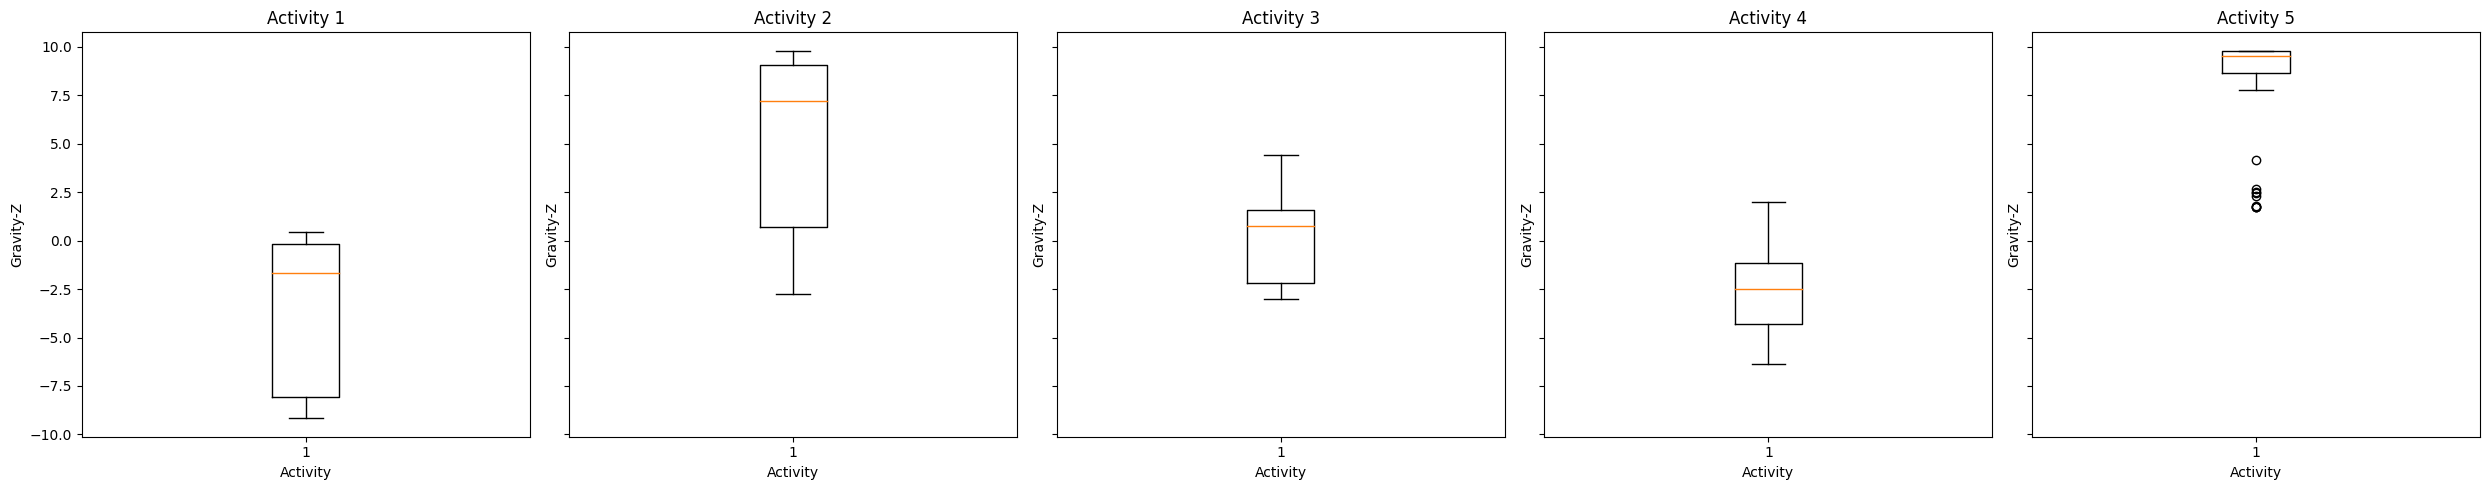

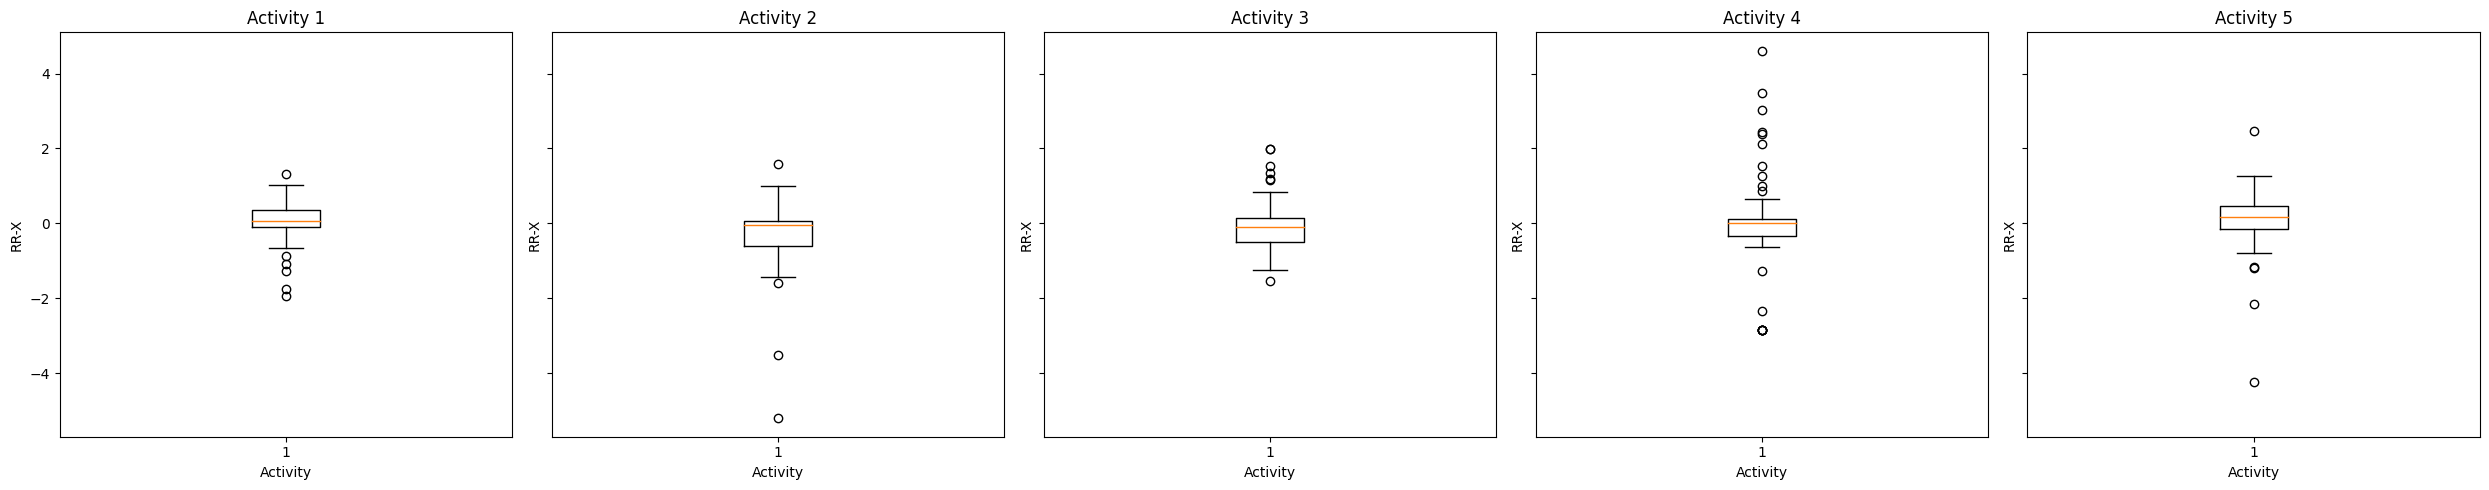

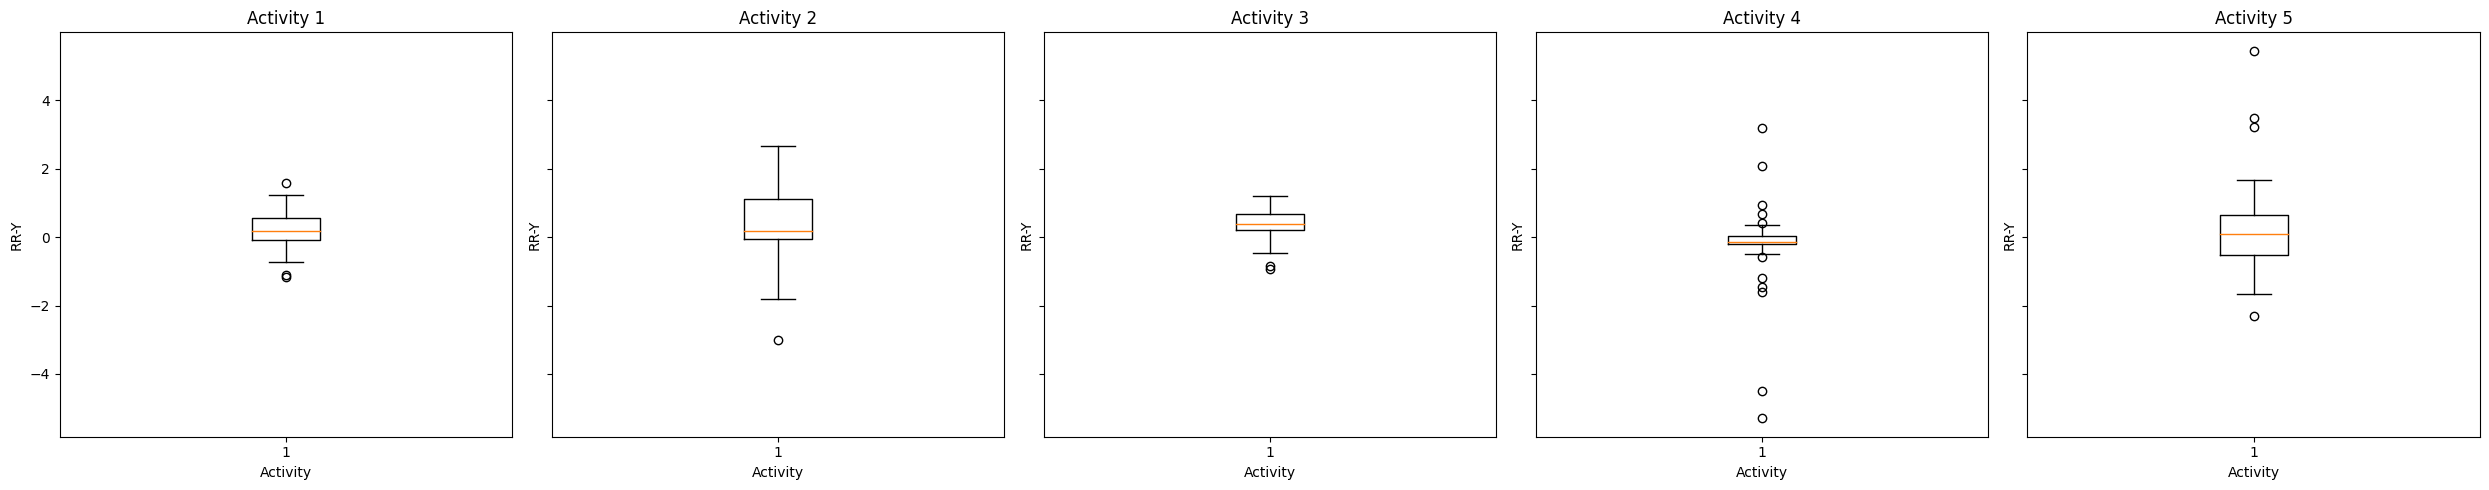

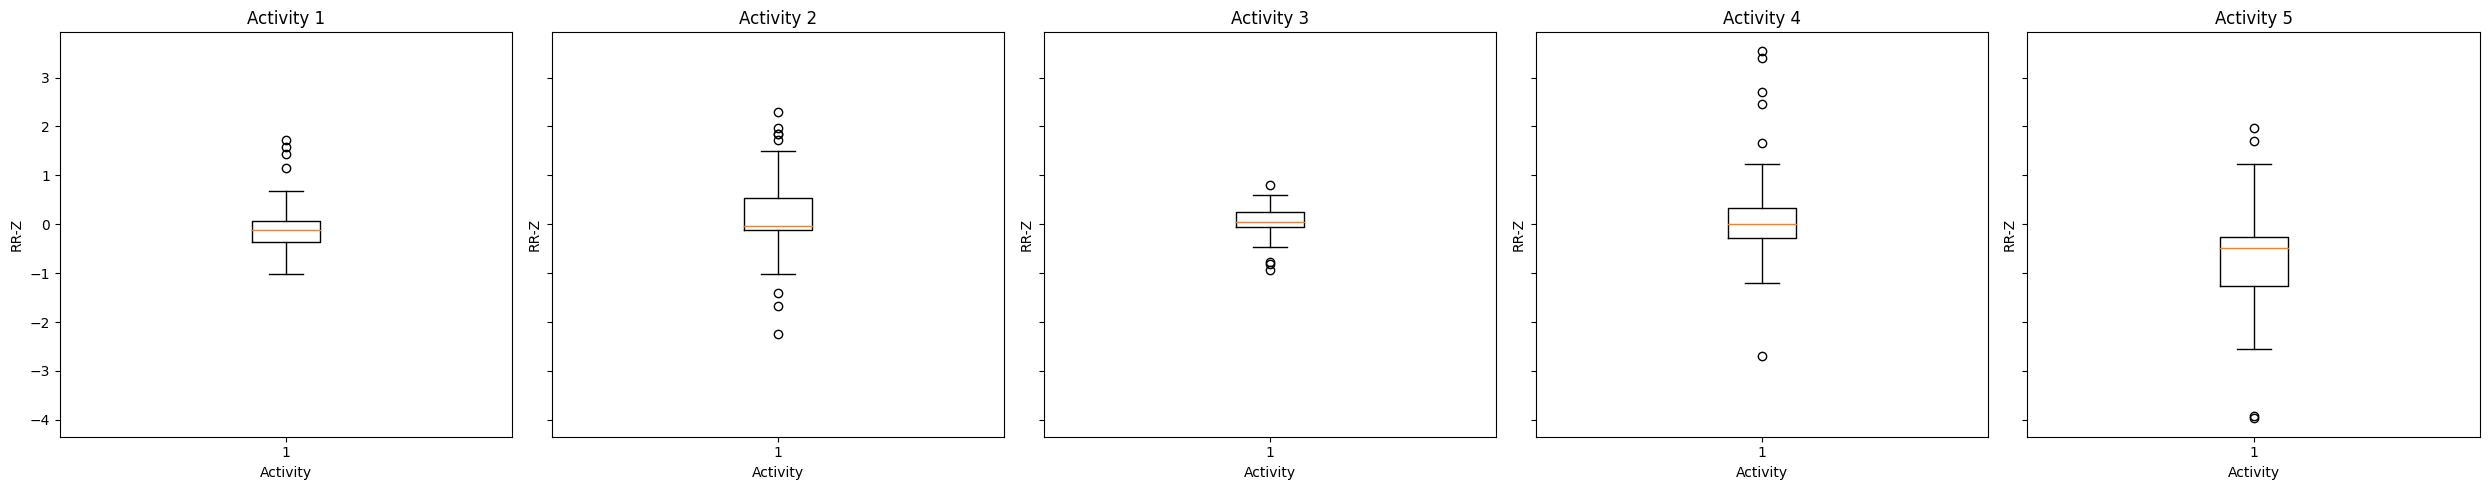

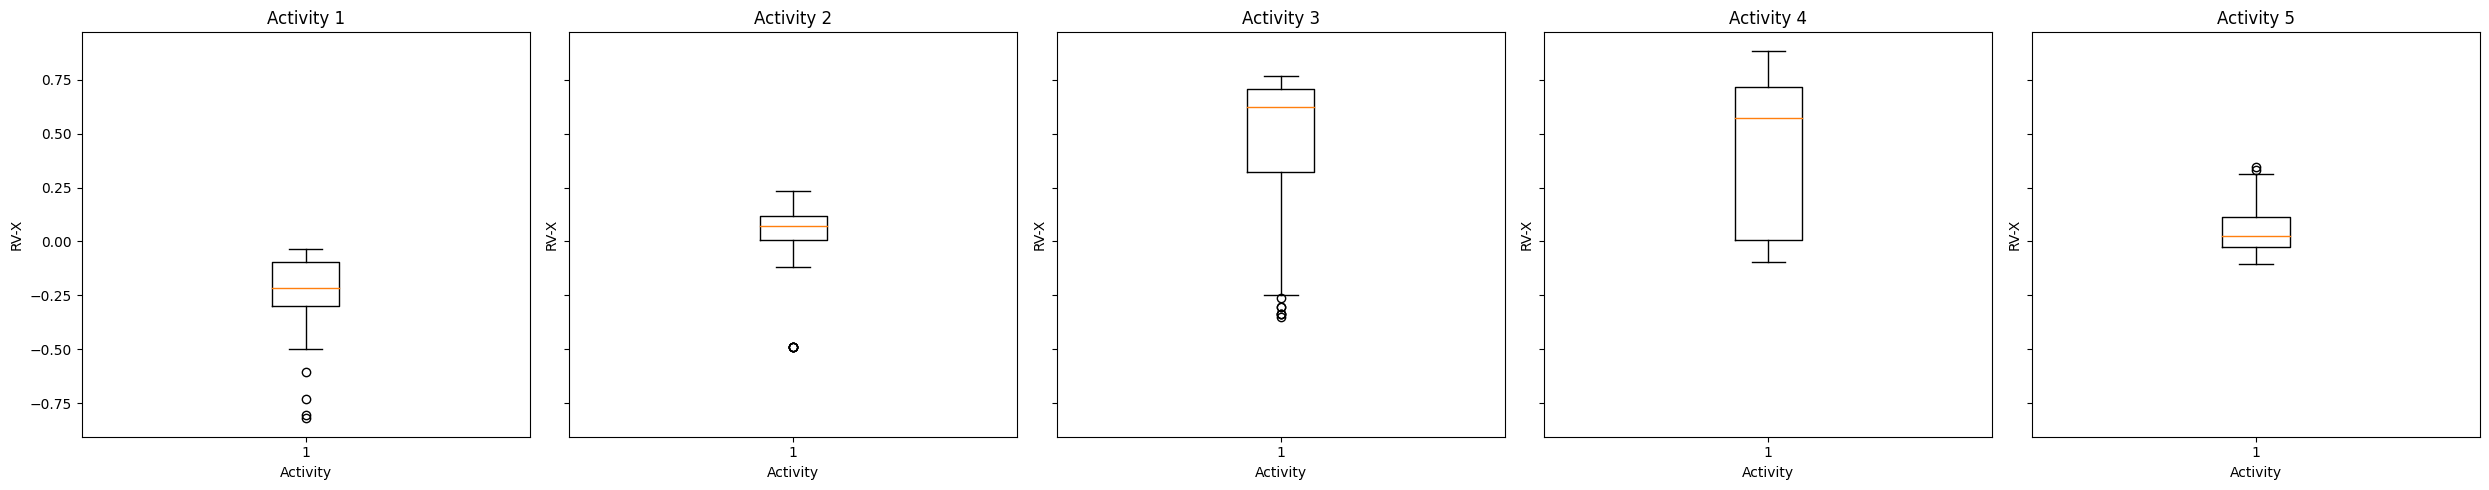

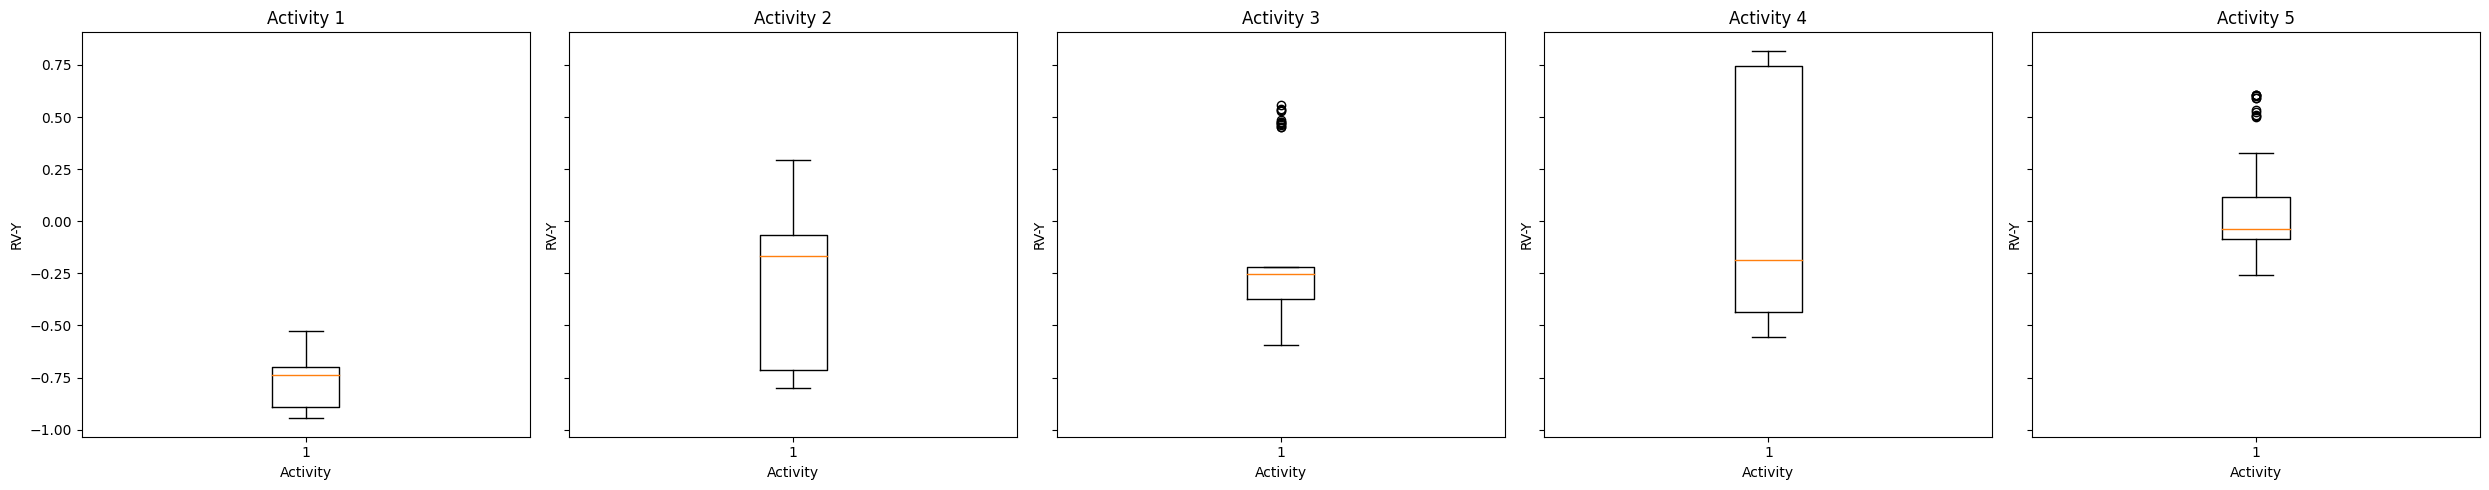

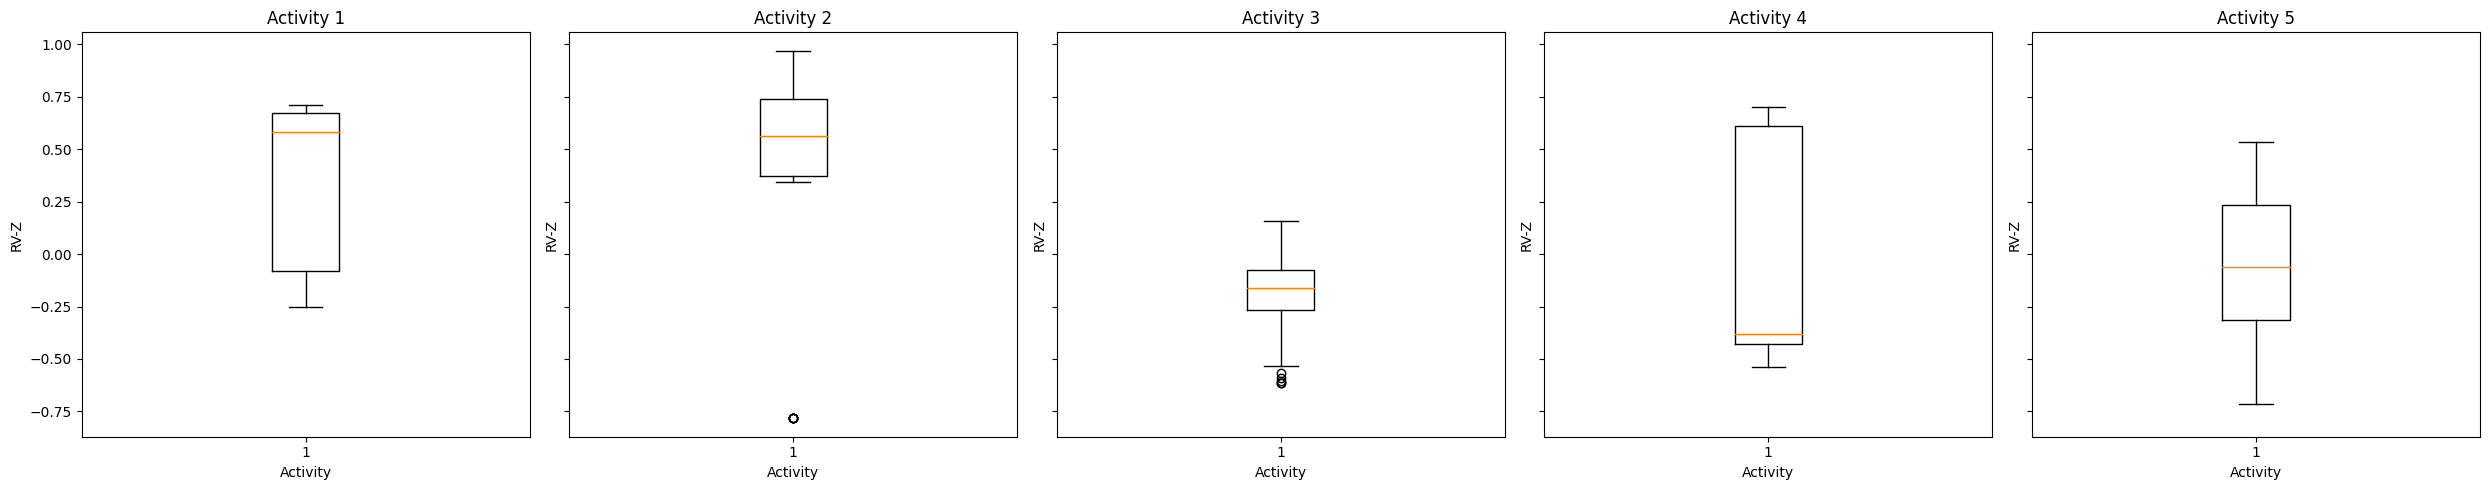

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pdf is your dataframe
# Get the unique activity ids
activity_ids = pdf['activity'].unique()


for col in plotty:
    # Initialize the subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5), sharey=True)

    # Plot for each activity
    for i, activity_id in enumerate(activity_ids[:5]):  # Limit to first 5 activities
        activity_data = pdf[pdf['activity'] == activity_id].head(50)  # Get first 50 points for the activity
        axes[i].boxplot(activity_data[col])
        axes[i].set_title(f'Activity {activity_id}')
        axes[i].set_xlabel('Activity')
        axes[i].set_ylabel(col)

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Checking whether any of sensors recording for any of user does follow Guassian Distribution or not

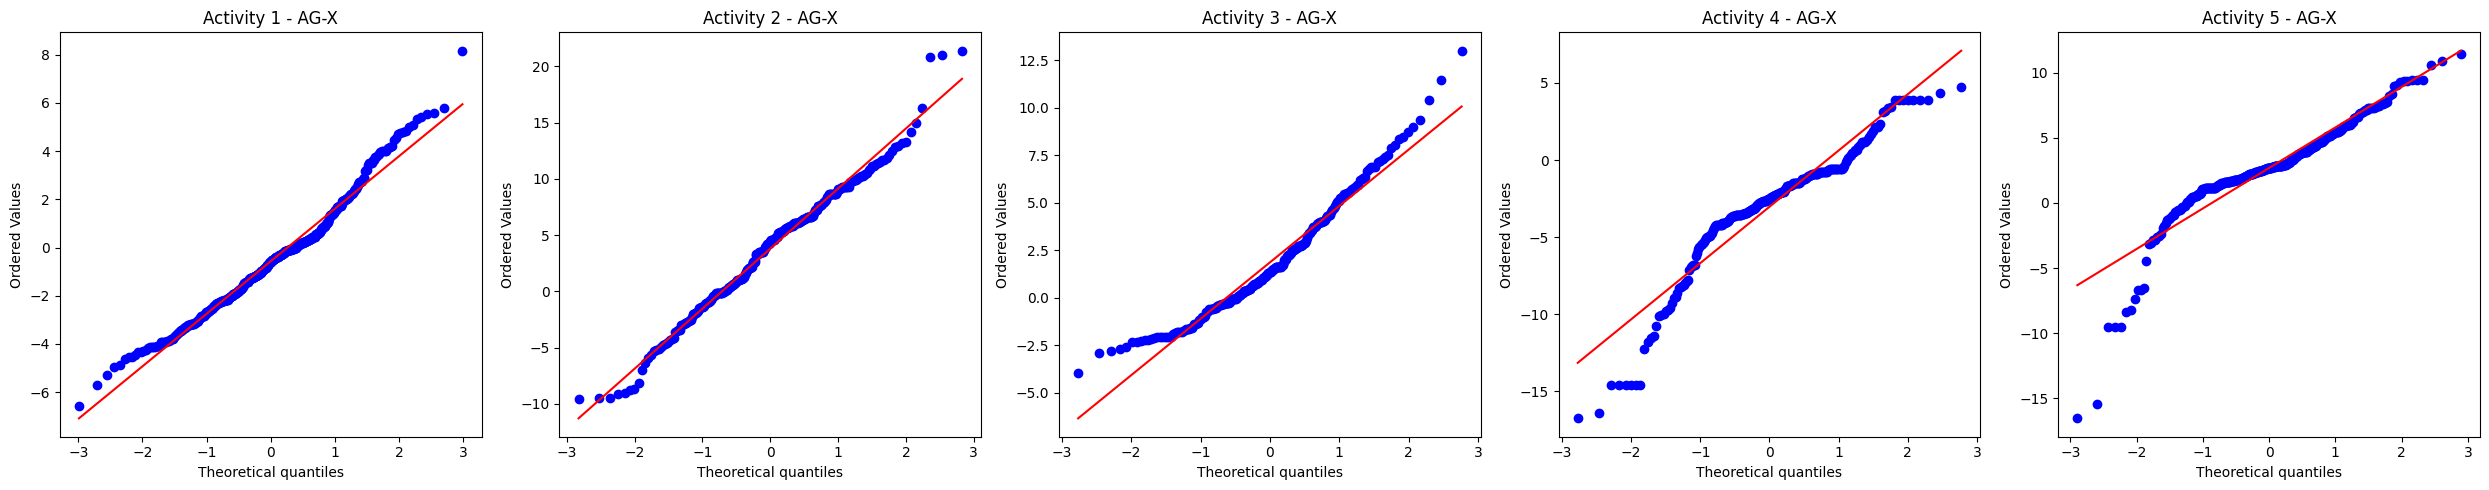

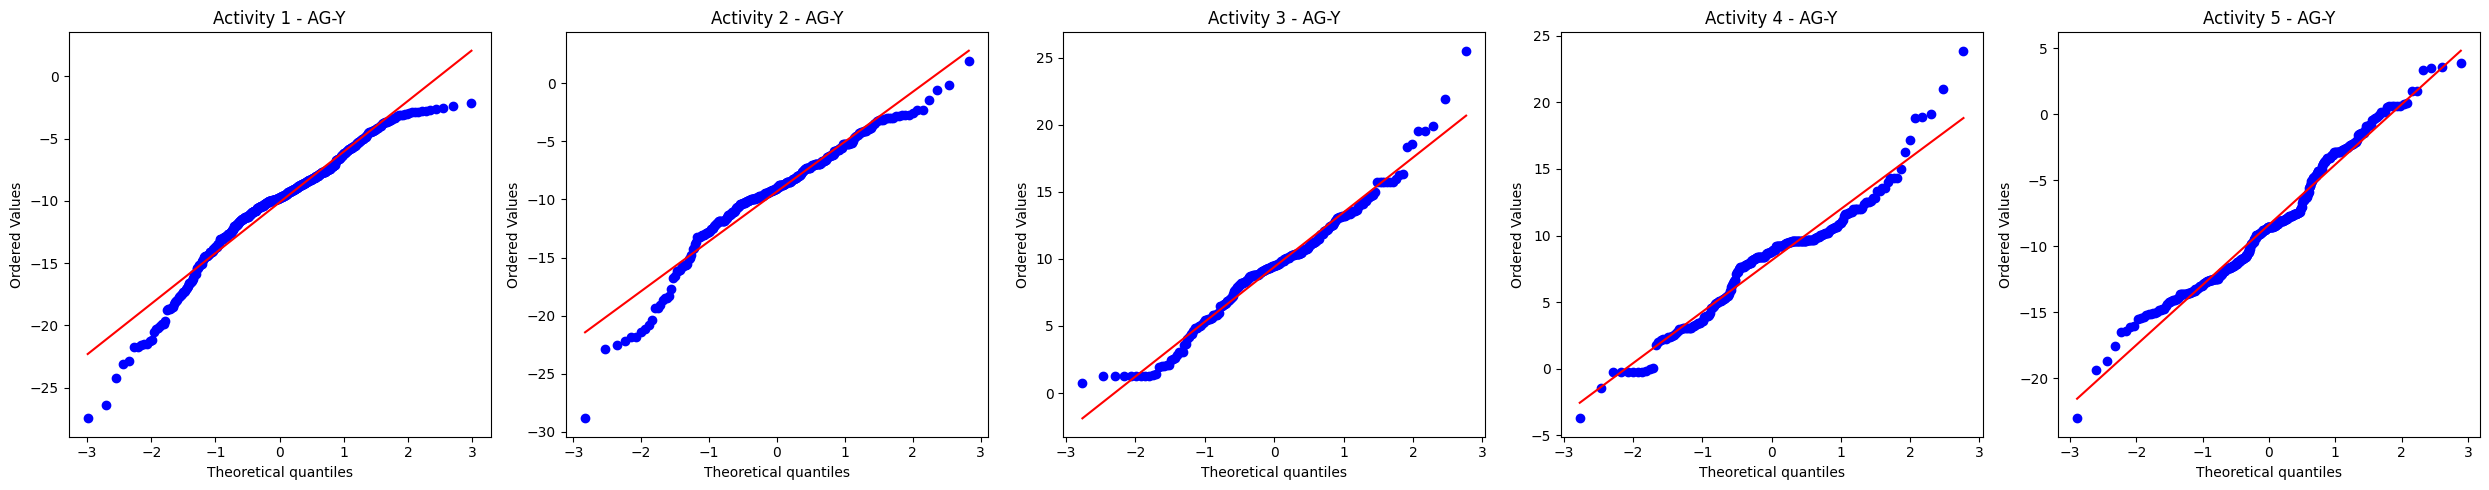

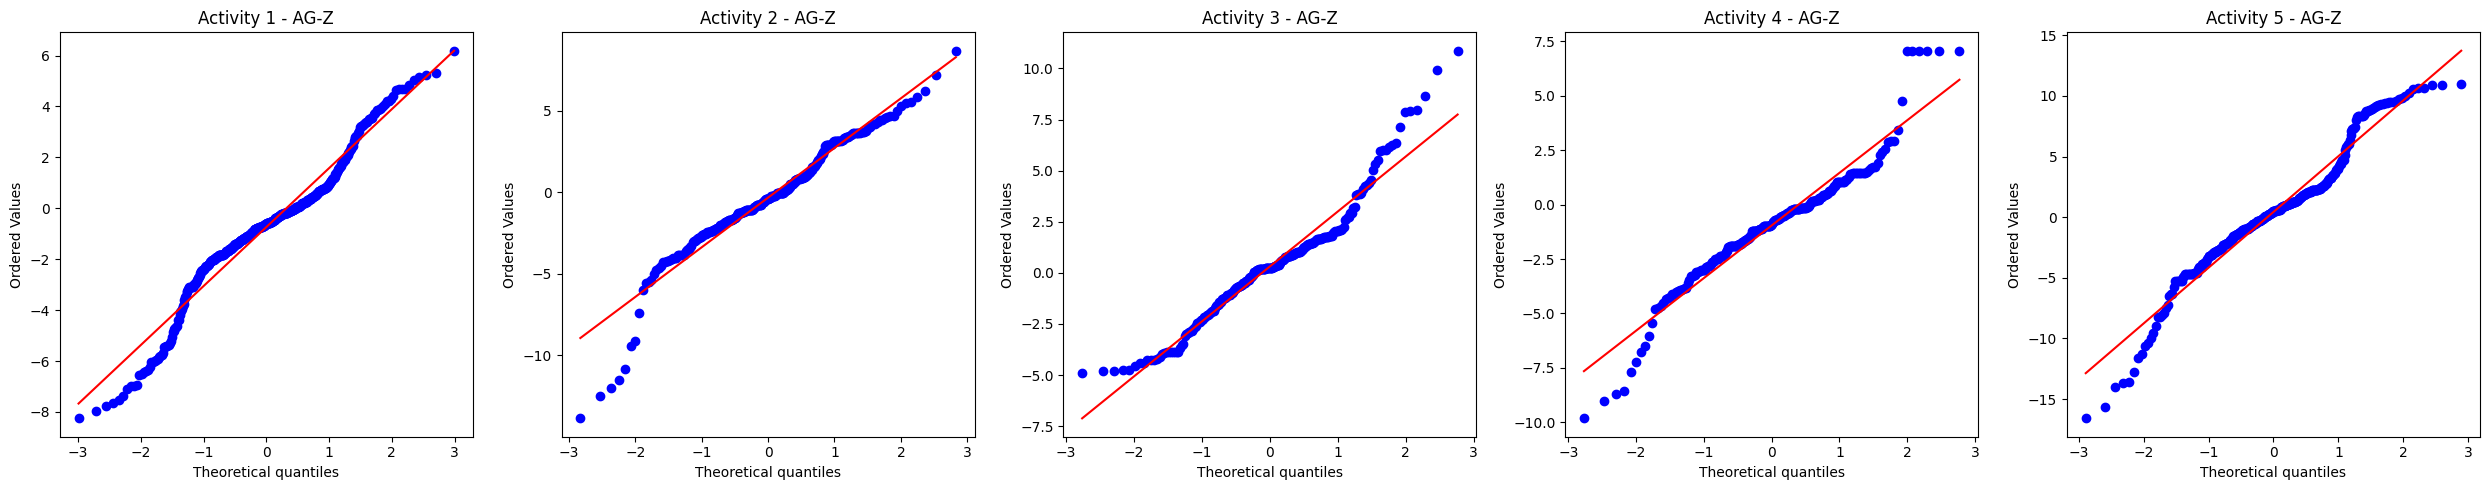

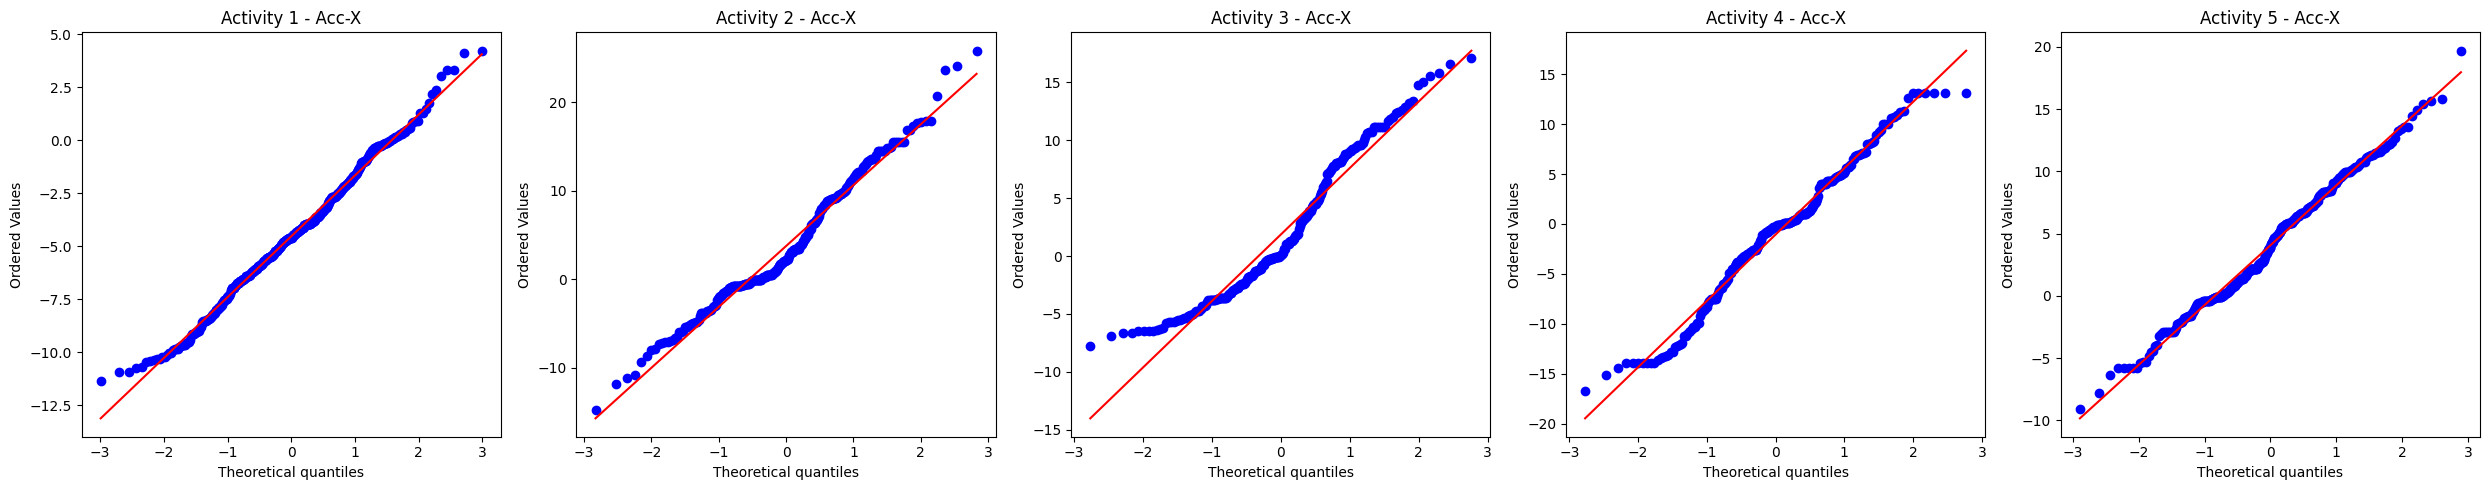

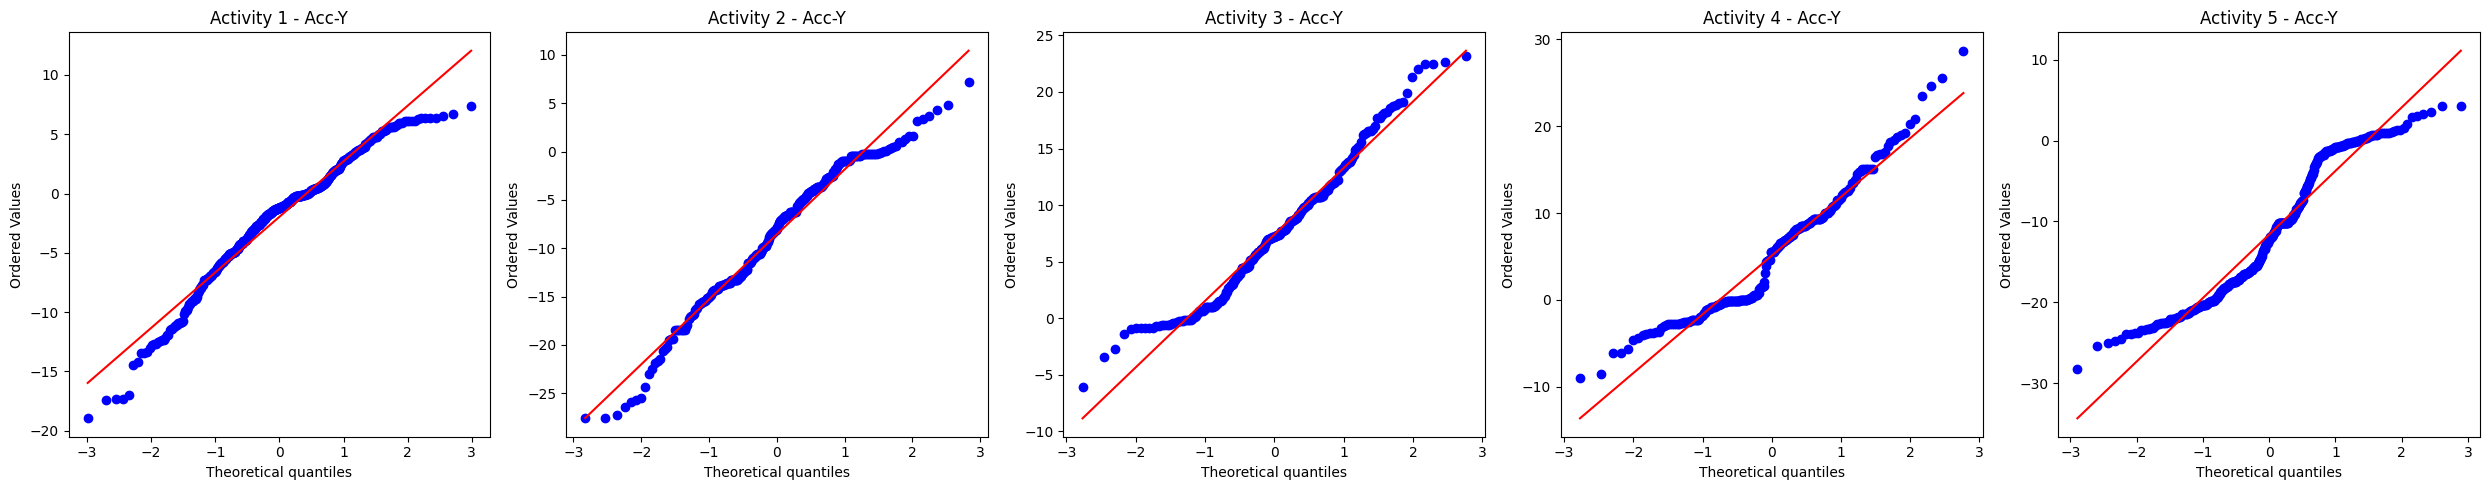

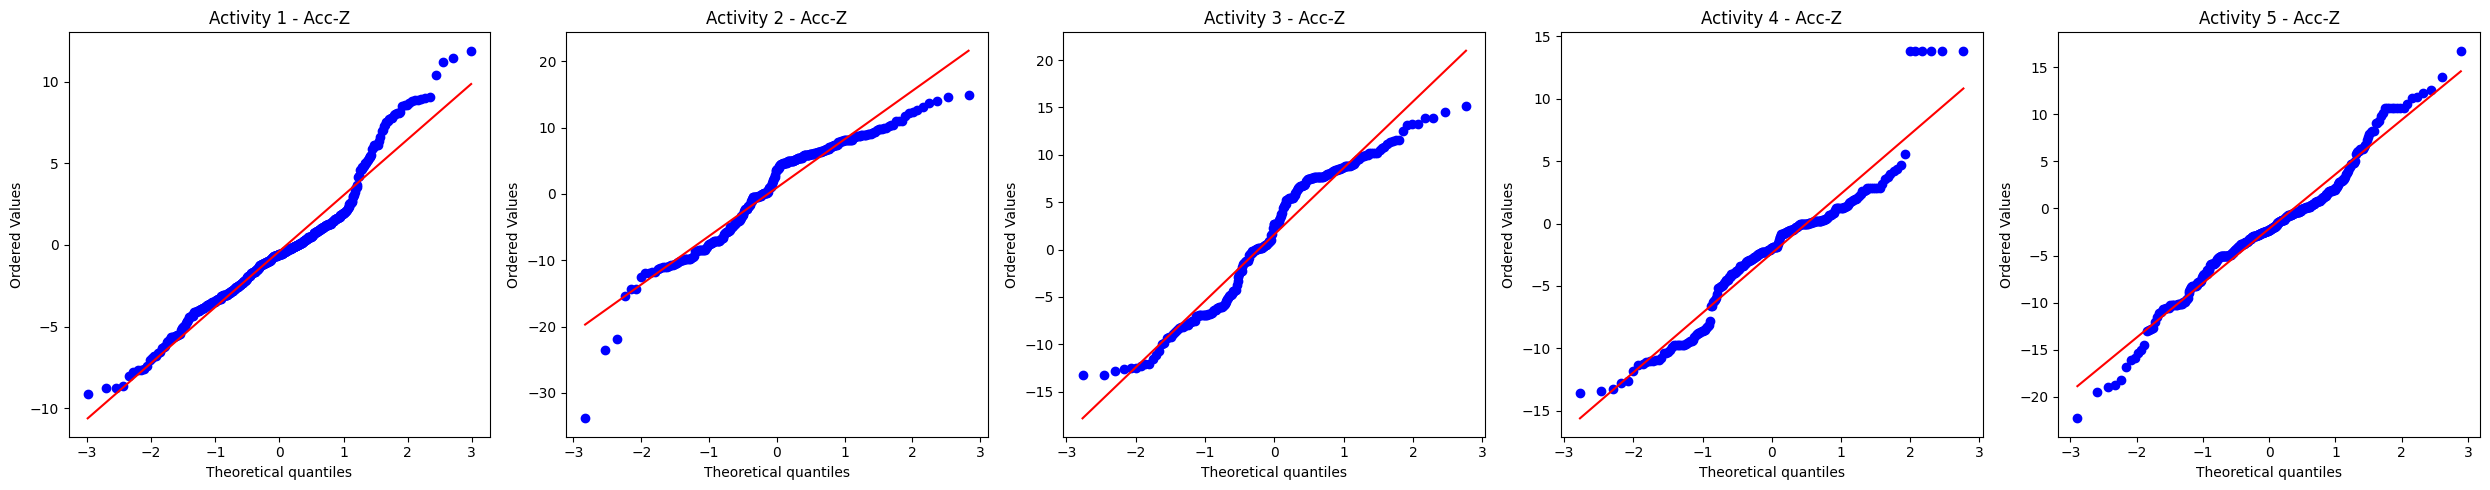

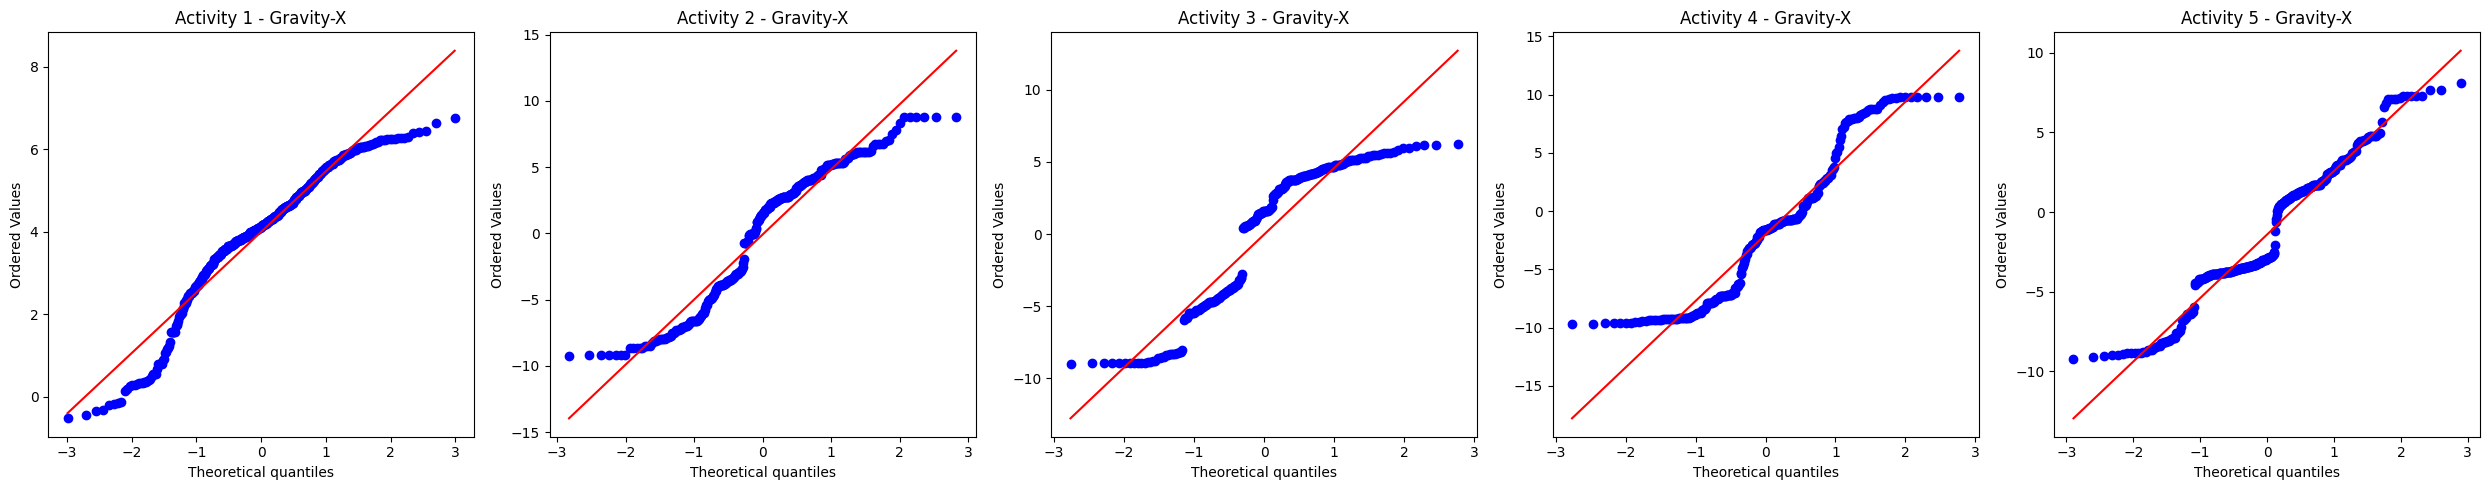

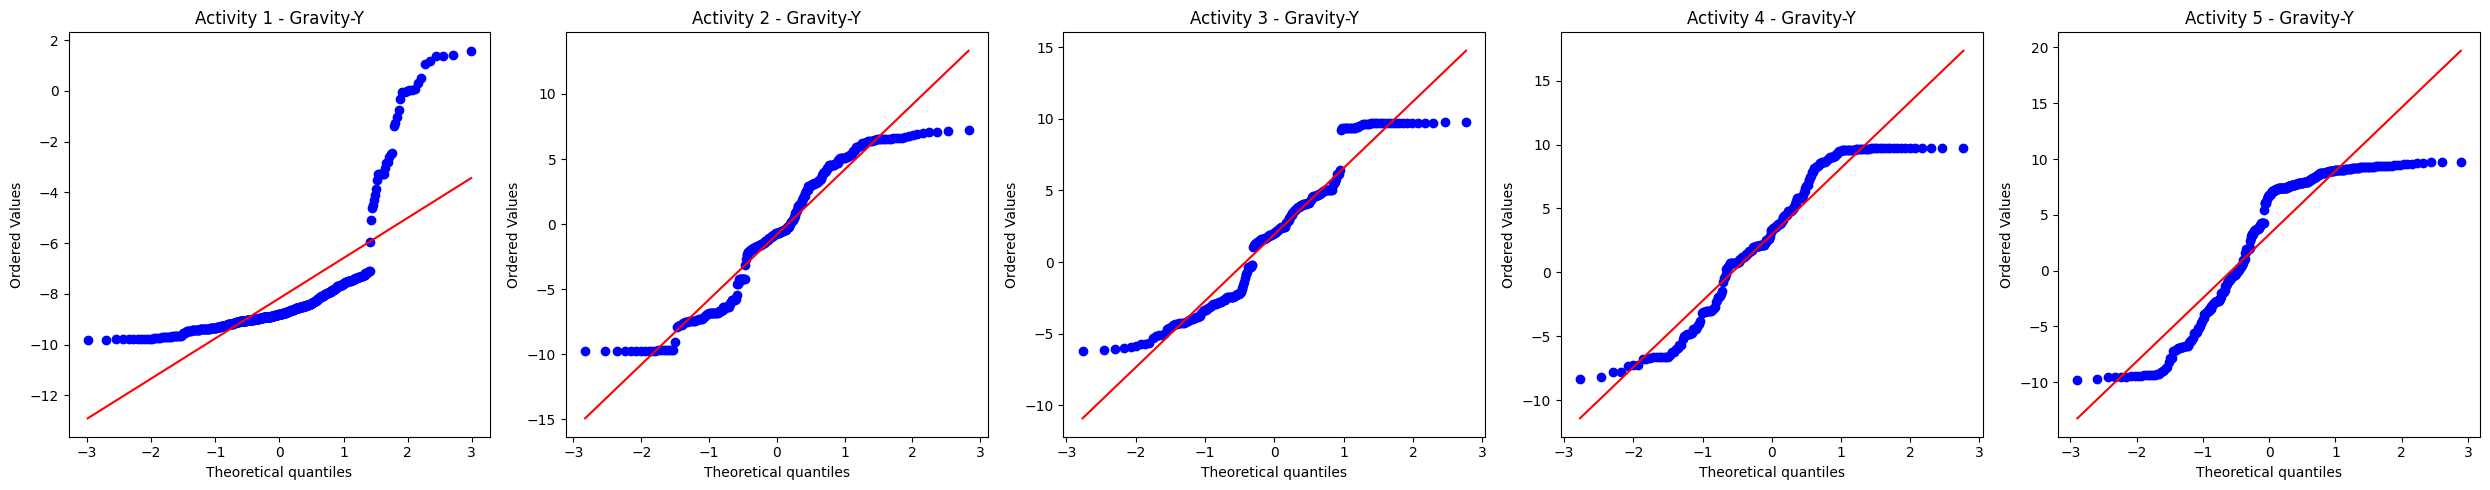

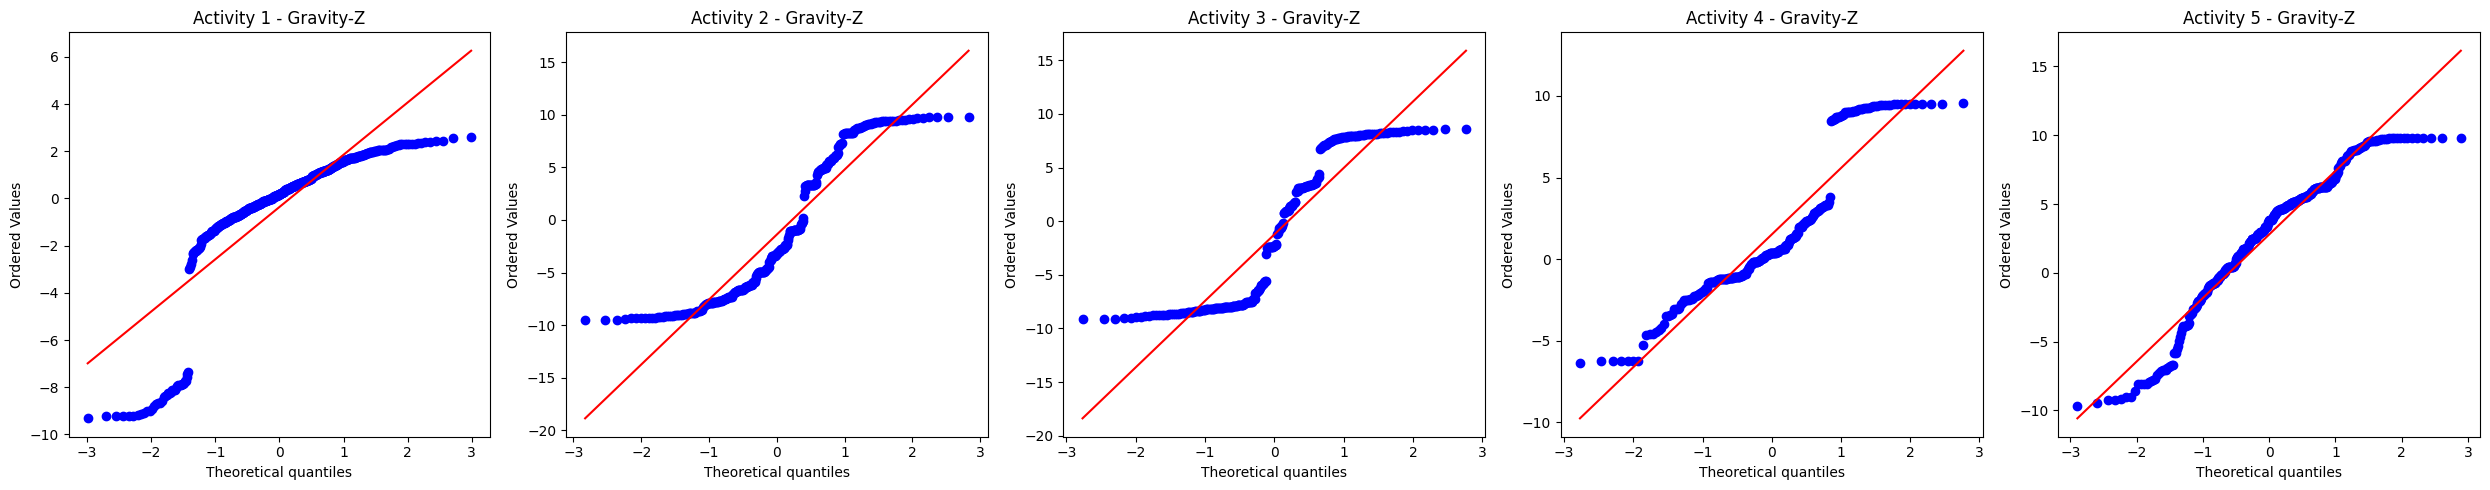

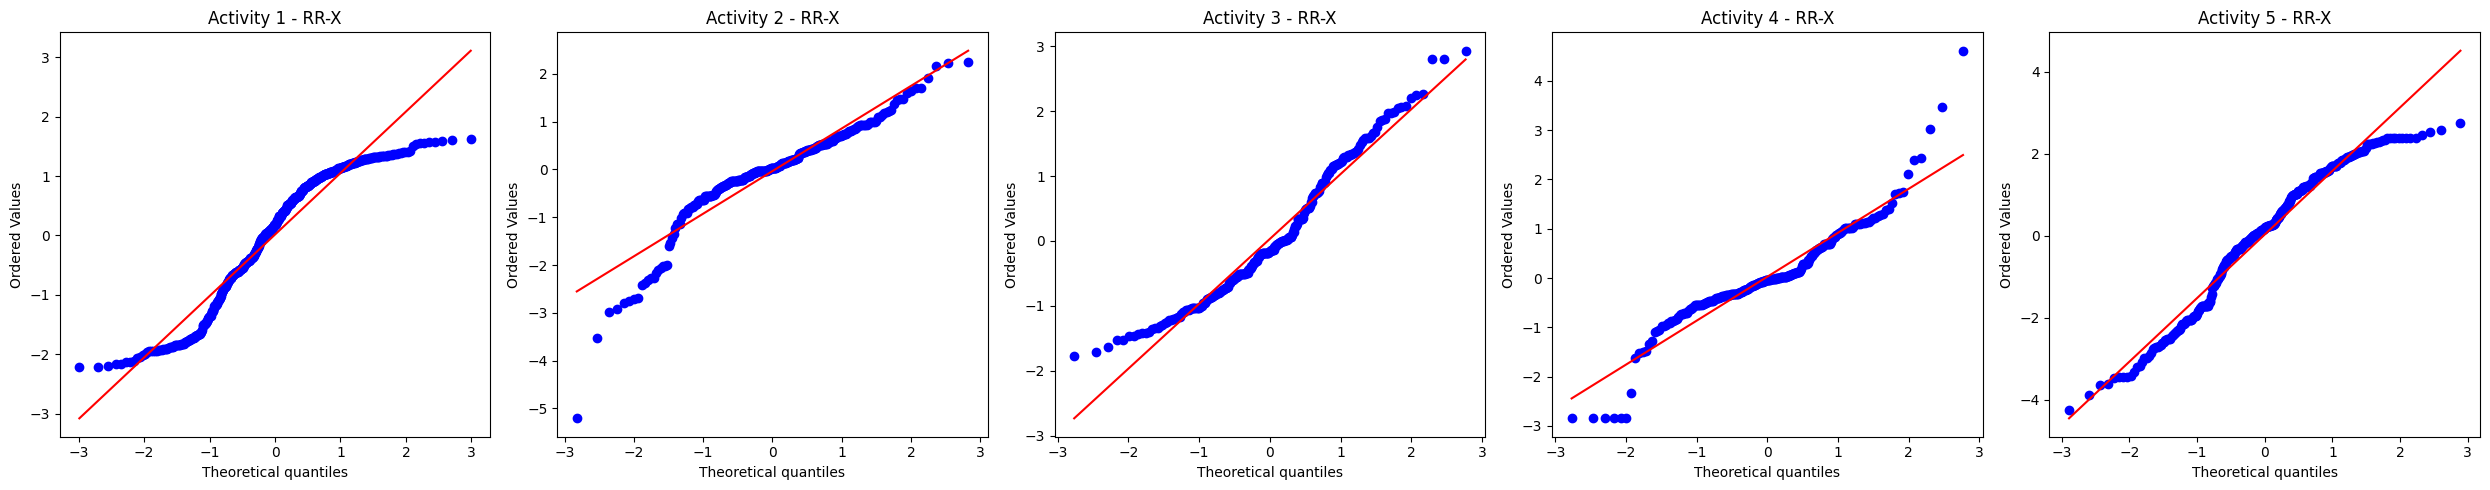

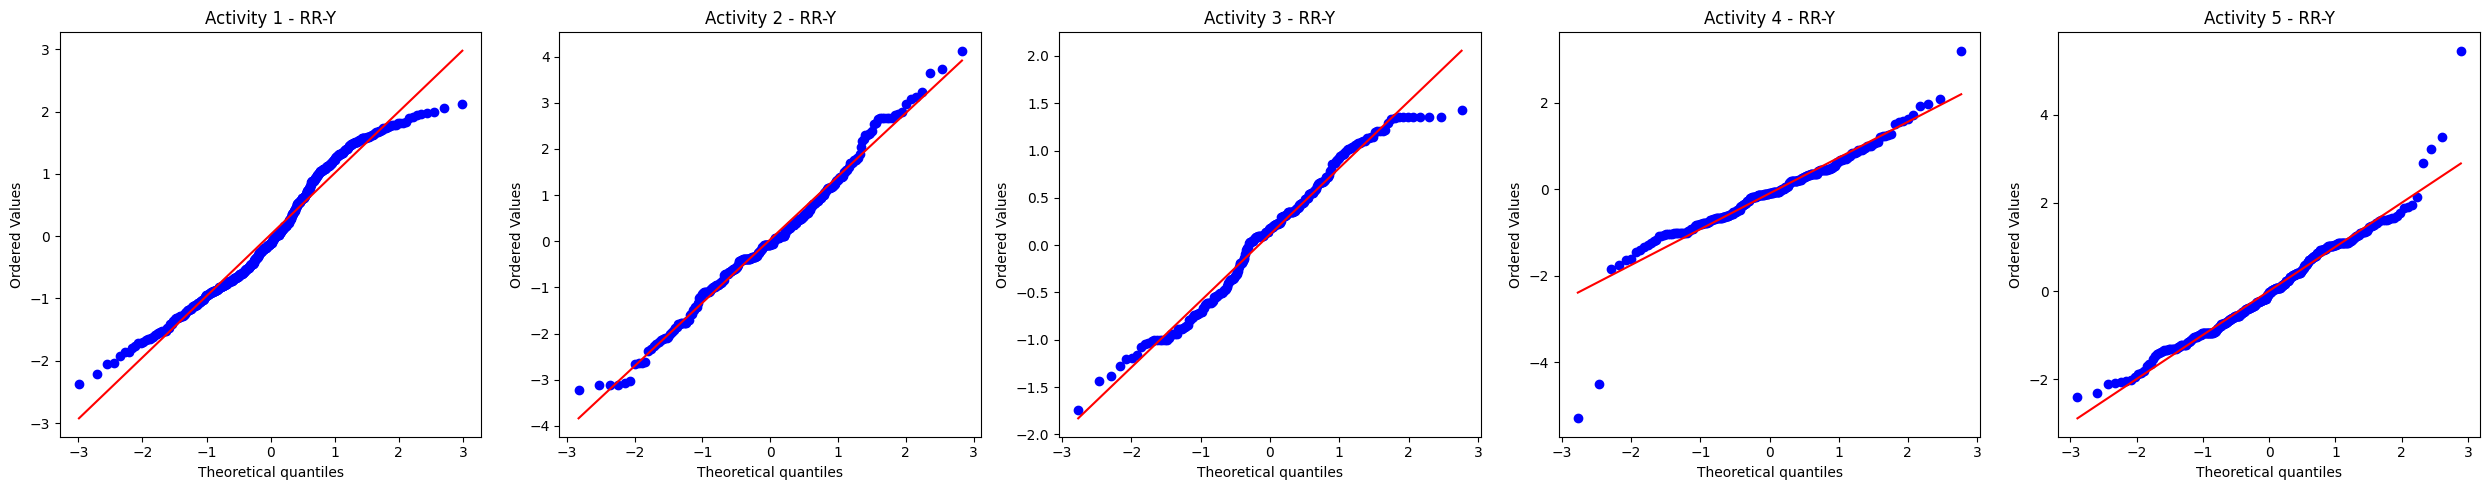

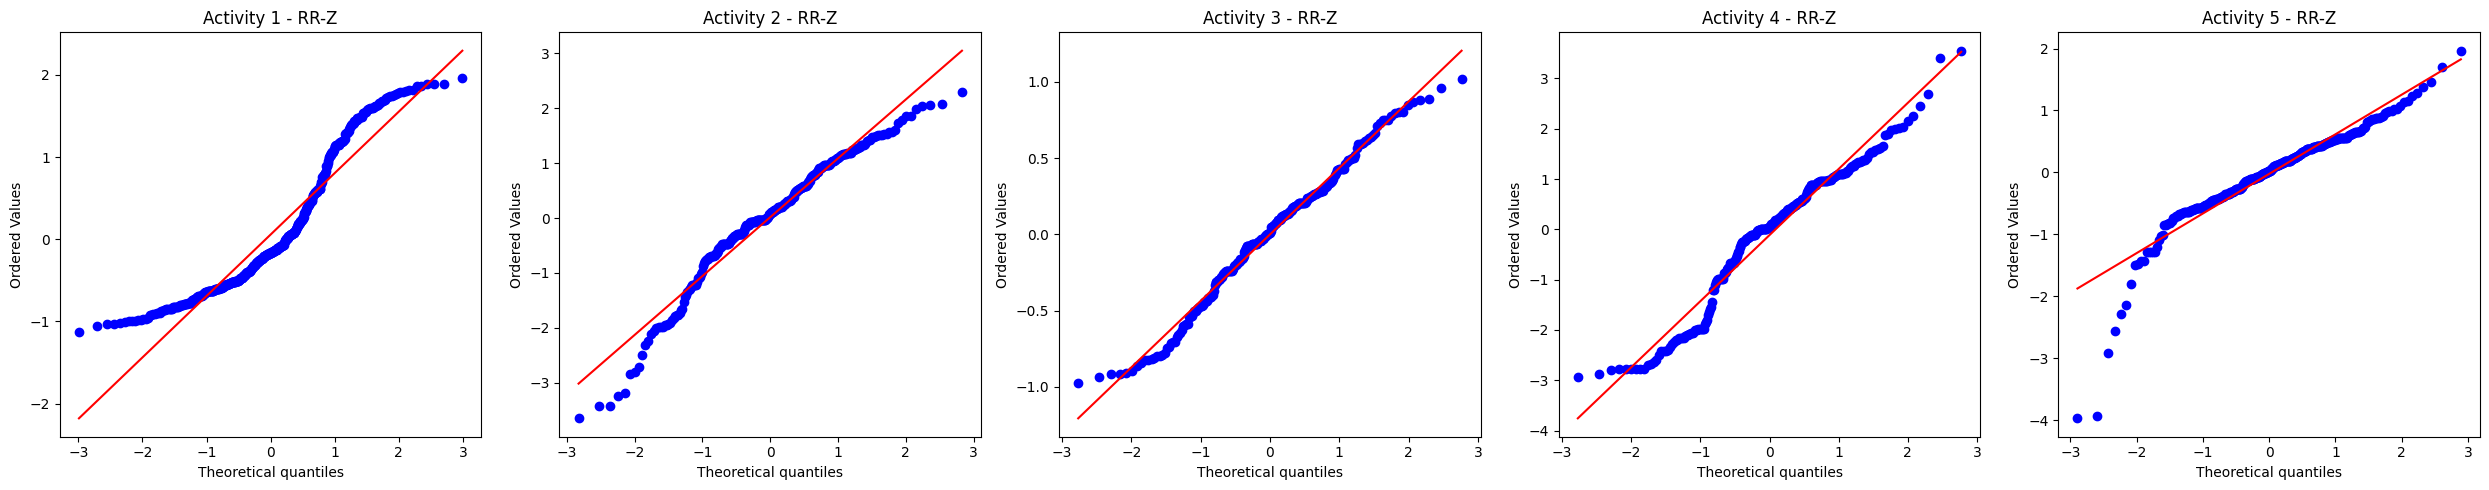

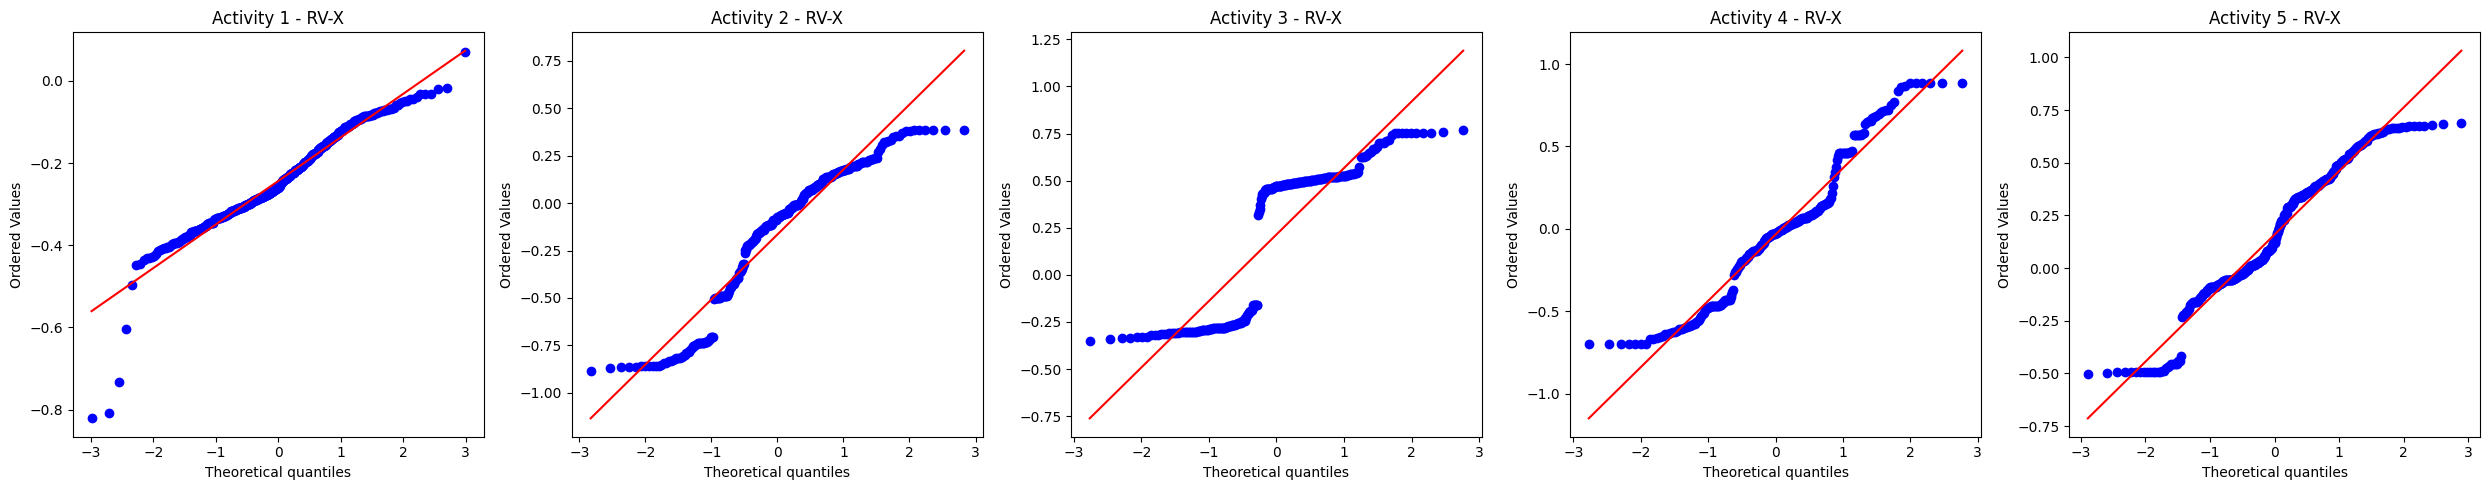

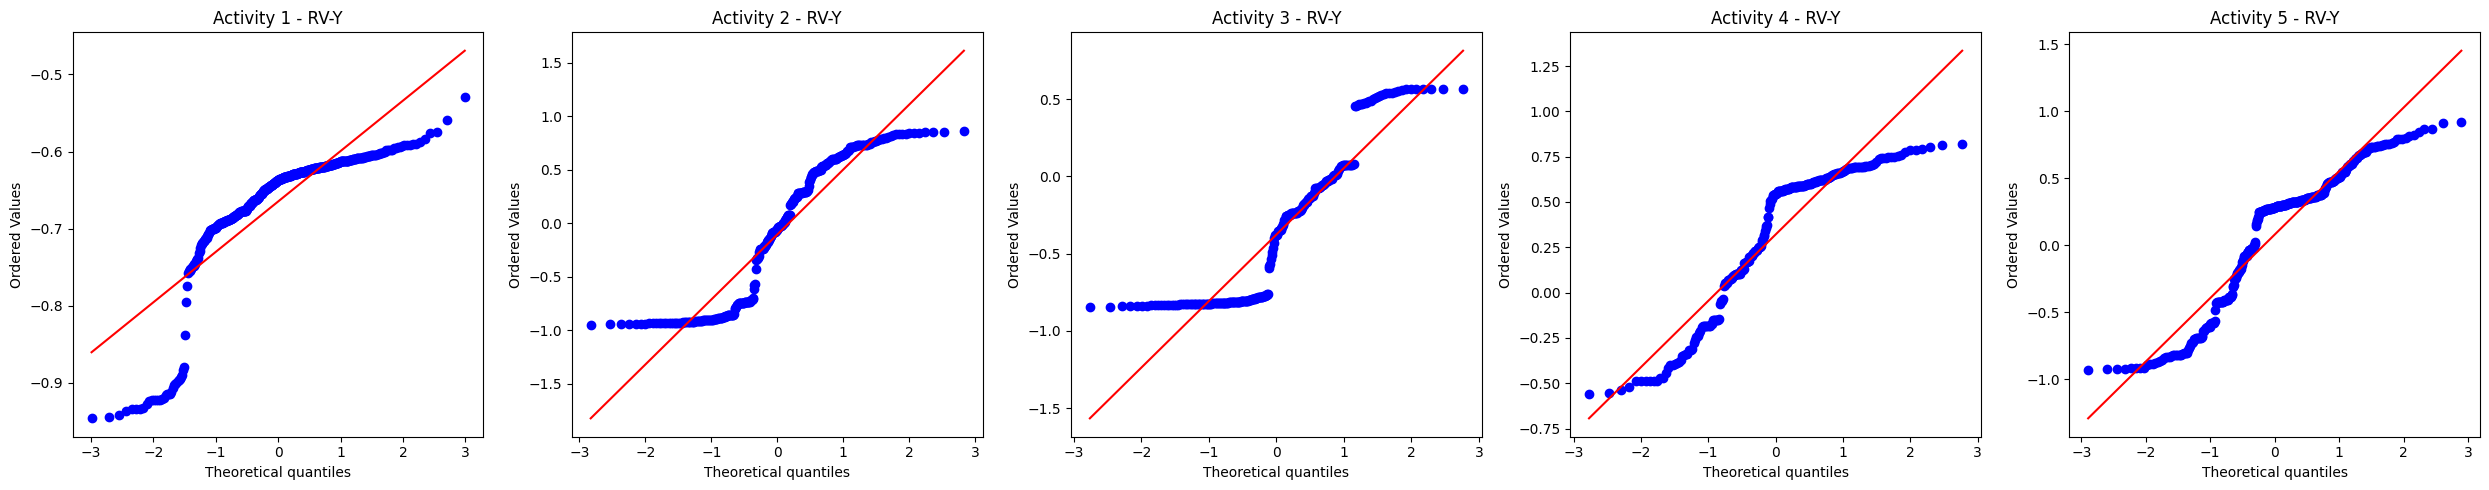

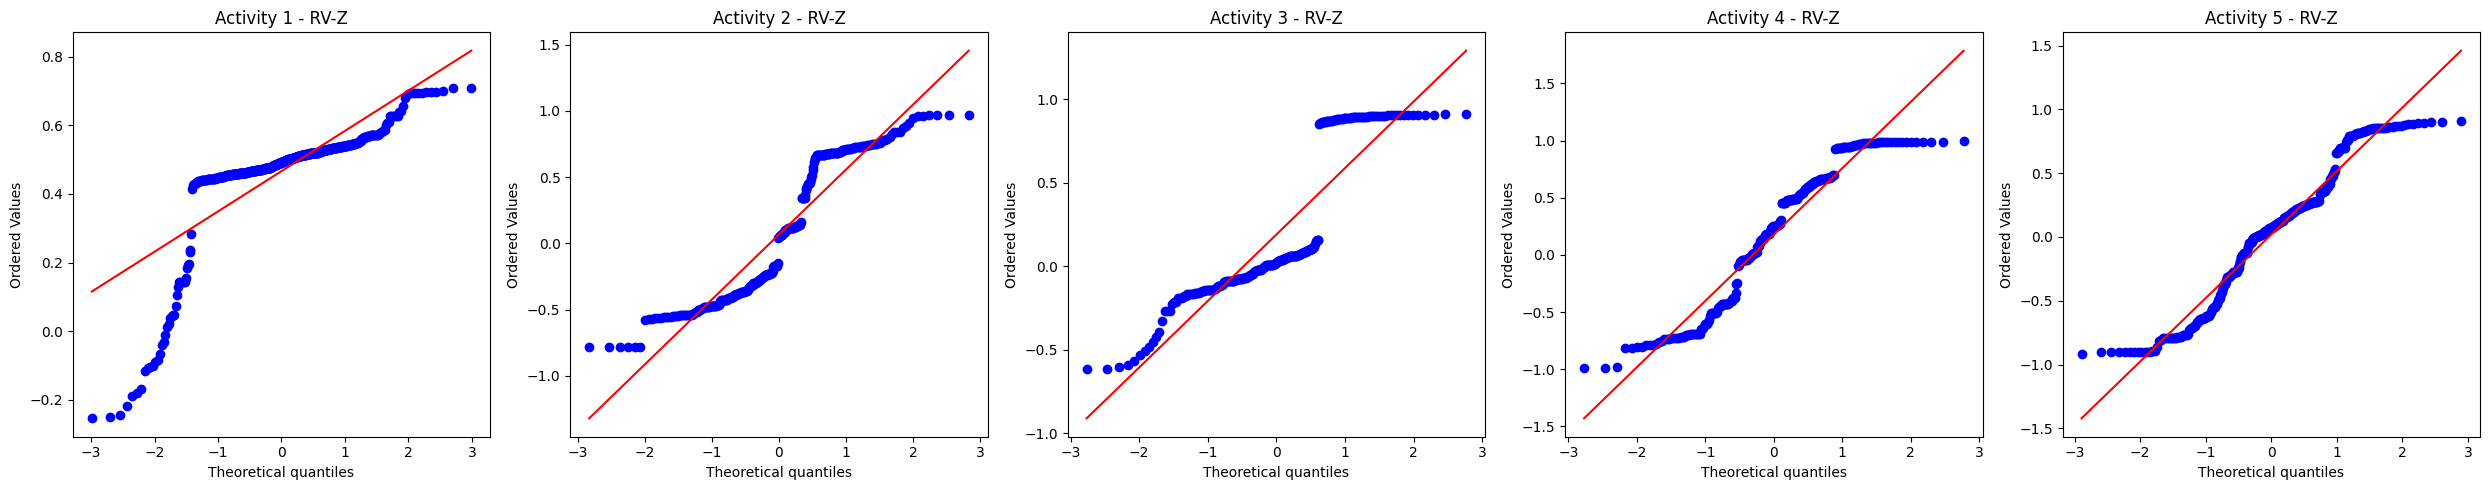

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

for col in plotty:
    # Initialize the subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

    # Plot for each activity
    for i, activity_id in enumerate(activity_ids[:5]):  # Limit to first 5 activities
        activity_data = pdf[pdf['activity'] == activity_id][col].dropna()  # Get data for the activity and column

        # Q-Q plot
        stats.probplot(activity_data, dist="norm", plot=axes[i])
        axes[i].set_title(f'Activity {activity_id} - {col}')

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Using Central limit theorm to find what was avergae value of each feature for different users so that we can figure out the line of classification

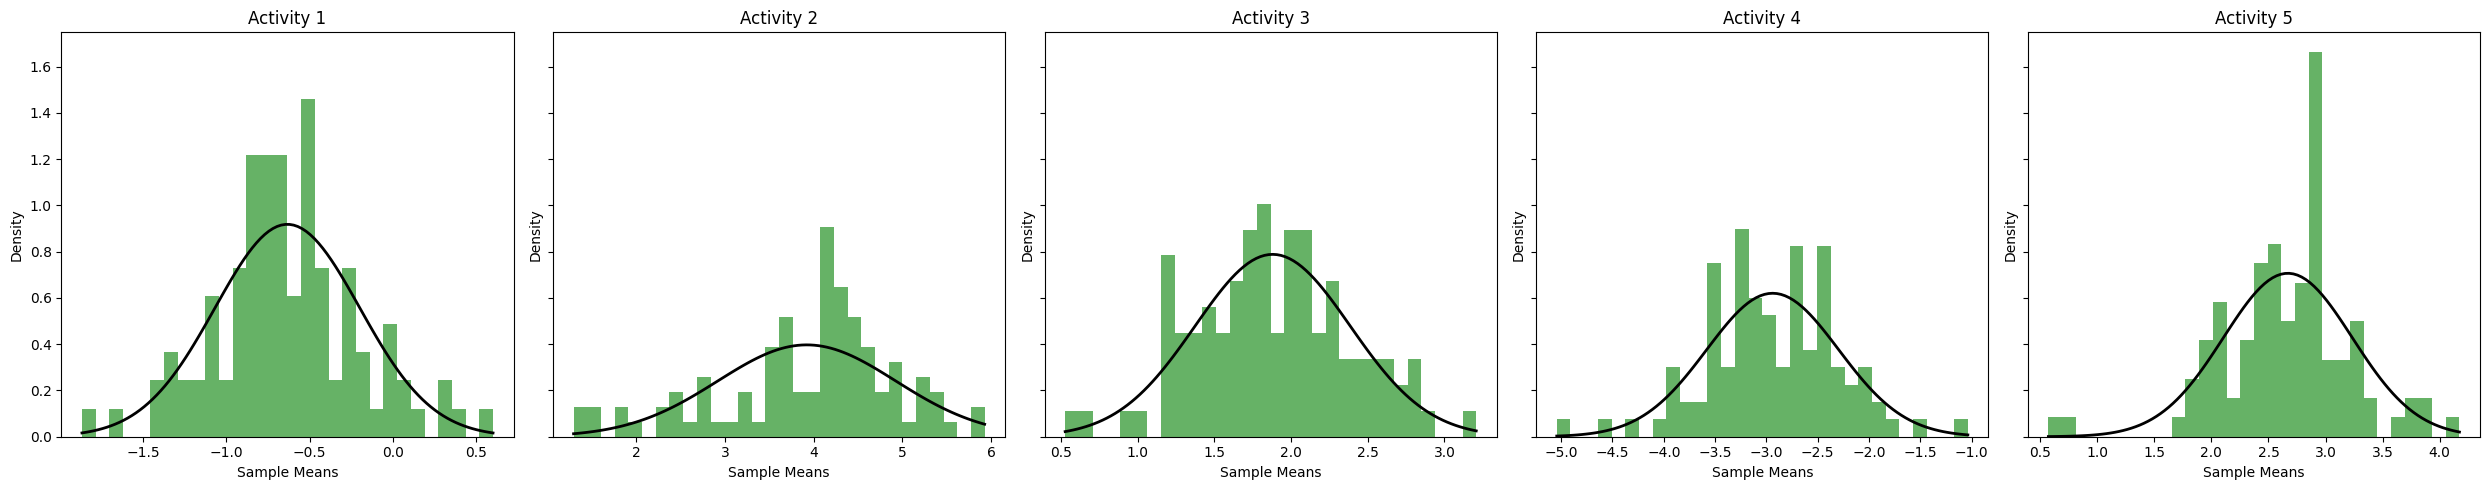

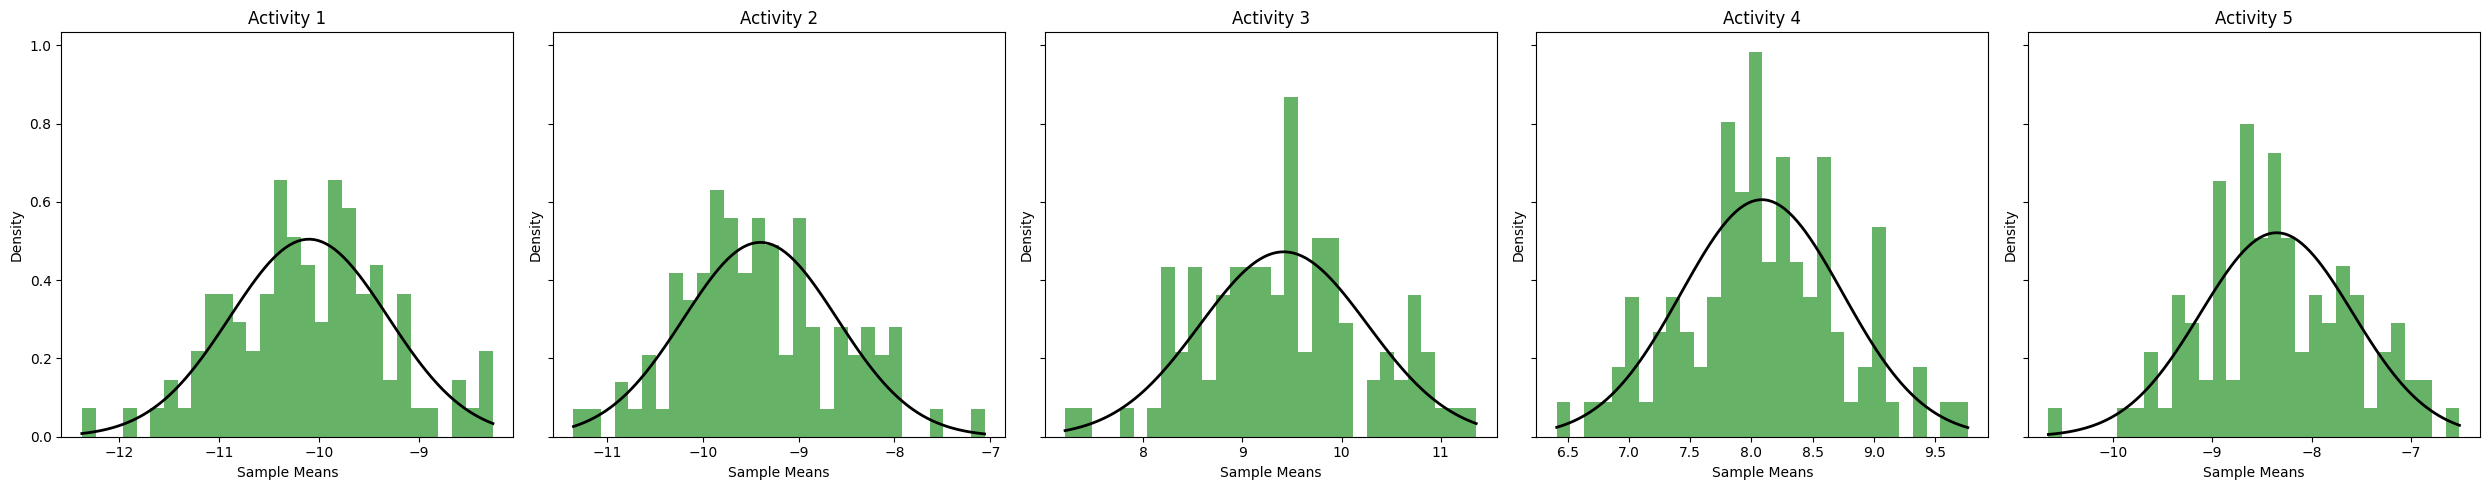

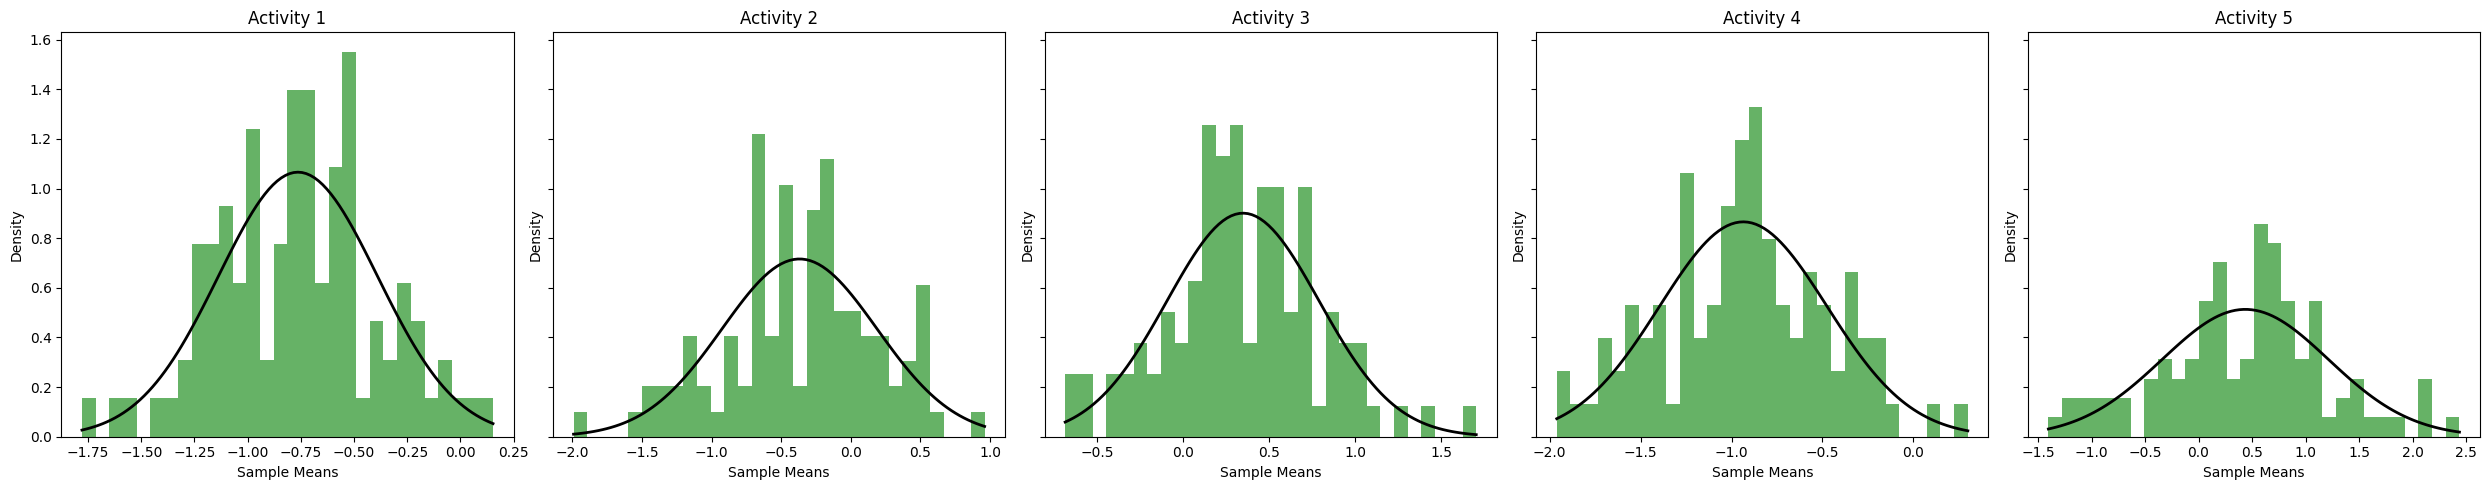

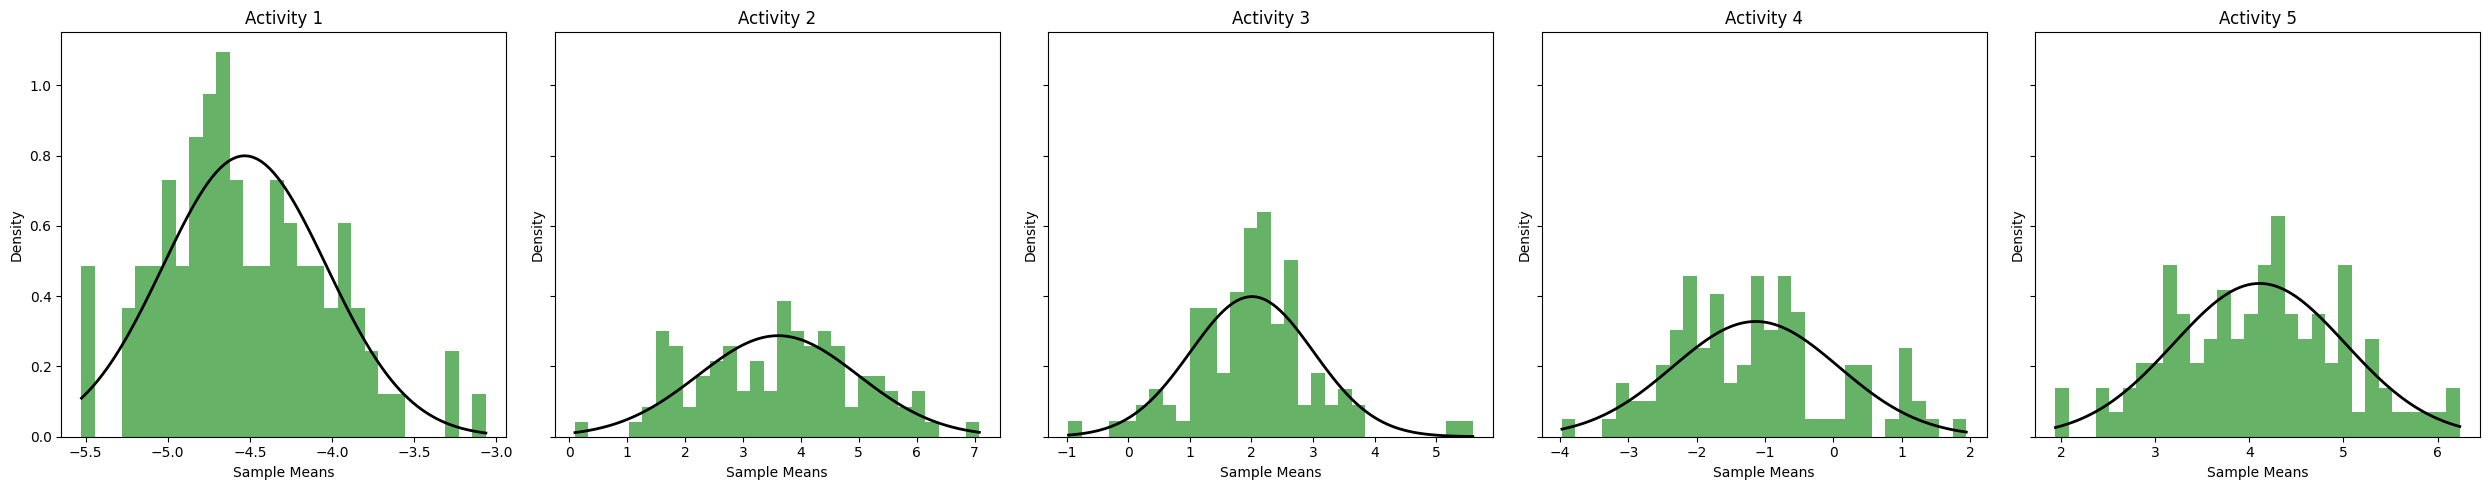

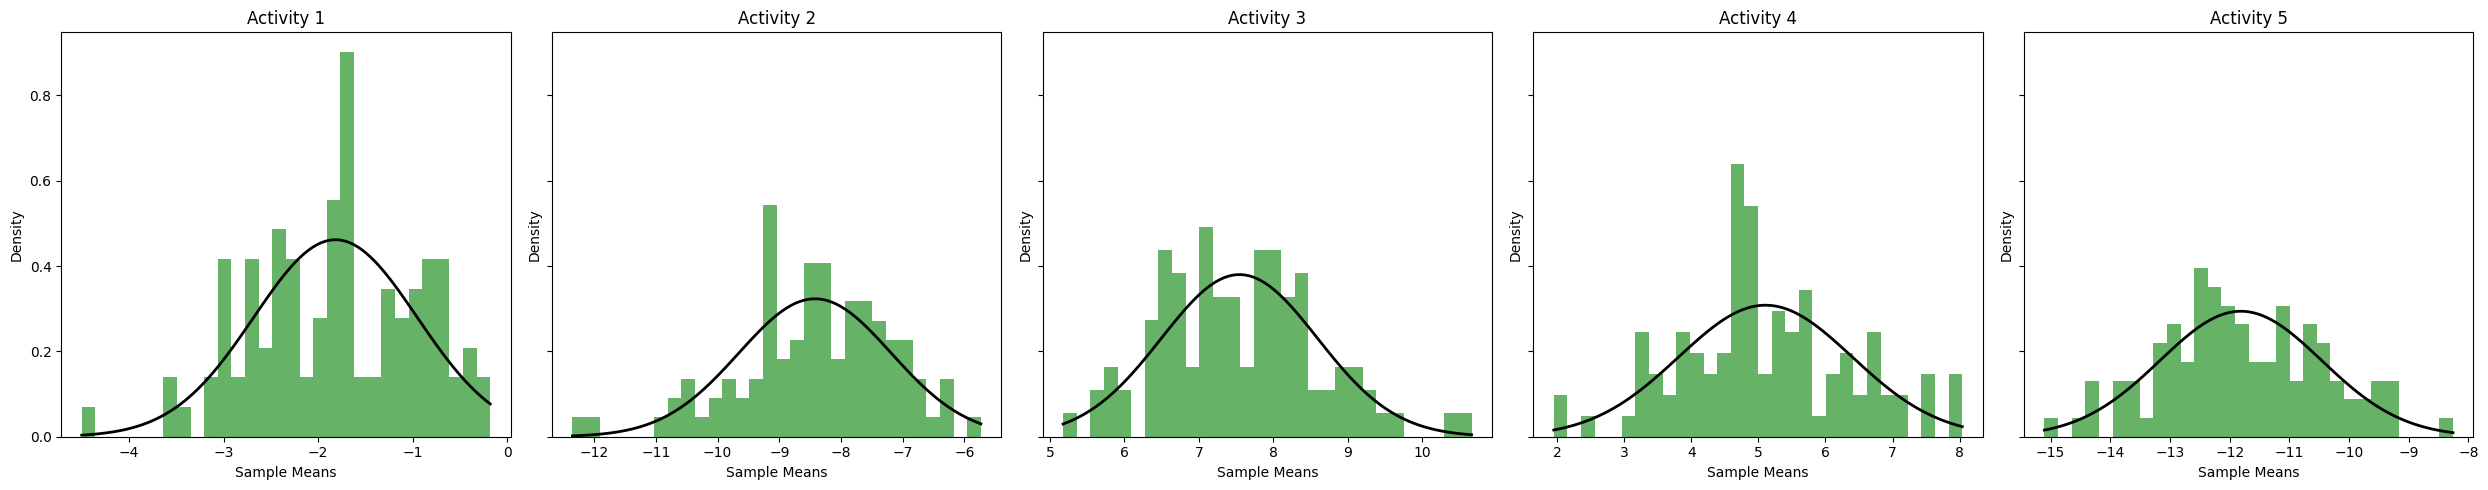

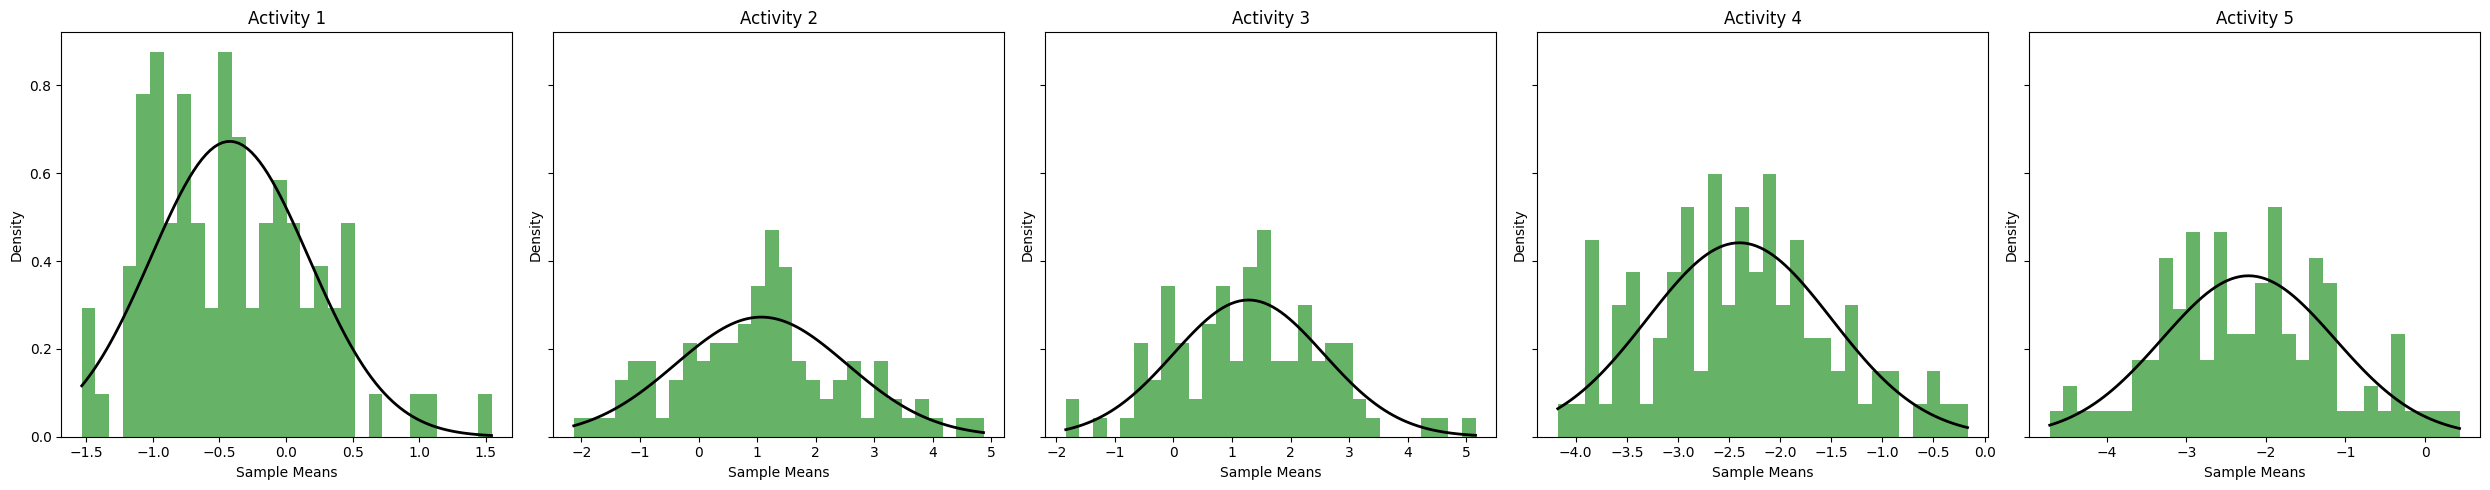

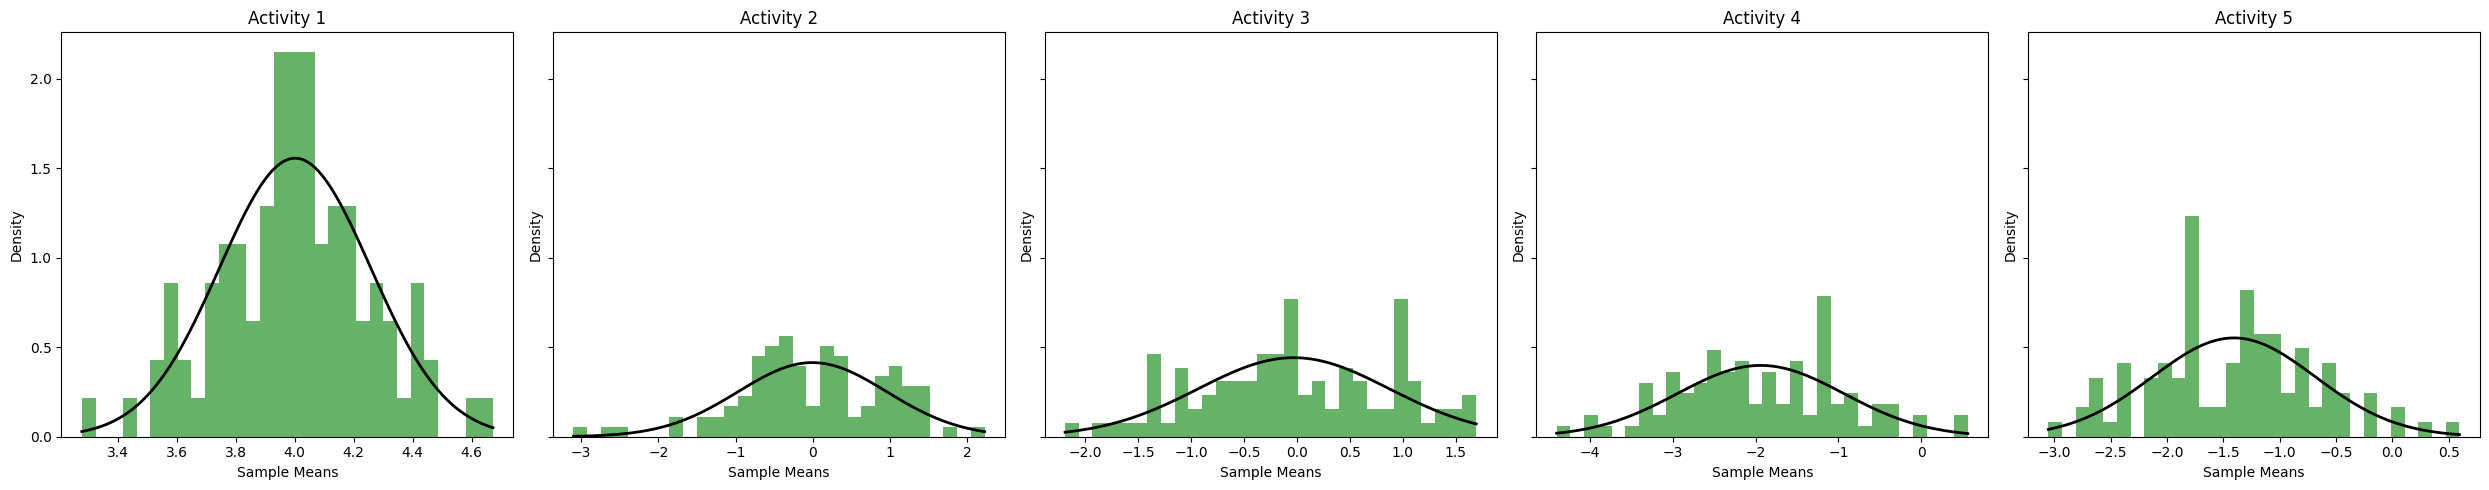

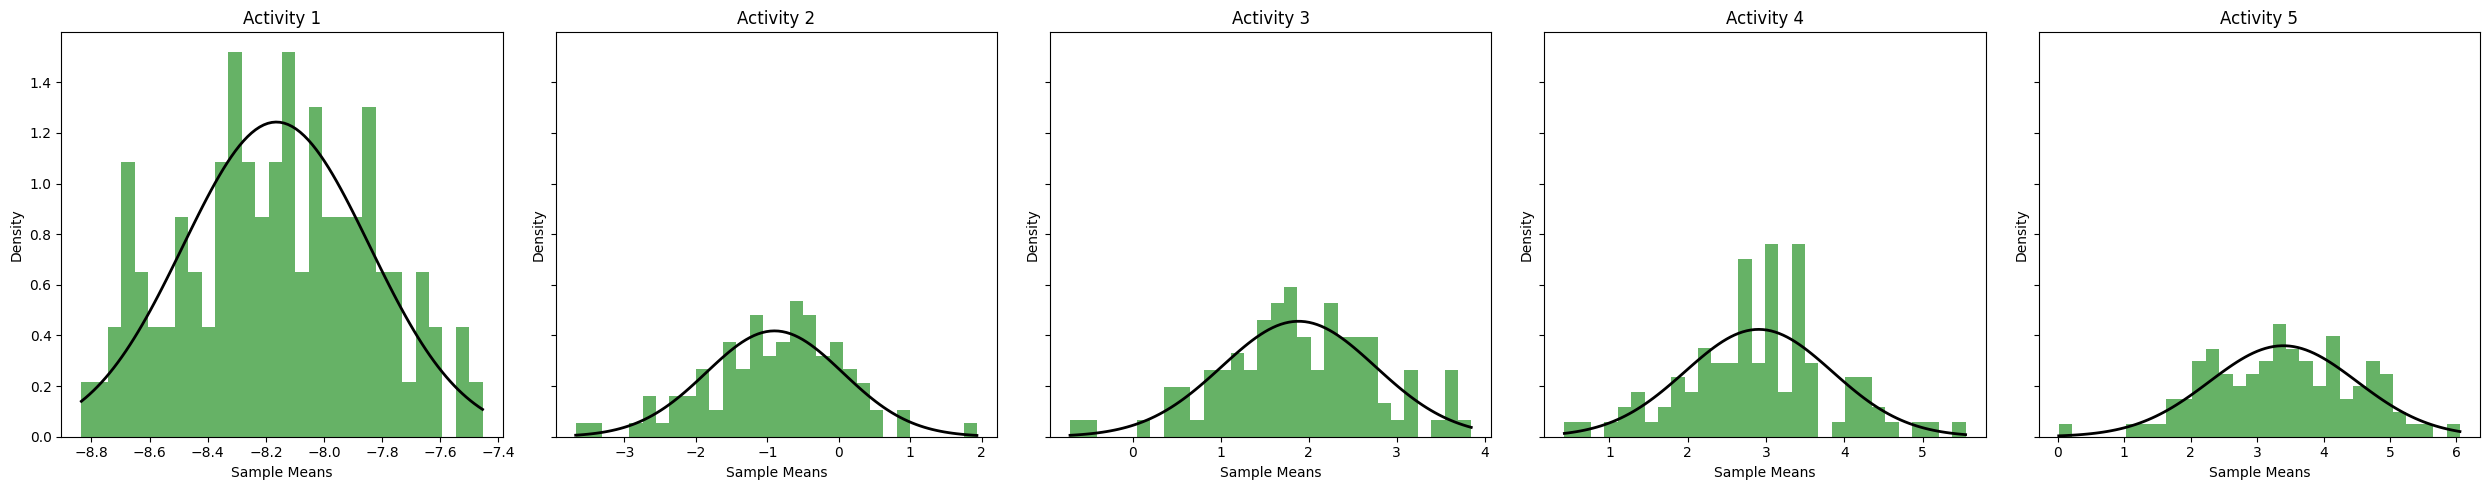

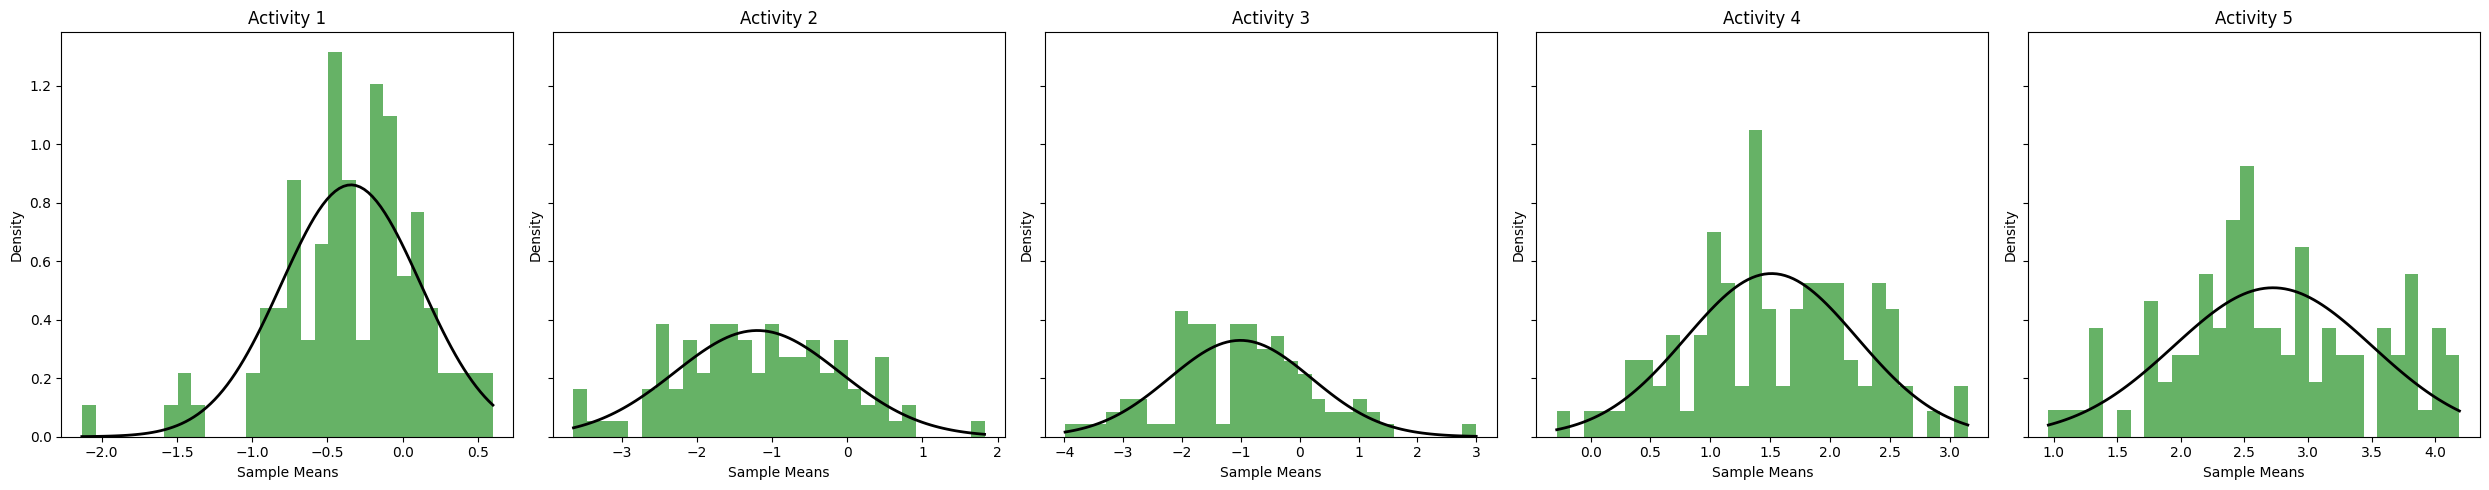

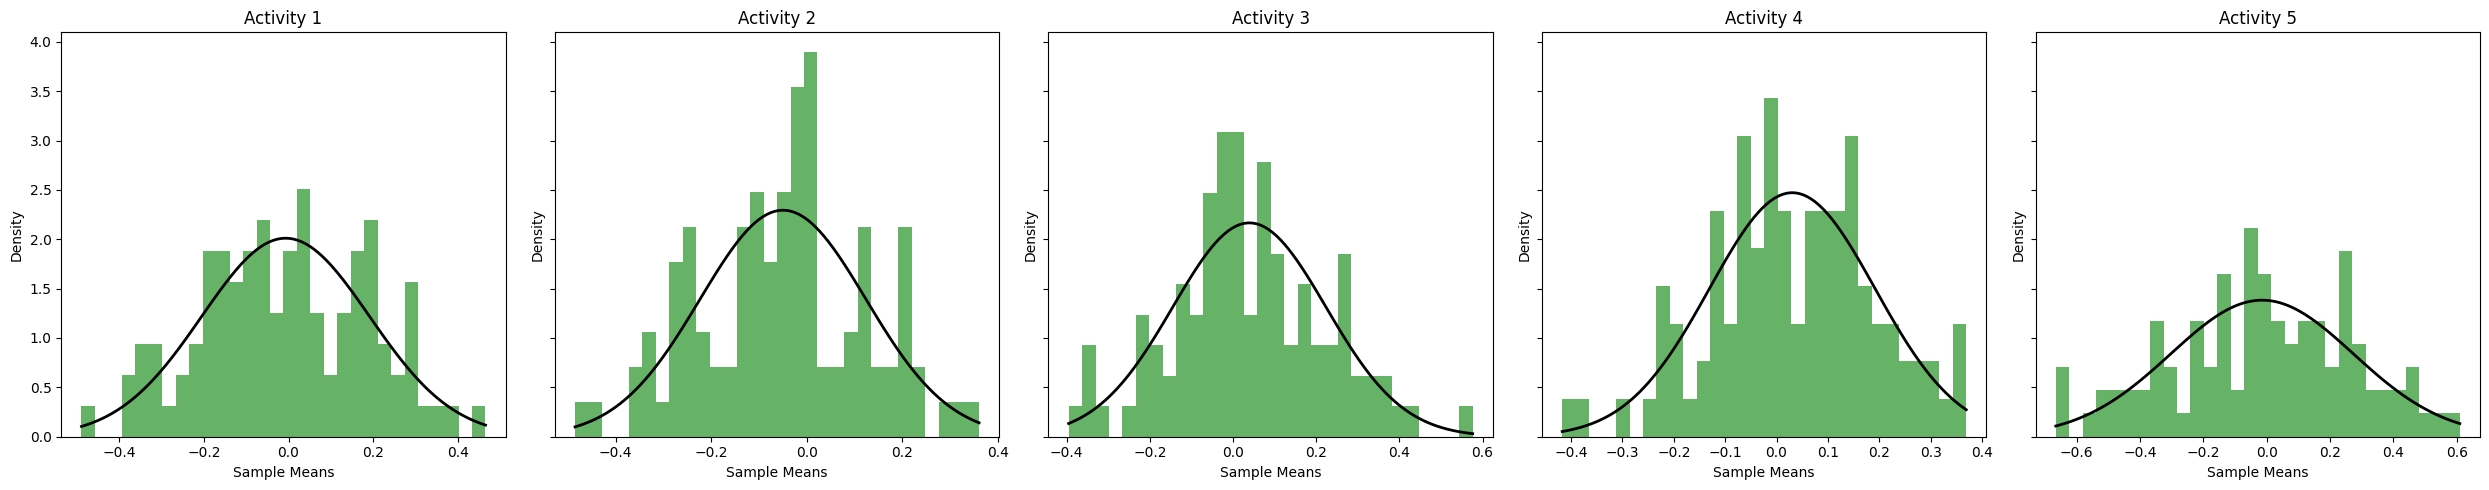

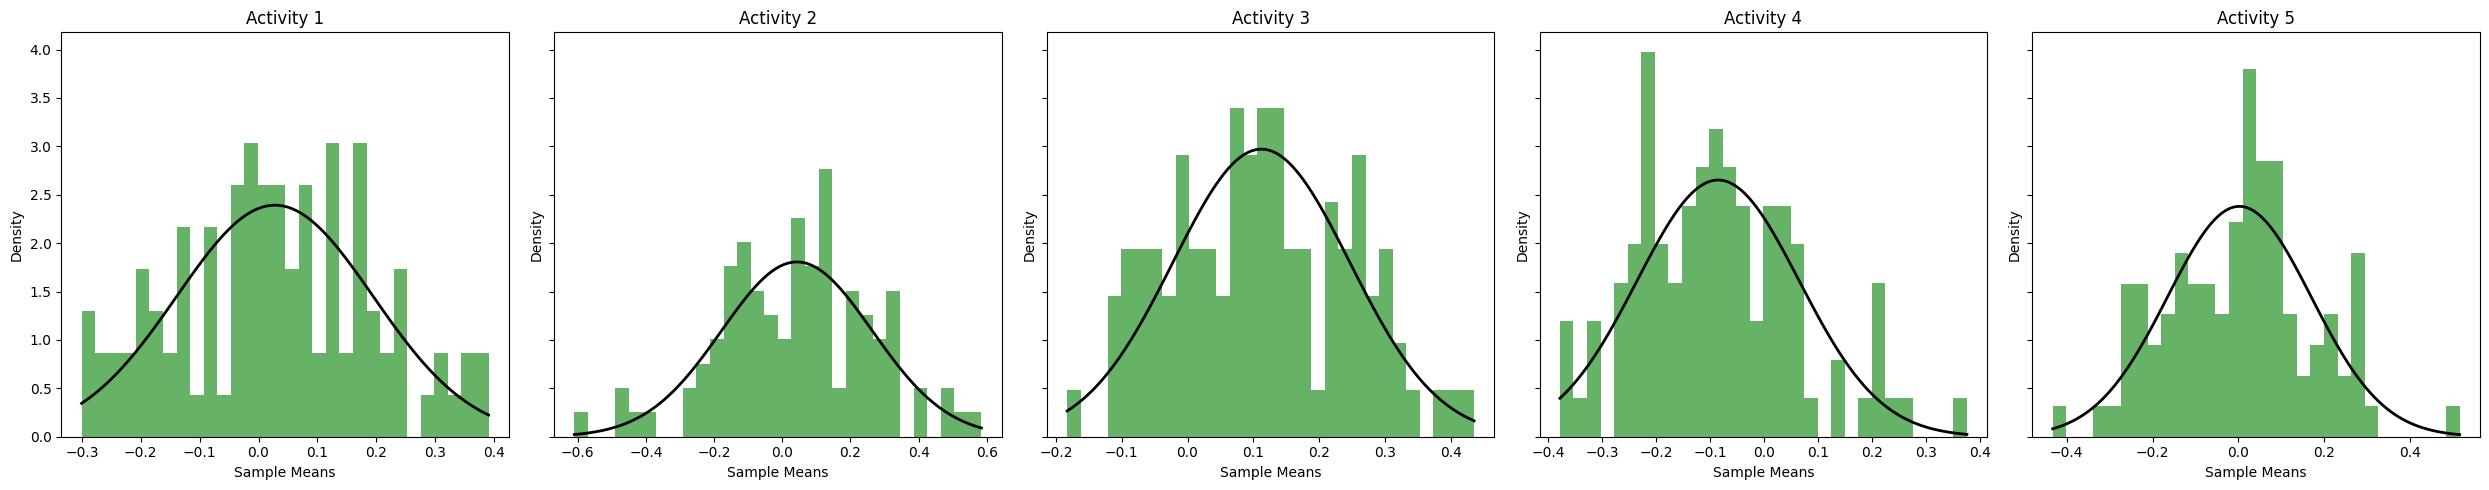

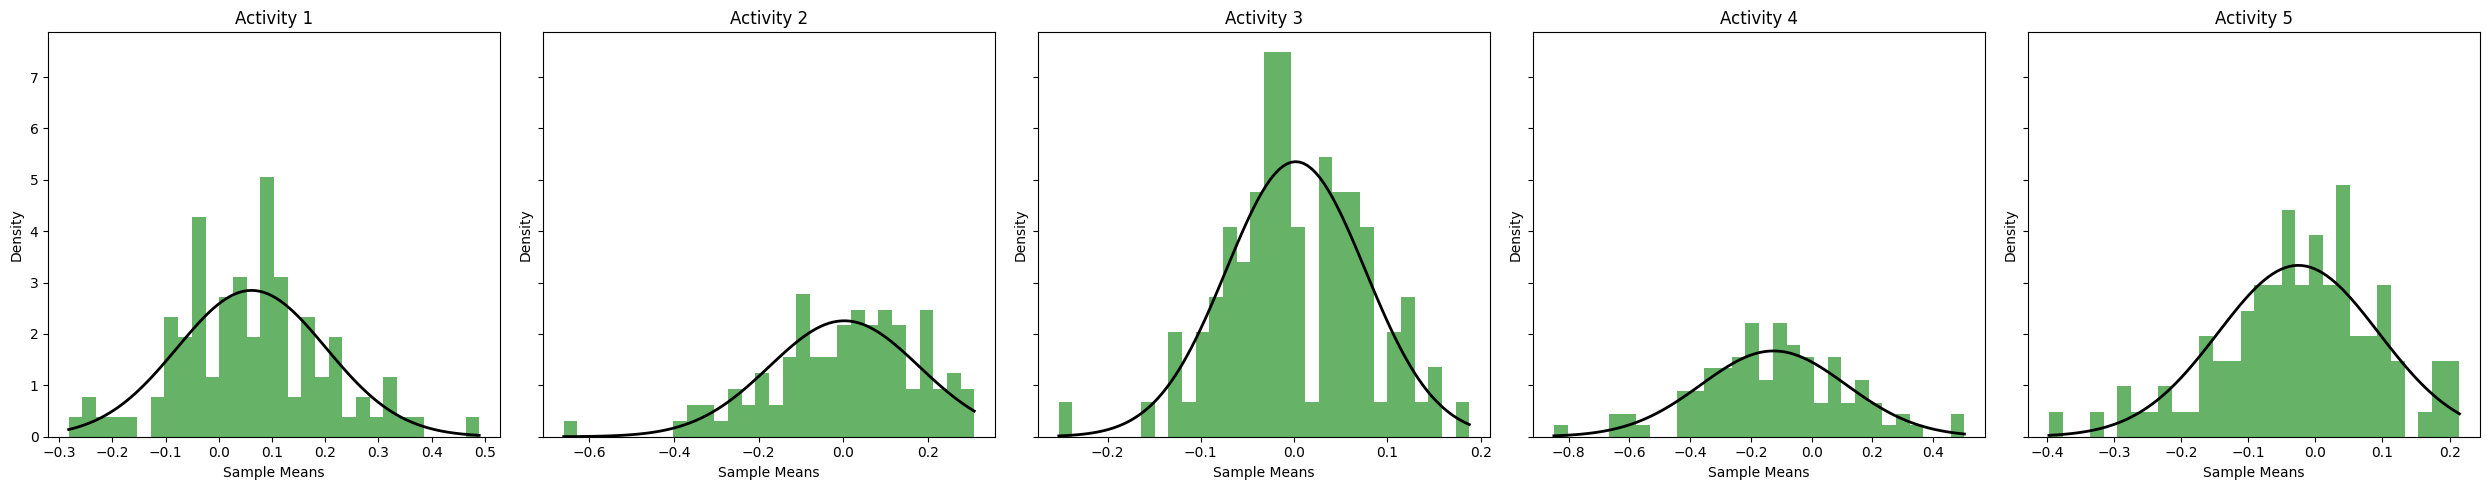

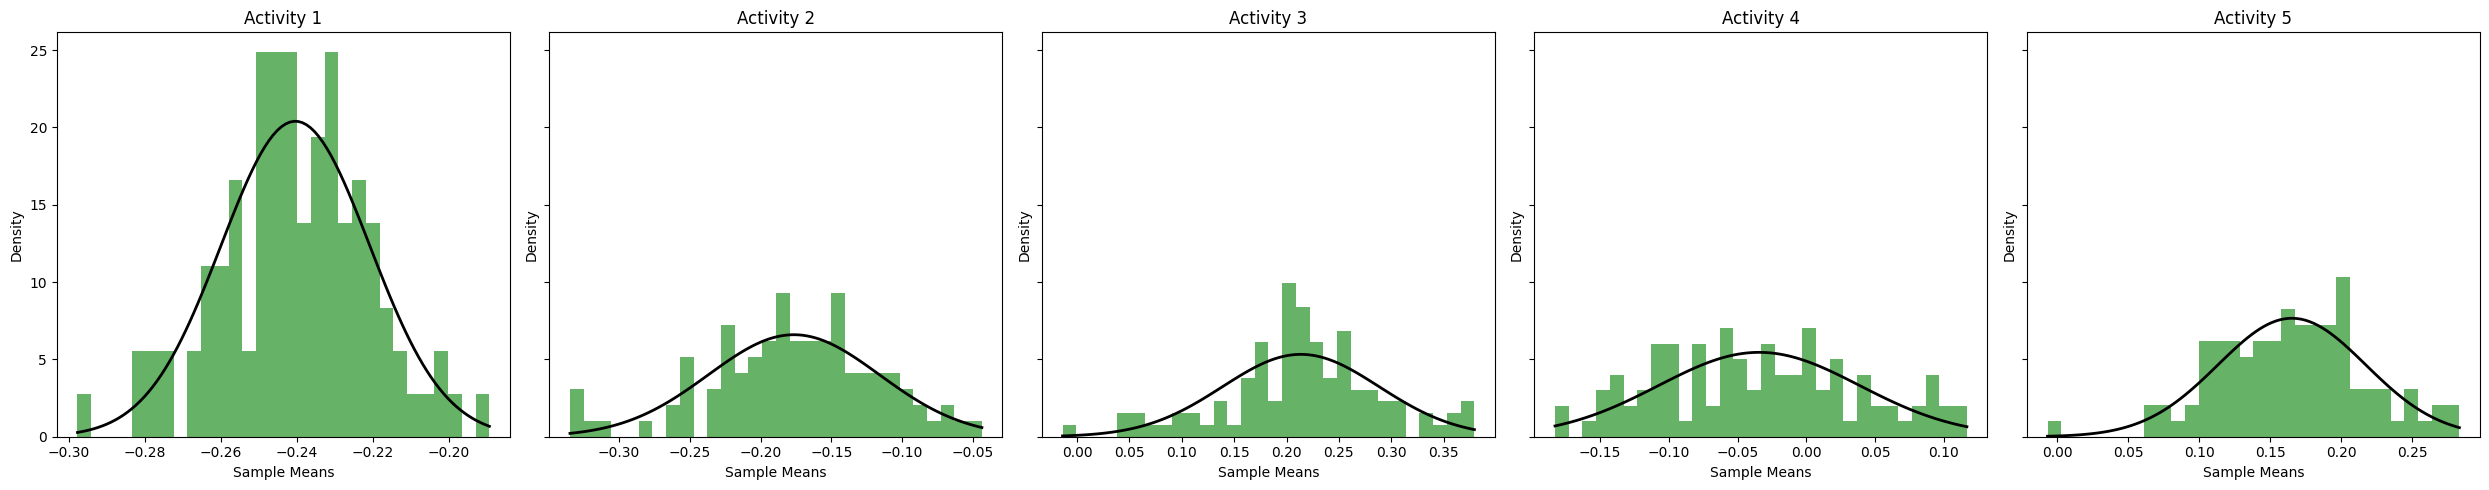

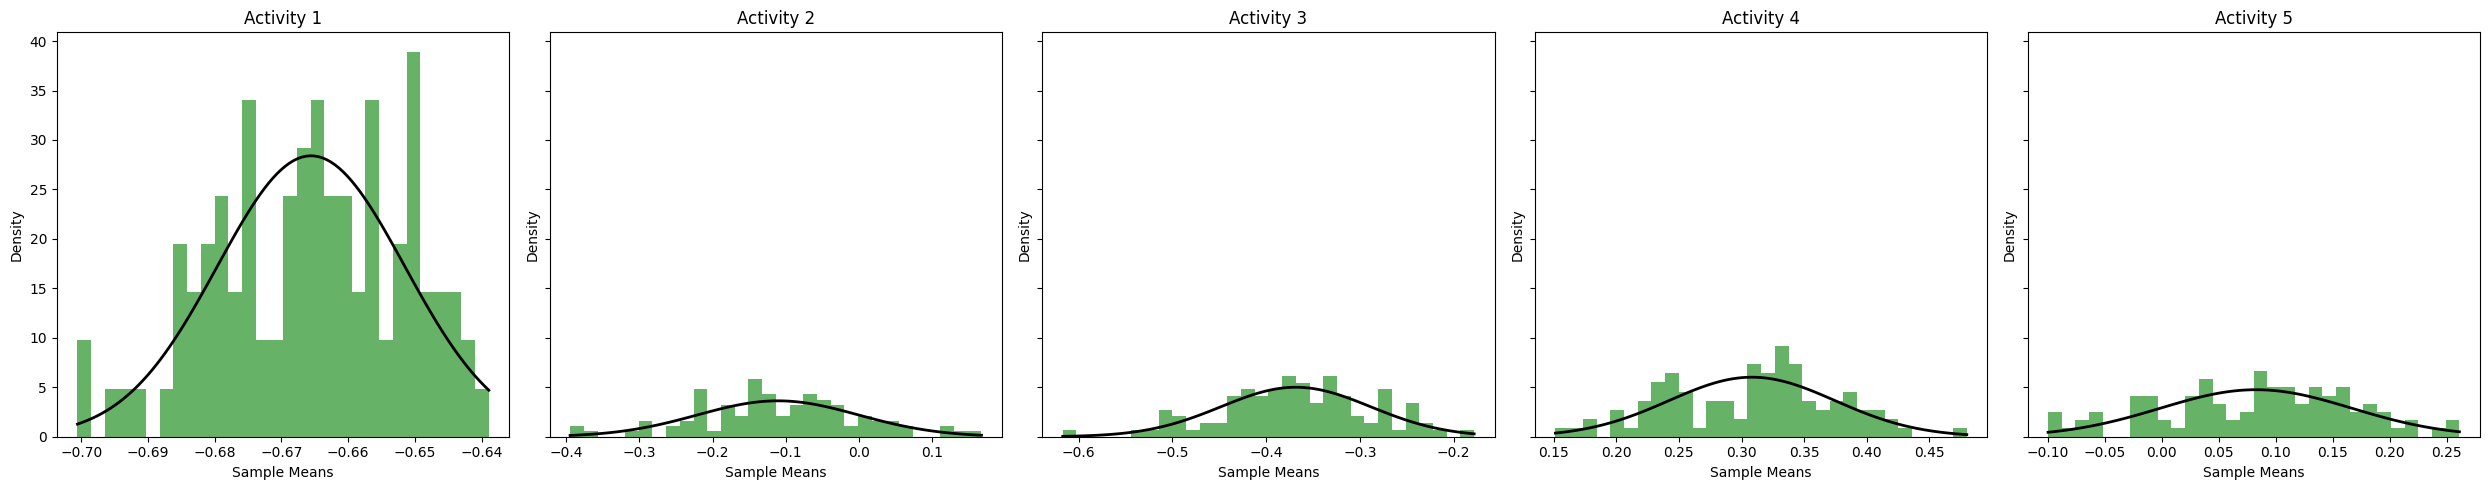

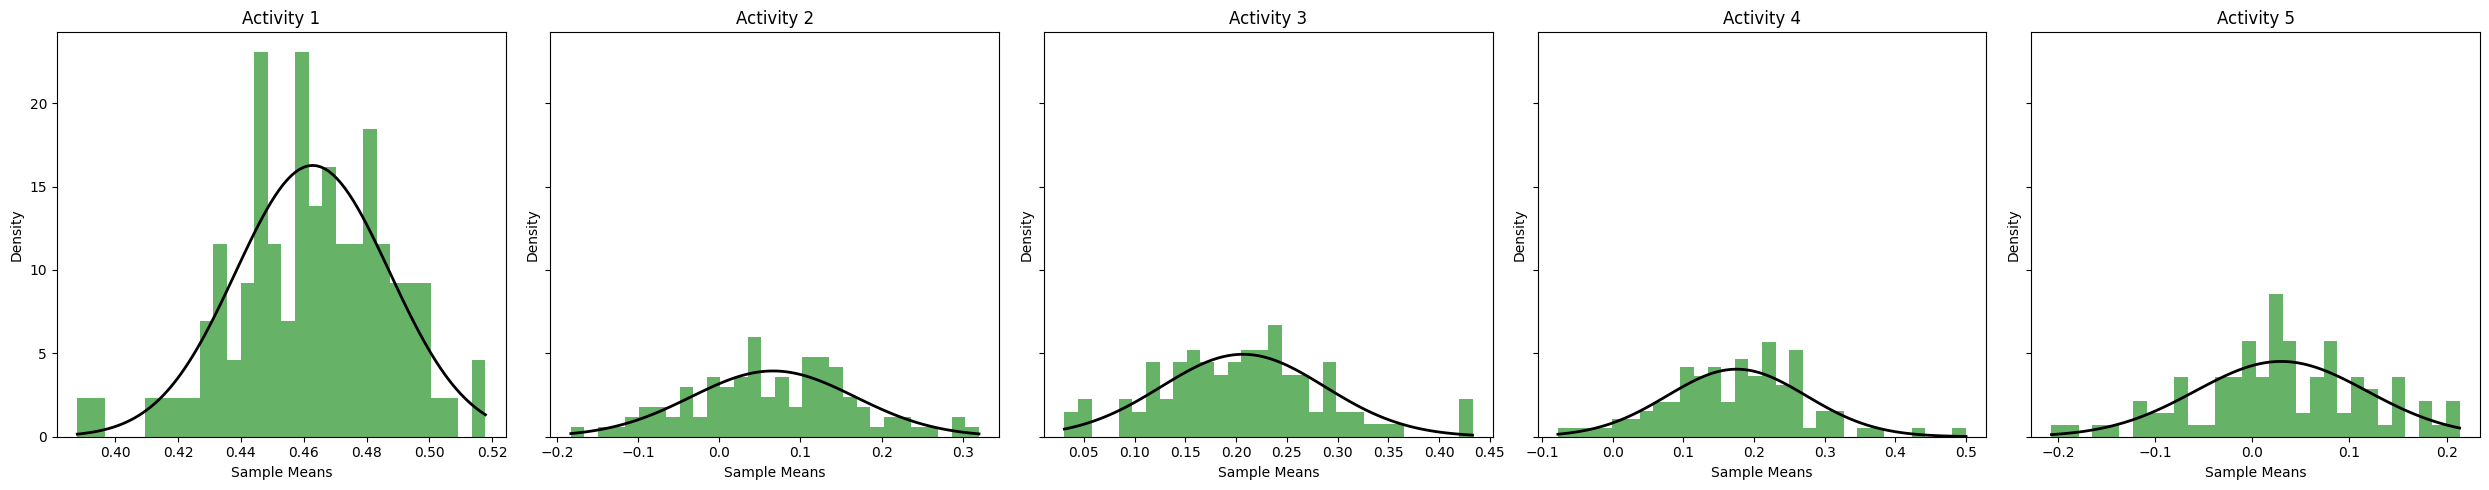

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

num_samples = 100  # Number of samples to draw for the CLT

for col in plotty:
    # Initialize the subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5), sharey=True)

    # Plot for each activity
    for i, activity_id in enumerate(activity_ids[:5]):  # Limit to first 5 activities
        activity_data = pdf[pdf['activity'] == activity_id][col].dropna()  # Get data for the activity and column
        means = []

        # Sample data multiple times to create a distribution of means
        for _ in range(num_samples):
            sample = activity_data.sample(n=30, replace=True)  # Sample 30 points with replacement
            means.append(sample.mean())

        # Fit a normal distribution to the sample means
        mu, std = np.mean(means), np.std(means)
        xmin, xmax = min(means), max(means)
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)

        # Plot the Gaussian curve
        axes[i].plot(x, p, 'k', linewidth=2)
        axes[i].hist(means, bins=30, density=True, alpha=0.6, color='g')
        axes[i].set_title(f'Activity {activity_id}')
        axes[i].set_xlabel('Sample Means')
        axes[i].set_ylabel('Density')

    # Adjust layout
    plt.tight_layout()
    plt.show()


Done